In [104]:
with open('deu.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
print("文档总共有 {} 行。".format(len(lines)))
num_samples = 20000  # 使用的语料行数
lines_to_use = lines[: min(num_samples, len(lines) - 1)]
# print(lines_to_use)

文档总共有 176693 行。


In [105]:
import re

# print(lines_to_use[19516])
for i in range(len(lines_to_use)):
    lines_to_use[i] = re.sub('\d', ' _NUMBER_ ', lines_to_use[i])
    # 用 ' _NUMBER_ ' 替换 数字（\d）
# print(lines_to_use[19516])
input_texts = []
target_texts = []
input_words = set()
target_words = set()
for line in lines_to_use:
    x, y = line.split('\t')
    y = 'BEGIN_ ' + y + ' _END'
    input_texts.append(x)
    target_texts.append(y)
    for word in x.split():
        if word not in input_words:
            input_words.add(word)
    for word in y.split():
        if word not in target_words:
            target_words.add(word)

In [106]:
max_input_seq_len = max([len(seq.split()) for seq in input_texts])
# 11
max_target_seq_len = max([len(seq.split()) for seq in target_texts])
# 15

input_words = sorted(list(input_words))
target_words = sorted(list(target_words))
num_encoder_tokens = len(input_words)  # 5724
num_decoder_tokens = len(target_words)  # 9126

In [107]:
inputToken_idx = {token: i for (i, token) in enumerate(input_words)}
outputToken_idx = {token: i for (i, token) in enumerate(target_words)}
idx_inputToken = {i: token for (i, token) in enumerate(input_words)}
idx_outputToken = {i: token for (i, token) in enumerate(target_words)}

In [108]:
import numpy as np

encoder_input_data = np.zeros(
    (len(input_texts), max_input_seq_len),
    # 句子数量，         最大输入句子长度
    dtype=np.float32
)

decoder_input_data = np.zeros(
    (len(target_texts), max_target_seq_len),
    # 句子数量，          最大输出句子长度
    dtype=np.float32
)

decoder_output_data = np.zeros(
    (len(target_texts), max_target_seq_len, num_decoder_tokens),
    # 句子数量，          最大输出句子长度,      输出 tokens ids 个数
    dtype=np.float32
)

In [109]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = inputToken_idx[word]
    for t, word in enumerate(target_text.split()):
        decoder_input_data[i, t] = outputToken_idx[word]
        if t > 0:
            # 解码器的输出比输入提前一个时间步
            decoder_output_data[i, t - 1, outputToken_idx[word]] = 1.

In [110]:
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

embedding_size = 512  # 嵌入维度
rnn_size = 128
# 编码器
encoder_inputs = Input(shape=(None,))
encoder_after_embedding = Embedding(input_dim=num_encoder_tokens,  # 单词个数
                                    output_dim=embedding_size)(encoder_inputs)
encoder_lstm = LSTM(units=rnn_size, return_state=True)
# return_state: Boolean. Whether to return
#   the last state in addition to the output.
_, state_h, state_c = encoder_lstm(encoder_after_embedding)
encoder_states = [state_h, state_c] #

# 解码器
decoder_inputs = Input(shape=(None,))
decoder_after_embedding = Embedding(input_dim=num_decoder_tokens,  # 单词个数
                                    output_dim=embedding_size)(decoder_inputs)
decoder_lstm = LSTM(units=rnn_size, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_after_embedding,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [117]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

from keras.utils import plot_model
plot_model(model,to_file='model.png')

Model: "functional_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, None, 512)    2930688     input_15[0][0]                   
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, None, 512)    4672512     input_16[0][0]                   
______________________________________________________________________________________

In [112]:
from keras.callbacks import ModelCheckpoint

filepath = 'model.best.h5'
# 有一次提升, 则覆盖一次.
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max', save_freq=1)
callbacks_list = [checkpoint]
# https://keras.io/api/callbacks/model_checkpoint/


history = model.fit(x=[encoder_input_data, decoder_input_data], y=decoder_output_data,
                    batch_size=128, epochs=100, validation_split=0.1,
                    callbacks=callbacks_list)
model.save('model.h5')

Epoch 1/100

Epoch 00001: accuracy improved from -inf to 0.00052, saving model to model.best.h5
  1/141 [..............................] - ETA: 0s - loss: 2.8402 - accuracy: 5.2083e-04
Epoch 00001: accuracy improved from 0.00052 to 0.02474, saving model to model.best.h5
  2/141 [..............................] - ETA: 1:18 - loss: 2.8490 - accuracy: 0.0247  
Epoch 00001: accuracy improved from 0.02474 to 0.03872, saving model to model.best.h5
  3/141 [..............................] - ETA: 1:42 - loss: 2.8766 - accuracy: 0.0387
Epoch 00001: accuracy improved from 0.03872 to 0.04570, saving model to model.best.h5
  4/141 [..............................] - ETA: 1:54 - loss: 2.8732 - accuracy: 0.0457
Epoch 00001: accuracy improved from 0.04570 to 0.04990, saving model to model.best.h5
  5/141 [>.............................] - ETA: 2:10 - loss: 2.8715 - accuracy: 0.0499
Epoch 00001: accuracy improved from 0.04990 to 0.05269, saving model to model.best.h5
  6/141 [>.........................

 48/141 [=========>....................] - ETA: 1:37 - loss: 2.2475 - accuracy: 0.0719
Epoch 00001: accuracy improved from 0.07189 to 0.07210, saving model to model.best.h5
 49/141 [=========>....................] - ETA: 1:35 - loss: 2.2382 - accuracy: 0.0721
Epoch 00001: accuracy improved from 0.07210 to 0.07232, saving model to model.best.h5
 50/141 [=========>....................] - ETA: 1:34 - loss: 2.2300 - accuracy: 0.0723
Epoch 00001: accuracy improved from 0.07232 to 0.07249, saving model to model.best.h5
 51/141 [=========>....................] - ETA: 1:33 - loss: 2.2211 - accuracy: 0.0725
Epoch 00001: accuracy improved from 0.07249 to 0.07266, saving model to model.best.h5
 52/141 [==========>...................] - ETA: 1:32 - loss: 2.2123 - accuracy: 0.0727
Epoch 00001: accuracy improved from 0.07266 to 0.07276, saving model to model.best.h5
 53/141 [==========>...................] - ETA: 1:31 - loss: 2.2059 - accuracy: 0.0728
Epoch 00001: accuracy improved from 0.07276 to 0

 96/141 [===================>..........] - ETA: 47s - loss: 2.0017 - accuracy: 0.0759
Epoch 00001: accuracy improved from 0.07593 to 0.07596, saving model to model.best.h5
 97/141 [===================>..........] - ETA: 46s - loss: 1.9986 - accuracy: 0.0760
Epoch 00001: accuracy improved from 0.07596 to 0.07597, saving model to model.best.h5
 98/141 [===================>..........] - ETA: 45s - loss: 1.9962 - accuracy: 0.0760
Epoch 00001: accuracy improved from 0.07597 to 0.07602, saving model to model.best.h5
 99/141 [====================>.........] - ETA: 44s - loss: 1.9929 - accuracy: 0.0760
Epoch 00001: accuracy did not improve from 0.07602
100/141 [====================>.........] - ETA: 43s - loss: 1.9906 - accuracy: 0.0760
Epoch 00001: accuracy did not improve from 0.07602
101/141 [====================>.........] - ETA: 42s - loss: 1.9879 - accuracy: 0.0760
Epoch 00001: accuracy did not improve from 0.07602
102/141 [====================>.........] - ETA: 41s - loss: 1.9857 - accu

  3/141 [..............................] - ETA: 1:27 - loss: 1.6190 - accuracy: 0.0872
Epoch 00002: accuracy improved from 0.08776 to 0.08802, saving model to model.best.h5
  4/141 [..............................] - ETA: 1:40 - loss: 1.6080 - accuracy: 0.0880
Epoch 00002: accuracy did not improve from 0.08802
  5/141 [>.............................] - ETA: 1:39 - loss: 1.5968 - accuracy: 0.0877
Epoch 00002: accuracy did not improve from 0.08802
  6/141 [>.............................] - ETA: 1:38 - loss: 1.6030 - accuracy: 0.0876
Epoch 00002: accuracy did not improve from 0.08802
  7/141 [>.............................] - ETA: 1:36 - loss: 1.5953 - accuracy: 0.0875
Epoch 00002: accuracy did not improve from 0.08802
  8/141 [>.............................] - ETA: 1:35 - loss: 1.5953 - accuracy: 0.0868
Epoch 00002: accuracy did not improve from 0.08802
  9/141 [>.............................] - ETA: 1:35 - loss: 1.5889 - accuracy: 0.0864
Epoch 00002: accuracy did not improve from 0.08802

 58/141 [===========>..................] - ETA: 1:06 - loss: 1.5591 - accuracy: 0.0888
Epoch 00002: accuracy improved from 0.08884 to 0.08889, saving model to model.best.h5
 59/141 [===========>..................] - ETA: 1:05 - loss: 1.5580 - accuracy: 0.0889
Epoch 00002: accuracy improved from 0.08889 to 0.08896, saving model to model.best.h5
 60/141 [===========>..................] - ETA: 1:05 - loss: 1.5569 - accuracy: 0.0890
Epoch 00002: accuracy did not improve from 0.08896
 61/141 [===========>..................] - ETA: 1:04 - loss: 1.5559 - accuracy: 0.0889
Epoch 00002: accuracy improved from 0.08896 to 0.08903, saving model to model.best.h5
 62/141 [============>.................] - ETA: 1:04 - loss: 1.5556 - accuracy: 0.0890
Epoch 00002: accuracy improved from 0.08903 to 0.08907, saving model to model.best.h5
 63/141 [============>.................] - ETA: 1:03 - loss: 1.5549 - accuracy: 0.0891
Epoch 00002: accuracy improved from 0.08907 to 0.08910, saving model to model.best.

112/141 [======================>.......] - ETA: 23s - loss: 1.5344 - accuracy: 0.0894
Epoch 00002: accuracy did not improve from 0.08949
113/141 [=======================>......] - ETA: 22s - loss: 1.5344 - accuracy: 0.0894
Epoch 00002: accuracy improved from 0.08949 to 0.08950, saving model to model.best.h5
114/141 [=======================>......] - ETA: 22s - loss: 1.5341 - accuracy: 0.0895
Epoch 00002: accuracy did not improve from 0.08950
115/141 [=======================>......] - ETA: 21s - loss: 1.5335 - accuracy: 0.0895
Epoch 00002: accuracy improved from 0.08950 to 0.08952, saving model to model.best.h5
116/141 [=======================>......] - ETA: 20s - loss: 1.5328 - accuracy: 0.0895
Epoch 00002: accuracy improved from 0.08952 to 0.08953, saving model to model.best.h5
117/141 [=======================>......] - ETA: 19s - loss: 1.5325 - accuracy: 0.0895
Epoch 00002: accuracy did not improve from 0.08953
118/141 [========================>.....] - ETA: 18s - loss: 1.5319 - accu

 24/141 [====>.........................] - ETA: 1:19 - loss: 1.4558 - accuracy: 0.0953
Epoch 00003: accuracy did not improve from 0.09792
 25/141 [====>.........................] - ETA: 1:19 - loss: 1.4545 - accuracy: 0.0954
Epoch 00003: accuracy did not improve from 0.09792
 26/141 [====>.........................] - ETA: 1:18 - loss: 1.4551 - accuracy: 0.0953
Epoch 00003: accuracy did not improve from 0.09792
 27/141 [====>.........................] - ETA: 1:17 - loss: 1.4546 - accuracy: 0.0953
Epoch 00003: accuracy did not improve from 0.09792
 28/141 [====>.........................] - ETA: 1:17 - loss: 1.4546 - accuracy: 0.0952
Epoch 00003: accuracy did not improve from 0.09792
 29/141 [=====>........................] - ETA: 1:16 - loss: 1.4549 - accuracy: 0.0952
Epoch 00003: accuracy did not improve from 0.09792
 30/141 [=====>........................] - ETA: 1:16 - loss: 1.4549 - accuracy: 0.0951
Epoch 00003: accuracy did not improve from 0.09792
 31/141 [=====>...................

 83/141 [================>.............] - ETA: 41s - loss: 1.4335 - accuracy: 0.0967
Epoch 00003: accuracy did not improve from 0.09792
 84/141 [================>.............] - ETA: 41s - loss: 1.4326 - accuracy: 0.0967
Epoch 00003: accuracy did not improve from 0.09792
 85/141 [=================>............] - ETA: 40s - loss: 1.4328 - accuracy: 0.0967
Epoch 00003: accuracy did not improve from 0.09792
 86/141 [=================>............] - ETA: 39s - loss: 1.4328 - accuracy: 0.0968
Epoch 00003: accuracy did not improve from 0.09792
 87/141 [=================>............] - ETA: 39s - loss: 1.4326 - accuracy: 0.0968
Epoch 00003: accuracy did not improve from 0.09792
 88/141 [=================>............] - ETA: 38s - loss: 1.4326 - accuracy: 0.0968
Epoch 00003: accuracy did not improve from 0.09792
 89/141 [=================>............] - ETA: 37s - loss: 1.4320 - accuracy: 0.0968
Epoch 00003: accuracy did not improve from 0.09792
 90/141 [==================>...........] 

Epoch 4/100

Epoch 00004: accuracy improved from 0.09801 to 0.10156, saving model to model.best.h5
  1/141 [..............................] - ETA: 0s - loss: 1.3852 - accuracy: 0.1016
Epoch 00004: accuracy did not improve from 0.10156
  2/141 [..............................] - ETA: 51s - loss: 1.3549 - accuracy: 0.1016
Epoch 00004: accuracy improved from 0.10156 to 0.10243, saving model to model.best.h5
  3/141 [..............................] - ETA: 1:30 - loss: 1.3446 - accuracy: 0.1024
Epoch 00004: accuracy improved from 0.10243 to 0.10456, saving model to model.best.h5
  4/141 [..............................] - ETA: 1:42 - loss: 1.3376 - accuracy: 0.1046
Epoch 00004: accuracy did not improve from 0.10456
  5/141 [>.............................] - ETA: 1:40 - loss: 1.3353 - accuracy: 0.1033
Epoch 00004: accuracy did not improve from 0.10456
  6/141 [>.............................] - ETA: 1:39 - loss: 1.3587 - accuracy: 0.1026
Epoch 00004: accuracy did not improve from 0.10456
  7/14

 57/141 [===========>..................] - ETA: 1:04 - loss: 1.3499 - accuracy: 0.1067
Epoch 00004: accuracy improved from 0.10673 to 0.10712, saving model to model.best.h5
 58/141 [===========>..................] - ETA: 1:04 - loss: 1.3492 - accuracy: 0.1071
Epoch 00004: accuracy improved from 0.10712 to 0.10734, saving model to model.best.h5
 59/141 [===========>..................] - ETA: 1:04 - loss: 1.3494 - accuracy: 0.1073
Epoch 00004: accuracy improved from 0.10734 to 0.10762, saving model to model.best.h5
 60/141 [===========>..................] - ETA: 1:03 - loss: 1.3493 - accuracy: 0.1076
Epoch 00004: accuracy improved from 0.10762 to 0.10785, saving model to model.best.h5
 61/141 [===========>..................] - ETA: 1:03 - loss: 1.3500 - accuracy: 0.1078
Epoch 00004: accuracy improved from 0.10785 to 0.10799, saving model to model.best.h5
 62/141 [============>.................] - ETA: 1:02 - loss: 1.3508 - accuracy: 0.1080
Epoch 00004: accuracy improved from 0.10799 to 0

105/141 [=====================>........] - ETA: 32s - loss: 1.3456 - accuracy: 0.1124
Epoch 00004: accuracy improved from 0.11239 to 0.11245, saving model to model.best.h5
106/141 [=====================>........] - ETA: 31s - loss: 1.3451 - accuracy: 0.1124
Epoch 00004: accuracy improved from 0.11245 to 0.11255, saving model to model.best.h5
107/141 [=====================>........] - ETA: 30s - loss: 1.3450 - accuracy: 0.1126
Epoch 00004: accuracy improved from 0.11255 to 0.11263, saving model to model.best.h5
108/141 [=====================>........] - ETA: 29s - loss: 1.3450 - accuracy: 0.1126
Epoch 00004: accuracy improved from 0.11263 to 0.11271, saving model to model.best.h5
109/141 [======================>.......] - ETA: 28s - loss: 1.3449 - accuracy: 0.1127
Epoch 00004: accuracy did not improve from 0.11271
110/141 [======================>.......] - ETA: 27s - loss: 1.3451 - accuracy: 0.1127
Epoch 00004: accuracy improved from 0.11271 to 0.11273, saving model to model.best.h5
111

 15/141 [==>...........................] - ETA: 1:26 - loss: 1.2768 - accuracy: 0.1205
Epoch 00005: accuracy did not improve from 0.12135
 16/141 [==>...........................] - ETA: 1:26 - loss: 1.2762 - accuracy: 0.1204
Epoch 00005: accuracy did not improve from 0.12135
 17/141 [==>...........................] - ETA: 1:25 - loss: 1.2734 - accuracy: 0.1207
Epoch 00005: accuracy did not improve from 0.12135
 18/141 [==>...........................] - ETA: 1:25 - loss: 1.2737 - accuracy: 0.1205
Epoch 00005: accuracy did not improve from 0.12135
 19/141 [===>..........................] - ETA: 1:24 - loss: 1.2715 - accuracy: 0.1206
Epoch 00005: accuracy did not improve from 0.12135
 20/141 [===>..........................] - ETA: 1:24 - loss: 1.2735 - accuracy: 0.1204
Epoch 00005: accuracy did not improve from 0.12135
 21/141 [===>..........................] - ETA: 1:23 - loss: 1.2750 - accuracy: 0.1204
Epoch 00005: accuracy did not improve from 0.12135
 22/141 [===>.....................

 74/141 [==============>...............] - ETA: 48s - loss: 1.2544 - accuracy: 0.1214
Epoch 00005: accuracy did not improve from 0.12146
 75/141 [==============>...............] - ETA: 47s - loss: 1.2547 - accuracy: 0.1214
Epoch 00005: accuracy improved from 0.12146 to 0.12147, saving model to model.best.h5
 76/141 [===============>..............] - ETA: 46s - loss: 1.2544 - accuracy: 0.1215
Epoch 00005: accuracy improved from 0.12147 to 0.12154, saving model to model.best.h5
 77/141 [===============>..............] - ETA: 46s - loss: 1.2542 - accuracy: 0.1215
Epoch 00005: accuracy did not improve from 0.12154
 78/141 [===============>..............] - ETA: 45s - loss: 1.2545 - accuracy: 0.1215
Epoch 00005: accuracy did not improve from 0.12154
 79/141 [===============>..............] - ETA: 44s - loss: 1.2543 - accuracy: 0.1215
Epoch 00005: accuracy did not improve from 0.12154
 80/141 [================>.............] - ETA: 44s - loss: 1.2544 - accuracy: 0.1214
Epoch 00005: accuracy 

124/141 [=========================>....] - ETA: 14s - loss: 1.2457 - accuracy: 0.1232
Epoch 00005: accuracy improved from 0.12319 to 0.12321, saving model to model.best.h5
125/141 [=========================>....] - ETA: 13s - loss: 1.2455 - accuracy: 0.1232
Epoch 00005: accuracy improved from 0.12321 to 0.12330, saving model to model.best.h5
126/141 [=========================>....] - ETA: 12s - loss: 1.2449 - accuracy: 0.1233
Epoch 00005: accuracy improved from 0.12330 to 0.12338, saving model to model.best.h5
127/141 [==========================>...] - ETA: 11s - loss: 1.2442 - accuracy: 0.1234
Epoch 00005: accuracy improved from 0.12338 to 0.12343, saving model to model.best.h5
128/141 [==========================>...] - ETA: 11s - loss: 1.2439 - accuracy: 0.1234
Epoch 00005: accuracy improved from 0.12343 to 0.12350, saving model to model.best.h5
129/141 [==========================>...] - ETA: 10s - loss: 1.2438 - accuracy: 0.1235
Epoch 00005: accuracy improved from 0.12350 to 0.12351

 37/141 [======>.......................] - ETA: 1:14 - loss: 1.1833 - accuracy: 0.1319
Epoch 00006: accuracy did not improve from 0.13698
 38/141 [=======>......................] - ETA: 1:13 - loss: 1.1836 - accuracy: 0.1318
Epoch 00006: accuracy did not improve from 0.13698
 39/141 [=======>......................] - ETA: 1:13 - loss: 1.1824 - accuracy: 0.1319
Epoch 00006: accuracy did not improve from 0.13698
 40/141 [=======>......................] - ETA: 1:12 - loss: 1.1810 - accuracy: 0.1318
Epoch 00006: accuracy did not improve from 0.13698
 41/141 [=======>......................] - ETA: 1:11 - loss: 1.1812 - accuracy: 0.1318
Epoch 00006: accuracy did not improve from 0.13698
 42/141 [=======>......................] - ETA: 1:11 - loss: 1.1801 - accuracy: 0.1319
Epoch 00006: accuracy did not improve from 0.13698
 43/141 [========>.....................] - ETA: 1:10 - loss: 1.1796 - accuracy: 0.1319
Epoch 00006: accuracy did not improve from 0.13698
 44/141 [========>................

 97/141 [===================>..........] - ETA: 31s - loss: 1.1637 - accuracy: 0.1339
Epoch 00006: accuracy did not improve from 0.13698
 98/141 [===================>..........] - ETA: 30s - loss: 1.1636 - accuracy: 0.1339
Epoch 00006: accuracy did not improve from 0.13698
 99/141 [====================>.........] - ETA: 30s - loss: 1.1636 - accuracy: 0.1339
Epoch 00006: accuracy did not improve from 0.13698
100/141 [====================>.........] - ETA: 29s - loss: 1.1634 - accuracy: 0.1340
Epoch 00006: accuracy did not improve from 0.13698
101/141 [====================>.........] - ETA: 28s - loss: 1.1629 - accuracy: 0.1340
Epoch 00006: accuracy did not improve from 0.13698
102/141 [====================>.........] - ETA: 27s - loss: 1.1627 - accuracy: 0.1340
Epoch 00006: accuracy did not improve from 0.13698
103/141 [====================>.........] - ETA: 27s - loss: 1.1621 - accuracy: 0.1341
Epoch 00006: accuracy did not improve from 0.13698
104/141 [=====================>........] 

 14/141 [=>............................] - ETA: 1:26 - loss: 1.1230 - accuracy: 0.1412
Epoch 00007: accuracy improved from 0.14118 to 0.14149, saving model to model.best.h5
 15/141 [==>...........................] - ETA: 1:29 - loss: 1.1214 - accuracy: 0.1415
Epoch 00007: accuracy improved from 0.14149 to 0.14150, saving model to model.best.h5
 16/141 [==>...........................] - ETA: 1:31 - loss: 1.1191 - accuracy: 0.1415
Epoch 00007: accuracy improved from 0.14150 to 0.14164, saving model to model.best.h5
 17/141 [==>...........................] - ETA: 1:31 - loss: 1.1165 - accuracy: 0.1416
Epoch 00007: accuracy did not improve from 0.14164
 18/141 [==>...........................] - ETA: 1:30 - loss: 1.1153 - accuracy: 0.1412
Epoch 00007: accuracy did not improve from 0.14164
 19/141 [===>..........................] - ETA: 1:29 - loss: 1.1137 - accuracy: 0.1409
Epoch 00007: accuracy did not improve from 0.14164
 20/141 [===>..........................] - ETA: 1:28 - loss: 1.1167

 72/141 [==============>...............] - ETA: 47s - loss: 1.1048 - accuracy: 0.1414
Epoch 00007: accuracy did not improve from 0.14180
 73/141 [==============>...............] - ETA: 47s - loss: 1.1045 - accuracy: 0.1415
Epoch 00007: accuracy did not improve from 0.14180
 74/141 [==============>...............] - ETA: 46s - loss: 1.1037 - accuracy: 0.1415
Epoch 00007: accuracy did not improve from 0.14180
 75/141 [==============>...............] - ETA: 45s - loss: 1.1028 - accuracy: 0.1415
Epoch 00007: accuracy did not improve from 0.14180
 76/141 [===============>..............] - ETA: 45s - loss: 1.1026 - accuracy: 0.1415
Epoch 00007: accuracy did not improve from 0.14180
 77/141 [===============>..............] - ETA: 44s - loss: 1.1017 - accuracy: 0.1414
Epoch 00007: accuracy did not improve from 0.14180
 78/141 [===============>..............] - ETA: 43s - loss: 1.1017 - accuracy: 0.1413
Epoch 00007: accuracy did not improve from 0.14180
 79/141 [===============>..............] 

129/141 [==========================>...] - ETA: 8s - loss: 1.0940 - accuracy: 0.1422
Epoch 00007: accuracy improved from 0.14222 to 0.14223, saving model to model.best.h5
130/141 [==========================>...] - ETA: 7s - loss: 1.0934 - accuracy: 0.1422
Epoch 00007: accuracy improved from 0.14223 to 0.14229, saving model to model.best.h5
131/141 [==========================>...] - ETA: 7s - loss: 1.0929 - accuracy: 0.1423
Epoch 00007: accuracy improved from 0.14229 to 0.14235, saving model to model.best.h5
132/141 [===========================>..] - ETA: 6s - loss: 1.0929 - accuracy: 0.1423
Epoch 00007: accuracy did not improve from 0.14235
133/141 [===========================>..] - ETA: 5s - loss: 1.0931 - accuracy: 0.1423
Epoch 00007: accuracy improved from 0.14235 to 0.14241, saving model to model.best.h5
134/141 [===========================>..] - ETA: 5s - loss: 1.0932 - accuracy: 0.1424
Epoch 00007: accuracy improved from 0.14241 to 0.14247, saving model to model.best.h5
135/141 [

 44/141 [========>.....................] - ETA: 1:03 - loss: 1.0317 - accuracy: 0.1475
Epoch 00008: accuracy did not improve from 0.15156
 45/141 [========>.....................] - ETA: 1:03 - loss: 1.0329 - accuracy: 0.1475
Epoch 00008: accuracy did not improve from 0.15156
 46/141 [========>.....................] - ETA: 1:02 - loss: 1.0330 - accuracy: 0.1475
Epoch 00008: accuracy did not improve from 0.15156
 47/141 [=========>....................] - ETA: 1:01 - loss: 1.0330 - accuracy: 0.1476
Epoch 00008: accuracy did not improve from 0.15156
 48/141 [=========>....................] - ETA: 1:01 - loss: 1.0333 - accuracy: 0.1475
Epoch 00008: accuracy did not improve from 0.15156
 49/141 [=========>....................] - ETA: 1:00 - loss: 1.0343 - accuracy: 0.1474
Epoch 00008: accuracy did not improve from 0.15156
 50/141 [=========>....................] - ETA: 59s - loss: 1.0354 - accuracy: 0.1475 
Epoch 00008: accuracy did not improve from 0.15156
 51/141 [=========>...............

104/141 [=====================>........] - ETA: 24s - loss: 1.0339 - accuracy: 0.1485
Epoch 00008: accuracy did not improve from 0.15156
105/141 [=====================>........] - ETA: 23s - loss: 1.0340 - accuracy: 0.1486
Epoch 00008: accuracy did not improve from 0.15156
106/141 [=====================>........] - ETA: 23s - loss: 1.0343 - accuracy: 0.1486
Epoch 00008: accuracy did not improve from 0.15156
107/141 [=====================>........] - ETA: 22s - loss: 1.0346 - accuracy: 0.1486
Epoch 00008: accuracy did not improve from 0.15156
108/141 [=====================>........] - ETA: 21s - loss: 1.0337 - accuracy: 0.1486
Epoch 00008: accuracy did not improve from 0.15156
109/141 [======================>.......] - ETA: 21s - loss: 1.0341 - accuracy: 0.1485
Epoch 00008: accuracy did not improve from 0.15156
110/141 [======================>.......] - ETA: 20s - loss: 1.0346 - accuracy: 0.1485
Epoch 00008: accuracy did not improve from 0.15156
111/141 [======================>.......] 

 21/141 [===>..........................] - ETA: 1:25 - loss: 0.9778 - accuracy: 0.1533
Epoch 00009: accuracy improved from 0.15332 to 0.15376, saving model to model.best.h5
 22/141 [===>..........................] - ETA: 1:27 - loss: 0.9767 - accuracy: 0.1538
Epoch 00009: accuracy did not improve from 0.15376
 23/141 [===>..........................] - ETA: 1:26 - loss: 0.9765 - accuracy: 0.1535
Epoch 00009: accuracy did not improve from 0.15376
 24/141 [====>.........................] - ETA: 1:25 - loss: 0.9783 - accuracy: 0.1536
Epoch 00009: accuracy did not improve from 0.15376
 25/141 [====>.........................] - ETA: 1:24 - loss: 0.9790 - accuracy: 0.1538
Epoch 00009: accuracy improved from 0.15376 to 0.15397, saving model to model.best.h5
 26/141 [====>.........................] - ETA: 1:24 - loss: 0.9789 - accuracy: 0.1540
Epoch 00009: accuracy improved from 0.15397 to 0.15405, saving model to model.best.h5
 27/141 [====>.........................] - ETA: 1:25 - loss: 0.9791

 76/141 [===============>..............] - ETA: 49s - loss: 0.9801 - accuracy: 0.1548
Epoch 00009: accuracy did not improve from 0.15526
 77/141 [===============>..............] - ETA: 48s - loss: 0.9796 - accuracy: 0.1548
Epoch 00009: accuracy did not improve from 0.15526
 78/141 [===============>..............] - ETA: 47s - loss: 0.9794 - accuracy: 0.1548
Epoch 00009: accuracy did not improve from 0.15526
 79/141 [===============>..............] - ETA: 46s - loss: 0.9807 - accuracy: 0.1548
Epoch 00009: accuracy did not improve from 0.15526
 80/141 [================>.............] - ETA: 46s - loss: 0.9801 - accuracy: 0.1549
Epoch 00009: accuracy did not improve from 0.15526
 81/141 [================>.............] - ETA: 45s - loss: 0.9799 - accuracy: 0.1549
Epoch 00009: accuracy did not improve from 0.15526
 82/141 [================>.............] - ETA: 44s - loss: 0.9804 - accuracy: 0.1549
Epoch 00009: accuracy did not improve from 0.15526
 83/141 [================>.............] 

134/141 [===========================>..] - ETA: 5s - loss: 0.9778 - accuracy: 0.1556
Epoch 00009: accuracy did not improve from 0.15564
135/141 [===========================>..] - ETA: 4s - loss: 0.9779 - accuracy: 0.1556
Epoch 00009: accuracy did not improve from 0.15564
136/141 [===========================>..] - ETA: 3s - loss: 0.9778 - accuracy: 0.1556
Epoch 00009: accuracy did not improve from 0.15564
137/141 [============================>.] - ETA: 2s - loss: 0.9780 - accuracy: 0.1556
Epoch 00009: accuracy did not improve from 0.15564
138/141 [============================>.] - ETA: 2s - loss: 0.9777 - accuracy: 0.1556
Epoch 00009: accuracy improved from 0.15564 to 0.15571, saving model to model.best.h5
139/141 [============================>.] - ETA: 1s - loss: 0.9777 - accuracy: 0.1557
Epoch 00009: accuracy improved from 0.15571 to 0.15576, saving model to model.best.h5
140/141 [============================>.] - ETA: 0s - loss: 0.9773 - accuracy: 0.1558
Epoch 00009: accuracy improve

 51/141 [=========>....................] - ETA: 1:00 - loss: 0.9296 - accuracy: 0.1611
Epoch 00010: accuracy did not improve from 0.16693
 52/141 [==========>...................] - ETA: 59s - loss: 0.9300 - accuracy: 0.1611 
Epoch 00010: accuracy did not improve from 0.16693
 53/141 [==========>...................] - ETA: 59s - loss: 0.9303 - accuracy: 0.1612
Epoch 00010: accuracy did not improve from 0.16693
 54/141 [==========>...................] - ETA: 58s - loss: 0.9296 - accuracy: 0.1614
Epoch 00010: accuracy did not improve from 0.16693
 55/141 [==========>...................] - ETA: 57s - loss: 0.9293 - accuracy: 0.1615
Epoch 00010: accuracy did not improve from 0.16693
 56/141 [==========>...................] - ETA: 57s - loss: 0.9292 - accuracy: 0.1614
Epoch 00010: accuracy did not improve from 0.16693
 57/141 [===========>..................] - ETA: 56s - loss: 0.9296 - accuracy: 0.1613
Epoch 00010: accuracy did not improve from 0.16693
 58/141 [===========>..................

111/141 [======================>.......] - ETA: 20s - loss: 0.9248 - accuracy: 0.1617
Epoch 00010: accuracy did not improve from 0.16693
112/141 [======================>.......] - ETA: 19s - loss: 0.9248 - accuracy: 0.1617
Epoch 00010: accuracy did not improve from 0.16693
113/141 [=======================>......] - ETA: 18s - loss: 0.9253 - accuracy: 0.1617
Epoch 00010: accuracy did not improve from 0.16693
114/141 [=======================>......] - ETA: 18s - loss: 0.9256 - accuracy: 0.1617
Epoch 00010: accuracy did not improve from 0.16693
115/141 [=======================>......] - ETA: 17s - loss: 0.9257 - accuracy: 0.1617
Epoch 00010: accuracy did not improve from 0.16693
116/141 [=======================>......] - ETA: 16s - loss: 0.9257 - accuracy: 0.1616
Epoch 00010: accuracy did not improve from 0.16693
117/141 [=======================>......] - ETA: 16s - loss: 0.9255 - accuracy: 0.1617
Epoch 00010: accuracy did not improve from 0.16693
118/141 [========================>.....] 

 29/141 [=====>........................] - ETA: 1:12 - loss: 0.8770 - accuracy: 0.1660
Epoch 00011: accuracy did not improve from 0.16771
 30/141 [=====>........................] - ETA: 1:12 - loss: 0.8768 - accuracy: 0.1663
Epoch 00011: accuracy did not improve from 0.16771
 31/141 [=====>........................] - ETA: 1:11 - loss: 0.8775 - accuracy: 0.1660
Epoch 00011: accuracy did not improve from 0.16771
 32/141 [=====>........................] - ETA: 1:10 - loss: 0.8781 - accuracy: 0.1661
Epoch 00011: accuracy did not improve from 0.16771
 33/141 [======>.......................] - ETA: 1:10 - loss: 0.8765 - accuracy: 0.1663
Epoch 00011: accuracy did not improve from 0.16771
 34/141 [======>.......................] - ETA: 1:09 - loss: 0.8774 - accuracy: 0.1663
Epoch 00011: accuracy did not improve from 0.16771
 35/141 [======>.......................] - ETA: 1:09 - loss: 0.8783 - accuracy: 0.1664
Epoch 00011: accuracy did not improve from 0.16771
 36/141 [======>..................

 88/141 [=================>............] - ETA: 35s - loss: 0.8753 - accuracy: 0.1673
Epoch 00011: accuracy did not improve from 0.16779
 89/141 [=================>............] - ETA: 34s - loss: 0.8750 - accuracy: 0.1674
Epoch 00011: accuracy did not improve from 0.16779
 90/141 [==================>...........] - ETA: 34s - loss: 0.8751 - accuracy: 0.1674
Epoch 00011: accuracy did not improve from 0.16779
 91/141 [==================>...........] - ETA: 33s - loss: 0.8749 - accuracy: 0.1674
Epoch 00011: accuracy did not improve from 0.16779
 92/141 [==================>...........] - ETA: 32s - loss: 0.8745 - accuracy: 0.1674
Epoch 00011: accuracy did not improve from 0.16779
 93/141 [==================>...........] - ETA: 32s - loss: 0.8744 - accuracy: 0.1674
Epoch 00011: accuracy did not improve from 0.16779
 94/141 [===================>..........] - ETA: 31s - loss: 0.8743 - accuracy: 0.1674
Epoch 00011: accuracy did not improve from 0.16779
 95/141 [===================>..........] 

  5/141 [>.............................] - ETA: 1:33 - loss: 0.8426 - accuracy: 0.1732
Epoch 00012: accuracy improved from 0.17323 to 0.17465, saving model to model.best.h5
  6/141 [>.............................] - ETA: 1:39 - loss: 0.8303 - accuracy: 0.1747
Epoch 00012: accuracy improved from 0.17465 to 0.17478, saving model to model.best.h5
  7/141 [>.............................] - ETA: 1:42 - loss: 0.8304 - accuracy: 0.1748
Epoch 00012: accuracy did not improve from 0.17478
  8/141 [>.............................] - ETA: 1:40 - loss: 0.8256 - accuracy: 0.1745
Epoch 00012: accuracy did not improve from 0.17478
  9/141 [>.............................] - ETA: 1:38 - loss: 0.8273 - accuracy: 0.1742
Epoch 00012: accuracy did not improve from 0.17478
 10/141 [=>............................] - ETA: 1:36 - loss: 0.8282 - accuracy: 0.1744
Epoch 00012: accuracy did not improve from 0.17478
 11/141 [=>............................] - ETA: 1:34 - loss: 0.8320 - accuracy: 0.1731
Epoch 00012: ac

 64/141 [============>.................] - ETA: 51s - loss: 0.8282 - accuracy: 0.1725
Epoch 00012: accuracy did not improve from 0.17478
 65/141 [============>.................] - ETA: 51s - loss: 0.8277 - accuracy: 0.1725
Epoch 00012: accuracy did not improve from 0.17478
 66/141 [=============>................] - ETA: 50s - loss: 0.8272 - accuracy: 0.1726
Epoch 00012: accuracy did not improve from 0.17478
 67/141 [=============>................] - ETA: 49s - loss: 0.8271 - accuracy: 0.1726
Epoch 00012: accuracy did not improve from 0.17478
 68/141 [=============>................] - ETA: 49s - loss: 0.8270 - accuracy: 0.1727
Epoch 00012: accuracy did not improve from 0.17478
 69/141 [=============>................] - ETA: 48s - loss: 0.8264 - accuracy: 0.1730
Epoch 00012: accuracy did not improve from 0.17478
 70/141 [=============>................] - ETA: 47s - loss: 0.8264 - accuracy: 0.1729
Epoch 00012: accuracy did not improve from 0.17478
 71/141 [==============>...............] 

124/141 [=========================>....] - ETA: 11s - loss: 0.8257 - accuracy: 0.1732
Epoch 00012: accuracy did not improve from 0.17478
125/141 [=========================>....] - ETA: 10s - loss: 0.8252 - accuracy: 0.1731
Epoch 00012: accuracy did not improve from 0.17478
126/141 [=========================>....] - ETA: 10s - loss: 0.8252 - accuracy: 0.1731
Epoch 00012: accuracy did not improve from 0.17478
127/141 [==========================>...] - ETA: 9s - loss: 0.8248 - accuracy: 0.1732 
Epoch 00012: accuracy did not improve from 0.17478
128/141 [==========================>...] - ETA: 8s - loss: 0.8248 - accuracy: 0.1731
Epoch 00012: accuracy did not improve from 0.17478
129/141 [==========================>...] - ETA: 8s - loss: 0.8251 - accuracy: 0.1731
Epoch 00012: accuracy did not improve from 0.17478
130/141 [==========================>...] - ETA: 7s - loss: 0.8247 - accuracy: 0.1731
Epoch 00012: accuracy did not improve from 0.17478
131/141 [==========================>...] - E

 41/141 [=======>......................] - ETA: 1:07 - loss: 0.7754 - accuracy: 0.1783
Epoch 00013: accuracy did not improve from 0.17933
 42/141 [=======>......................] - ETA: 1:07 - loss: 0.7748 - accuracy: 0.1782
Epoch 00013: accuracy did not improve from 0.17933
 43/141 [========>.....................] - ETA: 1:06 - loss: 0.7743 - accuracy: 0.1782
Epoch 00013: accuracy did not improve from 0.17933
 44/141 [========>.....................] - ETA: 1:05 - loss: 0.7762 - accuracy: 0.1782
Epoch 00013: accuracy did not improve from 0.17933
 45/141 [========>.....................] - ETA: 1:05 - loss: 0.7763 - accuracy: 0.1783
Epoch 00013: accuracy did not improve from 0.17933
 46/141 [========>.....................] - ETA: 1:04 - loss: 0.7771 - accuracy: 0.1781
Epoch 00013: accuracy did not improve from 0.17933
 47/141 [=========>....................] - ETA: 1:03 - loss: 0.7764 - accuracy: 0.1782
Epoch 00013: accuracy did not improve from 0.17933
 48/141 [=========>...............

101/141 [====================>.........] - ETA: 26s - loss: 0.7824 - accuracy: 0.1780
Epoch 00013: accuracy did not improve from 0.17933
102/141 [====================>.........] - ETA: 25s - loss: 0.7824 - accuracy: 0.1780
Epoch 00013: accuracy did not improve from 0.17933
103/141 [====================>.........] - ETA: 25s - loss: 0.7821 - accuracy: 0.1779
Epoch 00013: accuracy did not improve from 0.17933
104/141 [=====================>........] - ETA: 24s - loss: 0.7820 - accuracy: 0.1780
Epoch 00013: accuracy did not improve from 0.17933
105/141 [=====================>........] - ETA: 23s - loss: 0.7820 - accuracy: 0.1779
Epoch 00013: accuracy did not improve from 0.17933
106/141 [=====================>........] - ETA: 23s - loss: 0.7821 - accuracy: 0.1779
Epoch 00013: accuracy did not improve from 0.17933
107/141 [=====================>........] - ETA: 22s - loss: 0.7825 - accuracy: 0.1778
Epoch 00013: accuracy did not improve from 0.17933
108/141 [=====================>........] 

 18/141 [==>...........................] - ETA: 1:22 - loss: 0.7379 - accuracy: 0.1793
Epoch 00014: accuracy did not improve from 0.18016
 19/141 [===>..........................] - ETA: 1:21 - loss: 0.7397 - accuracy: 0.1792
Epoch 00014: accuracy did not improve from 0.18016
 20/141 [===>..........................] - ETA: 1:20 - loss: 0.7367 - accuracy: 0.1799
Epoch 00014: accuracy did not improve from 0.18016
 21/141 [===>..........................] - ETA: 1:19 - loss: 0.7358 - accuracy: 0.1800
Epoch 00014: accuracy did not improve from 0.18016
 22/141 [===>..........................] - ETA: 1:19 - loss: 0.7349 - accuracy: 0.1801
Epoch 00014: accuracy improved from 0.18016 to 0.18050, saving model to model.best.h5
 23/141 [===>..........................] - ETA: 1:20 - loss: 0.7364 - accuracy: 0.1805
Epoch 00014: accuracy improved from 0.18050 to 0.18069, saving model to model.best.h5
 24/141 [====>.........................] - ETA: 1:20 - loss: 0.7357 - accuracy: 0.1807
Epoch 00014: ac

 71/141 [==============>...............] - ETA: 54s - loss: 0.7353 - accuracy: 0.1826
Epoch 00014: accuracy improved from 0.18258 to 0.18260, saving model to model.best.h5
 72/141 [==============>...............] - ETA: 53s - loss: 0.7351 - accuracy: 0.1826
Epoch 00014: accuracy did not improve from 0.18260
 73/141 [==============>...............] - ETA: 52s - loss: 0.7363 - accuracy: 0.1825
Epoch 00014: accuracy did not improve from 0.18260
 74/141 [==============>...............] - ETA: 51s - loss: 0.7369 - accuracy: 0.1824
Epoch 00014: accuracy did not improve from 0.18260
 75/141 [==============>...............] - ETA: 50s - loss: 0.7365 - accuracy: 0.1824
Epoch 00014: accuracy did not improve from 0.18260
 76/141 [===============>..............] - ETA: 49s - loss: 0.7362 - accuracy: 0.1825
Epoch 00014: accuracy did not improve from 0.18260
 77/141 [===============>..............] - ETA: 49s - loss: 0.7373 - accuracy: 0.1825
Epoch 00014: accuracy did not improve from 0.18260
 78/14

129/141 [==========================>...] - ETA: 8s - loss: 0.7377 - accuracy: 0.1827
Epoch 00014: accuracy improved from 0.18271 to 0.18272, saving model to model.best.h5
130/141 [==========================>...] - ETA: 8s - loss: 0.7373 - accuracy: 0.1827
Epoch 00014: accuracy did not improve from 0.18272
131/141 [==========================>...] - ETA: 7s - loss: 0.7373 - accuracy: 0.1827
Epoch 00014: accuracy improved from 0.18272 to 0.18275, saving model to model.best.h5
132/141 [===========================>..] - ETA: 6s - loss: 0.7372 - accuracy: 0.1827
Epoch 00014: accuracy improved from 0.18275 to 0.18277, saving model to model.best.h5
133/141 [===========================>..] - ETA: 5s - loss: 0.7372 - accuracy: 0.1828
Epoch 00014: accuracy did not improve from 0.18277
134/141 [===========================>..] - ETA: 5s - loss: 0.7370 - accuracy: 0.1828
Epoch 00014: accuracy did not improve from 0.18277
135/141 [===========================>..] - ETA: 4s - loss: 0.7372 - accuracy: 0

 45/141 [========>.....................] - ETA: 1:01 - loss: 0.6978 - accuracy: 0.1877
Epoch 00015: accuracy did not improve from 0.19479
 46/141 [========>.....................] - ETA: 1:00 - loss: 0.6978 - accuracy: 0.1879
Epoch 00015: accuracy did not improve from 0.19479
 47/141 [=========>....................] - ETA: 1:00 - loss: 0.6962 - accuracy: 0.1878
Epoch 00015: accuracy did not improve from 0.19479
 48/141 [=========>....................] - ETA: 59s - loss: 0.6957 - accuracy: 0.1879 
Epoch 00015: accuracy did not improve from 0.19479
 49/141 [=========>....................] - ETA: 58s - loss: 0.6959 - accuracy: 0.1880
Epoch 00015: accuracy did not improve from 0.19479
 50/141 [=========>....................] - ETA: 58s - loss: 0.6967 - accuracy: 0.1878
Epoch 00015: accuracy did not improve from 0.19479
 51/141 [=========>....................] - ETA: 57s - loss: 0.6967 - accuracy: 0.1877
Epoch 00015: accuracy did not improve from 0.19479
 52/141 [==========>.................

105/141 [=====================>........] - ETA: 23s - loss: 0.6979 - accuracy: 0.1876
Epoch 00015: accuracy did not improve from 0.19479
106/141 [=====================>........] - ETA: 22s - loss: 0.6980 - accuracy: 0.1876
Epoch 00015: accuracy did not improve from 0.19479
107/141 [=====================>........] - ETA: 22s - loss: 0.6982 - accuracy: 0.1876
Epoch 00015: accuracy did not improve from 0.19479
108/141 [=====================>........] - ETA: 21s - loss: 0.6985 - accuracy: 0.1875
Epoch 00015: accuracy did not improve from 0.19479
109/141 [======================>.......] - ETA: 20s - loss: 0.6986 - accuracy: 0.1875
Epoch 00015: accuracy did not improve from 0.19479
110/141 [======================>.......] - ETA: 20s - loss: 0.6986 - accuracy: 0.1875
Epoch 00015: accuracy did not improve from 0.19479
111/141 [======================>.......] - ETA: 19s - loss: 0.6983 - accuracy: 0.1875
Epoch 00015: accuracy did not improve from 0.19479
112/141 [======================>.......] 

 23/141 [===>..........................] - ETA: 1:13 - loss: 0.6526 - accuracy: 0.1922
Epoch 00016: accuracy did not improve from 0.19531
 24/141 [====>.........................] - ETA: 1:13 - loss: 0.6532 - accuracy: 0.1924
Epoch 00016: accuracy did not improve from 0.19531
 25/141 [====>.........................] - ETA: 1:12 - loss: 0.6531 - accuracy: 0.1921
Epoch 00016: accuracy did not improve from 0.19531
 26/141 [====>.........................] - ETA: 1:12 - loss: 0.6521 - accuracy: 0.1919
Epoch 00016: accuracy did not improve from 0.19531
 27/141 [====>.........................] - ETA: 1:11 - loss: 0.6535 - accuracy: 0.1920
Epoch 00016: accuracy did not improve from 0.19531
 28/141 [====>.........................] - ETA: 1:11 - loss: 0.6536 - accuracy: 0.1919
Epoch 00016: accuracy did not improve from 0.19531
 29/141 [=====>........................] - ETA: 1:10 - loss: 0.6533 - accuracy: 0.1920
Epoch 00016: accuracy did not improve from 0.19531
 30/141 [=====>...................

 82/141 [================>.............] - ETA: 38s - loss: 0.6586 - accuracy: 0.1915
Epoch 00016: accuracy did not improve from 0.19531
 83/141 [================>.............] - ETA: 37s - loss: 0.6590 - accuracy: 0.1916
Epoch 00016: accuracy did not improve from 0.19531
 84/141 [================>.............] - ETA: 37s - loss: 0.6591 - accuracy: 0.1915
Epoch 00016: accuracy did not improve from 0.19531
 85/141 [=================>............] - ETA: 36s - loss: 0.6590 - accuracy: 0.1915
Epoch 00016: accuracy did not improve from 0.19531
 86/141 [=================>............] - ETA: 35s - loss: 0.6591 - accuracy: 0.1915
Epoch 00016: accuracy did not improve from 0.19531
 87/141 [=================>............] - ETA: 35s - loss: 0.6590 - accuracy: 0.1914
Epoch 00016: accuracy did not improve from 0.19531
 88/141 [=================>............] - ETA: 34s - loss: 0.6592 - accuracy: 0.1914
Epoch 00016: accuracy did not improve from 0.19531
 89/141 [=================>............] 

Epoch 17/100

Epoch 00017: accuracy improved from 0.19531 to 0.19896, saving model to model.best.h5
  1/141 [..............................] - ETA: 0s - loss: 0.6568 - accuracy: 0.1990
Epoch 00017: accuracy did not improve from 0.19896
  2/141 [..............................] - ETA: 45s - loss: 0.6544 - accuracy: 0.1958
Epoch 00017: accuracy did not improve from 0.19896
  3/141 [..............................] - ETA: 59s - loss: 0.6338 - accuracy: 0.1948
Epoch 00017: accuracy did not improve from 0.19896
  4/141 [..............................] - ETA: 1:06 - loss: 0.6287 - accuracy: 0.1945
Epoch 00017: accuracy did not improve from 0.19896
  5/141 [>.............................] - ETA: 1:11 - loss: 0.6193 - accuracy: 0.1958
Epoch 00017: accuracy did not improve from 0.19896
  6/141 [>.............................] - ETA: 1:13 - loss: 0.6230 - accuracy: 0.1970
Epoch 00017: accuracy did not improve from 0.19896
  7/141 [>.............................] - ETA: 1:15 - loss: 0.6216 - accura

 60/141 [===========>..................] - ETA: 52s - loss: 0.6238 - accuracy: 0.1969
Epoch 00017: accuracy did not improve from 0.19896
 61/141 [===========>..................] - ETA: 51s - loss: 0.6241 - accuracy: 0.1969
Epoch 00017: accuracy did not improve from 0.19896
 62/141 [============>.................] - ETA: 50s - loss: 0.6236 - accuracy: 0.1970
Epoch 00017: accuracy did not improve from 0.19896
 63/141 [============>.................] - ETA: 50s - loss: 0.6232 - accuracy: 0.1969
Epoch 00017: accuracy did not improve from 0.19896
 64/141 [============>.................] - ETA: 49s - loss: 0.6232 - accuracy: 0.1967
Epoch 00017: accuracy did not improve from 0.19896
 65/141 [============>.................] - ETA: 49s - loss: 0.6227 - accuracy: 0.1967
Epoch 00017: accuracy did not improve from 0.19896
 66/141 [=============>................] - ETA: 48s - loss: 0.6228 - accuracy: 0.1967
Epoch 00017: accuracy did not improve from 0.19896
 67/141 [=============>................] 

120/141 [========================>.....] - ETA: 13s - loss: 0.6244 - accuracy: 0.1967
Epoch 00017: accuracy did not improve from 0.19896
121/141 [========================>.....] - ETA: 12s - loss: 0.6247 - accuracy: 0.1967
Epoch 00017: accuracy did not improve from 0.19896
122/141 [========================>.....] - ETA: 12s - loss: 0.6244 - accuracy: 0.1966
Epoch 00017: accuracy did not improve from 0.19896
123/141 [=========================>....] - ETA: 11s - loss: 0.6244 - accuracy: 0.1965
Epoch 00017: accuracy did not improve from 0.19896
124/141 [=========================>....] - ETA: 11s - loss: 0.6244 - accuracy: 0.1965
Epoch 00017: accuracy did not improve from 0.19896
125/141 [=========================>....] - ETA: 10s - loss: 0.6245 - accuracy: 0.1965
Epoch 00017: accuracy did not improve from 0.19896
126/141 [=========================>....] - ETA: 9s - loss: 0.6244 - accuracy: 0.1965 
Epoch 00017: accuracy did not improve from 0.19896
127/141 [==========================>...] 

 37/141 [======>.......................] - ETA: 1:08 - loss: 0.5849 - accuracy: 0.2015
Epoch 00018: accuracy did not improve from 0.20667
 38/141 [=======>......................] - ETA: 1:07 - loss: 0.5845 - accuracy: 0.2013
Epoch 00018: accuracy did not improve from 0.20667
 39/141 [=======>......................] - ETA: 1:06 - loss: 0.5831 - accuracy: 0.2015
Epoch 00018: accuracy did not improve from 0.20667
 40/141 [=======>......................] - ETA: 1:06 - loss: 0.5836 - accuracy: 0.2016
Epoch 00018: accuracy did not improve from 0.20667
 41/141 [=======>......................] - ETA: 1:05 - loss: 0.5833 - accuracy: 0.2018
Epoch 00018: accuracy did not improve from 0.20667
 42/141 [=======>......................] - ETA: 1:05 - loss: 0.5831 - accuracy: 0.2018
Epoch 00018: accuracy did not improve from 0.20667
 43/141 [========>.....................] - ETA: 1:04 - loss: 0.5829 - accuracy: 0.2016
Epoch 00018: accuracy did not improve from 0.20667
 44/141 [========>................

 97/141 [===================>..........] - ETA: 29s - loss: 0.5889 - accuracy: 0.2014
Epoch 00018: accuracy did not improve from 0.20667
 98/141 [===================>..........] - ETA: 28s - loss: 0.5887 - accuracy: 0.2014
Epoch 00018: accuracy did not improve from 0.20667
 99/141 [====================>.........] - ETA: 27s - loss: 0.5887 - accuracy: 0.2014
Epoch 00018: accuracy did not improve from 0.20667
100/141 [====================>.........] - ETA: 27s - loss: 0.5890 - accuracy: 0.2014
Epoch 00018: accuracy did not improve from 0.20667
101/141 [====================>.........] - ETA: 26s - loss: 0.5895 - accuracy: 0.2014
Epoch 00018: accuracy did not improve from 0.20667
102/141 [====================>.........] - ETA: 25s - loss: 0.5896 - accuracy: 0.2014
Epoch 00018: accuracy did not improve from 0.20667
103/141 [====================>.........] - ETA: 25s - loss: 0.5889 - accuracy: 0.2015
Epoch 00018: accuracy did not improve from 0.20667
104/141 [=====================>........] 

 15/141 [==>...........................] - ETA: 1:19 - loss: 0.5361 - accuracy: 0.2053
Epoch 00019: accuracy did not improve from 0.20885
 16/141 [==>...........................] - ETA: 1:19 - loss: 0.5345 - accuracy: 0.2060
Epoch 00019: accuracy did not improve from 0.20885
 17/141 [==>...........................] - ETA: 1:18 - loss: 0.5352 - accuracy: 0.2059
Epoch 00019: accuracy did not improve from 0.20885
 18/141 [==>...........................] - ETA: 1:18 - loss: 0.5366 - accuracy: 0.2063
Epoch 00019: accuracy did not improve from 0.20885
 19/141 [===>..........................] - ETA: 1:17 - loss: 0.5359 - accuracy: 0.2064
Epoch 00019: accuracy did not improve from 0.20885
 20/141 [===>..........................] - ETA: 1:17 - loss: 0.5364 - accuracy: 0.2066
Epoch 00019: accuracy did not improve from 0.20885
 21/141 [===>..........................] - ETA: 1:16 - loss: 0.5364 - accuracy: 0.2068
Epoch 00019: accuracy did not improve from 0.20885
 22/141 [===>.....................

 74/141 [==============>...............] - ETA: 43s - loss: 0.5553 - accuracy: 0.2061
Epoch 00019: accuracy did not improve from 0.20885
 75/141 [==============>...............] - ETA: 43s - loss: 0.5553 - accuracy: 0.2061
Epoch 00019: accuracy did not improve from 0.20885
 76/141 [===============>..............] - ETA: 42s - loss: 0.5555 - accuracy: 0.2061
Epoch 00019: accuracy did not improve from 0.20885
 77/141 [===============>..............] - ETA: 41s - loss: 0.5552 - accuracy: 0.2061
Epoch 00019: accuracy did not improve from 0.20885
 78/141 [===============>..............] - ETA: 41s - loss: 0.5555 - accuracy: 0.2061
Epoch 00019: accuracy did not improve from 0.20885
 79/141 [===============>..............] - ETA: 40s - loss: 0.5558 - accuracy: 0.2060
Epoch 00019: accuracy did not improve from 0.20885
 80/141 [================>.............] - ETA: 39s - loss: 0.5559 - accuracy: 0.2061
Epoch 00019: accuracy did not improve from 0.20885
 81/141 [================>.............] 

134/141 [===========================>..] - ETA: 4s - loss: 0.5582 - accuracy: 0.2059
Epoch 00019: accuracy did not improve from 0.20885
135/141 [===========================>..] - ETA: 3s - loss: 0.5580 - accuracy: 0.2059
Epoch 00019: accuracy did not improve from 0.20885
136/141 [===========================>..] - ETA: 3s - loss: 0.5579 - accuracy: 0.2059
Epoch 00019: accuracy did not improve from 0.20885
137/141 [============================>.] - ETA: 2s - loss: 0.5577 - accuracy: 0.2059
Epoch 00019: accuracy did not improve from 0.20885
138/141 [============================>.] - ETA: 1s - loss: 0.5578 - accuracy: 0.2059
Epoch 00019: accuracy did not improve from 0.20885
139/141 [============================>.] - ETA: 1s - loss: 0.5576 - accuracy: 0.2058
Epoch 00019: accuracy did not improve from 0.20885
140/141 [============================>.] - ETA: 0s - loss: 0.5581 - accuracy: 0.2059
Epoch 00019: accuracy did not improve from 0.20885
141/141 [==============================] - 94s 6

 51/141 [=========>....................] - ETA: 1:00 - loss: 0.5225 - accuracy: 0.2118
Epoch 00020: accuracy did not improve from 0.21192
 52/141 [==========>...................] - ETA: 59s - loss: 0.5241 - accuracy: 0.2116 
Epoch 00020: accuracy did not improve from 0.21192
 53/141 [==========>...................] - ETA: 59s - loss: 0.5239 - accuracy: 0.2116
Epoch 00020: accuracy did not improve from 0.21192
 54/141 [==========>...................] - ETA: 58s - loss: 0.5240 - accuracy: 0.2114
Epoch 00020: accuracy did not improve from 0.21192
 55/141 [==========>...................] - ETA: 57s - loss: 0.5239 - accuracy: 0.2115
Epoch 00020: accuracy did not improve from 0.21192
 56/141 [==========>...................] - ETA: 57s - loss: 0.5240 - accuracy: 0.2115
Epoch 00020: accuracy did not improve from 0.21192
 57/141 [===========>..................] - ETA: 56s - loss: 0.5246 - accuracy: 0.2113
Epoch 00020: accuracy did not improve from 0.21192
 58/141 [===========>..................

111/141 [======================>.......] - ETA: 19s - loss: 0.5256 - accuracy: 0.2102
Epoch 00020: accuracy did not improve from 0.21192
112/141 [======================>.......] - ETA: 19s - loss: 0.5256 - accuracy: 0.2102
Epoch 00020: accuracy did not improve from 0.21192
113/141 [=======================>......] - ETA: 18s - loss: 0.5258 - accuracy: 0.2101
Epoch 00020: accuracy did not improve from 0.21192
114/141 [=======================>......] - ETA: 17s - loss: 0.5258 - accuracy: 0.2101
Epoch 00020: accuracy did not improve from 0.21192
115/141 [=======================>......] - ETA: 17s - loss: 0.5259 - accuracy: 0.2102
Epoch 00020: accuracy did not improve from 0.21192
116/141 [=======================>......] - ETA: 16s - loss: 0.5259 - accuracy: 0.2101
Epoch 00020: accuracy did not improve from 0.21192
117/141 [=======================>......] - ETA: 15s - loss: 0.5262 - accuracy: 0.2102
Epoch 00020: accuracy did not improve from 0.21192
118/141 [========================>.....] 

 28/141 [====>.........................] - ETA: 1:17 - loss: 0.4938 - accuracy: 0.2151
Epoch 00021: accuracy did not improve from 0.21634
 29/141 [=====>........................] - ETA: 1:16 - loss: 0.4937 - accuracy: 0.2152
Epoch 00021: accuracy did not improve from 0.21634
 30/141 [=====>........................] - ETA: 1:16 - loss: 0.4945 - accuracy: 0.2148
Epoch 00021: accuracy did not improve from 0.21634
 31/141 [=====>........................] - ETA: 1:15 - loss: 0.4950 - accuracy: 0.2147
Epoch 00021: accuracy did not improve from 0.21634
 32/141 [=====>........................] - ETA: 1:14 - loss: 0.4952 - accuracy: 0.2148
Epoch 00021: accuracy did not improve from 0.21634
 33/141 [======>.......................] - ETA: 1:13 - loss: 0.4953 - accuracy: 0.2147
Epoch 00021: accuracy did not improve from 0.21634
 34/141 [======>.......................] - ETA: 1:12 - loss: 0.4951 - accuracy: 0.2146
Epoch 00021: accuracy did not improve from 0.21634
 35/141 [======>..................

 87/141 [=================>............] - ETA: 35s - loss: 0.4947 - accuracy: 0.2157
Epoch 00021: accuracy did not improve from 0.21634
 88/141 [=================>............] - ETA: 35s - loss: 0.4953 - accuracy: 0.2157
Epoch 00021: accuracy did not improve from 0.21634
 89/141 [=================>............] - ETA: 34s - loss: 0.4952 - accuracy: 0.2156
Epoch 00021: accuracy did not improve from 0.21634
 90/141 [==================>...........] - ETA: 33s - loss: 0.4955 - accuracy: 0.2157
Epoch 00021: accuracy did not improve from 0.21634
 91/141 [==================>...........] - ETA: 33s - loss: 0.4956 - accuracy: 0.2157
Epoch 00021: accuracy did not improve from 0.21634
 92/141 [==================>...........] - ETA: 32s - loss: 0.4963 - accuracy: 0.2156
Epoch 00021: accuracy did not improve from 0.21634
 93/141 [==================>...........] - ETA: 31s - loss: 0.4966 - accuracy: 0.2155
Epoch 00021: accuracy did not improve from 0.21634
 94/141 [===================>..........] 

  5/141 [>.............................] - ETA: 1:35 - loss: 0.4644 - accuracy: 0.2218
Epoch 00022: accuracy did not improve from 0.22177
  6/141 [>.............................] - ETA: 1:33 - loss: 0.4638 - accuracy: 0.2215
Epoch 00022: accuracy did not improve from 0.22177
  7/141 [>.............................] - ETA: 1:32 - loss: 0.4606 - accuracy: 0.2213
Epoch 00022: accuracy did not improve from 0.22177
  8/141 [>.............................] - ETA: 1:31 - loss: 0.4557 - accuracy: 0.2213
Epoch 00022: accuracy did not improve from 0.22177
  9/141 [>.............................] - ETA: 1:29 - loss: 0.4582 - accuracy: 0.2216
Epoch 00022: accuracy did not improve from 0.22177
 10/141 [=>............................] - ETA: 1:28 - loss: 0.4601 - accuracy: 0.2210
Epoch 00022: accuracy did not improve from 0.22177
 11/141 [=>............................] - ETA: 1:28 - loss: 0.4609 - accuracy: 0.2210
Epoch 00022: accuracy did not improve from 0.22177
 12/141 [=>.......................

 64/141 [============>.................] - ETA: 51s - loss: 0.4645 - accuracy: 0.2202
Epoch 00022: accuracy did not improve from 0.22177
 65/141 [============>.................] - ETA: 50s - loss: 0.4641 - accuracy: 0.2201
Epoch 00022: accuracy did not improve from 0.22177
 66/141 [=============>................] - ETA: 49s - loss: 0.4641 - accuracy: 0.2200
Epoch 00022: accuracy did not improve from 0.22177
 67/141 [=============>................] - ETA: 49s - loss: 0.4641 - accuracy: 0.2199
Epoch 00022: accuracy did not improve from 0.22177
 68/141 [=============>................] - ETA: 48s - loss: 0.4642 - accuracy: 0.2199
Epoch 00022: accuracy did not improve from 0.22177
 69/141 [=============>................] - ETA: 47s - loss: 0.4649 - accuracy: 0.2199
Epoch 00022: accuracy did not improve from 0.22177
 70/141 [=============>................] - ETA: 47s - loss: 0.4654 - accuracy: 0.2198
Epoch 00022: accuracy did not improve from 0.22177
 71/141 [==============>...............] 

124/141 [=========================>....] - ETA: 11s - loss: 0.4691 - accuracy: 0.2195
Epoch 00022: accuracy did not improve from 0.22177
125/141 [=========================>....] - ETA: 10s - loss: 0.4691 - accuracy: 0.2194
Epoch 00022: accuracy did not improve from 0.22177
126/141 [=========================>....] - ETA: 9s - loss: 0.4690 - accuracy: 0.2195 
Epoch 00022: accuracy did not improve from 0.22177
127/141 [==========================>...] - ETA: 9s - loss: 0.4688 - accuracy: 0.2195
Epoch 00022: accuracy did not improve from 0.22177
128/141 [==========================>...] - ETA: 8s - loss: 0.4690 - accuracy: 0.2194
Epoch 00022: accuracy did not improve from 0.22177
129/141 [==========================>...] - ETA: 7s - loss: 0.4687 - accuracy: 0.2193
Epoch 00022: accuracy did not improve from 0.22177
130/141 [==========================>...] - ETA: 7s - loss: 0.4686 - accuracy: 0.2194
Epoch 00022: accuracy did not improve from 0.22177
131/141 [==========================>...] - ET

 42/141 [=======>......................] - ETA: 1:03 - loss: 0.4323 - accuracy: 0.2255
Epoch 00023: accuracy did not improve from 0.23125
 43/141 [========>.....................] - ETA: 1:02 - loss: 0.4333 - accuracy: 0.2254
Epoch 00023: accuracy did not improve from 0.23125
 44/141 [========>.....................] - ETA: 1:02 - loss: 0.4336 - accuracy: 0.2254
Epoch 00023: accuracy did not improve from 0.23125
 45/141 [========>.....................] - ETA: 1:01 - loss: 0.4336 - accuracy: 0.2253
Epoch 00023: accuracy did not improve from 0.23125
 46/141 [========>.....................] - ETA: 1:00 - loss: 0.4335 - accuracy: 0.2254
Epoch 00023: accuracy did not improve from 0.23125
 47/141 [=========>....................] - ETA: 1:00 - loss: 0.4340 - accuracy: 0.2252
Epoch 00023: accuracy did not improve from 0.23125
 48/141 [=========>....................] - ETA: 59s - loss: 0.4347 - accuracy: 0.2250 
Epoch 00023: accuracy did not improve from 0.23125
 49/141 [=========>...............

102/141 [====================>.........] - ETA: 25s - loss: 0.4383 - accuracy: 0.2239
Epoch 00023: accuracy did not improve from 0.23125
103/141 [====================>.........] - ETA: 24s - loss: 0.4386 - accuracy: 0.2238
Epoch 00023: accuracy did not improve from 0.23125
104/141 [=====================>........] - ETA: 24s - loss: 0.4386 - accuracy: 0.2237
Epoch 00023: accuracy did not improve from 0.23125
105/141 [=====================>........] - ETA: 23s - loss: 0.4385 - accuracy: 0.2237
Epoch 00023: accuracy did not improve from 0.23125
106/141 [=====================>........] - ETA: 22s - loss: 0.4387 - accuracy: 0.2237
Epoch 00023: accuracy did not improve from 0.23125
107/141 [=====================>........] - ETA: 22s - loss: 0.4388 - accuracy: 0.2237
Epoch 00023: accuracy did not improve from 0.23125
108/141 [=====================>........] - ETA: 21s - loss: 0.4388 - accuracy: 0.2237
Epoch 00023: accuracy did not improve from 0.23125
109/141 [======================>.......] 

 20/141 [===>..........................] - ETA: 1:18 - loss: 0.4087 - accuracy: 0.2305
Epoch 00024: accuracy did not improve from 0.23490
 21/141 [===>..........................] - ETA: 1:17 - loss: 0.4095 - accuracy: 0.2310
Epoch 00024: accuracy did not improve from 0.23490
 22/141 [===>..........................] - ETA: 1:16 - loss: 0.4106 - accuracy: 0.2304
Epoch 00024: accuracy did not improve from 0.23490
 23/141 [===>..........................] - ETA: 1:16 - loss: 0.4096 - accuracy: 0.2299
Epoch 00024: accuracy did not improve from 0.23490
 24/141 [====>.........................] - ETA: 1:15 - loss: 0.4099 - accuracy: 0.2301
Epoch 00024: accuracy did not improve from 0.23490
 25/141 [====>.........................] - ETA: 1:15 - loss: 0.4096 - accuracy: 0.2302
Epoch 00024: accuracy did not improve from 0.23490
 26/141 [====>.........................] - ETA: 1:14 - loss: 0.4109 - accuracy: 0.2301
Epoch 00024: accuracy did not improve from 0.23490
 27/141 [====>....................

 79/141 [===============>..............] - ETA: 40s - loss: 0.4147 - accuracy: 0.2288
Epoch 00024: accuracy did not improve from 0.23490
 80/141 [================>.............] - ETA: 39s - loss: 0.4149 - accuracy: 0.2287
Epoch 00024: accuracy did not improve from 0.23490
 81/141 [================>.............] - ETA: 39s - loss: 0.4147 - accuracy: 0.2287
Epoch 00024: accuracy did not improve from 0.23490
 82/141 [================>.............] - ETA: 38s - loss: 0.4146 - accuracy: 0.2287
Epoch 00024: accuracy did not improve from 0.23490
 83/141 [================>.............] - ETA: 37s - loss: 0.4144 - accuracy: 0.2287
Epoch 00024: accuracy did not improve from 0.23490
 84/141 [================>.............] - ETA: 37s - loss: 0.4144 - accuracy: 0.2286
Epoch 00024: accuracy did not improve from 0.23490
 85/141 [=================>............] - ETA: 36s - loss: 0.4147 - accuracy: 0.2286
Epoch 00024: accuracy did not improve from 0.23490
 86/141 [=================>............] 

139/141 [============================>.] - ETA: 1s - loss: 0.4166 - accuracy: 0.2279
Epoch 00024: accuracy did not improve from 0.23490
140/141 [============================>.] - ETA: 0s - loss: 0.4167 - accuracy: 0.2279
Epoch 00024: accuracy did not improve from 0.23490
141/141 [==============================] - 95s 674ms/step - loss: 0.4167 - accuracy: 0.2279 - val_loss: 1.0741 - val_accuracy: 0.1873
Epoch 25/100

Epoch 00025: accuracy improved from 0.23490 to 0.23646, saving model to model.best.h5
  1/141 [..............................] - ETA: 0s - loss: 0.3910 - accuracy: 0.2365
Epoch 00025: accuracy improved from 0.23646 to 0.23750, saving model to model.best.h5
  2/141 [..............................] - ETA: 1:05 - loss: 0.3892 - accuracy: 0.2375
Epoch 00025: accuracy improved from 0.23750 to 0.23958, saving model to model.best.h5
  3/141 [..............................] - ETA: 1:30 - loss: 0.3889 - accuracy: 0.2396
Epoch 00025: accuracy did not improve from 0.23958
  4/141 [...

 56/141 [==========>...................] - ETA: 56s - loss: 0.3905 - accuracy: 0.2334
Epoch 00025: accuracy did not improve from 0.23958
 57/141 [===========>..................] - ETA: 55s - loss: 0.3903 - accuracy: 0.2334
Epoch 00025: accuracy did not improve from 0.23958
 58/141 [===========>..................] - ETA: 54s - loss: 0.3903 - accuracy: 0.2335
Epoch 00025: accuracy did not improve from 0.23958
 59/141 [===========>..................] - ETA: 54s - loss: 0.3907 - accuracy: 0.2335
Epoch 00025: accuracy did not improve from 0.23958
 60/141 [===========>..................] - ETA: 53s - loss: 0.3906 - accuracy: 0.2333
Epoch 00025: accuracy did not improve from 0.23958
 61/141 [===========>..................] - ETA: 52s - loss: 0.3901 - accuracy: 0.2333
Epoch 00025: accuracy did not improve from 0.23958
 62/141 [============>.................] - ETA: 52s - loss: 0.3901 - accuracy: 0.2333
Epoch 00025: accuracy did not improve from 0.23958
 63/141 [============>.................] 

116/141 [=======================>......] - ETA: 16s - loss: 0.3916 - accuracy: 0.2320
Epoch 00025: accuracy did not improve from 0.23958
117/141 [=======================>......] - ETA: 15s - loss: 0.3918 - accuracy: 0.2321
Epoch 00025: accuracy did not improve from 0.23958
118/141 [========================>.....] - ETA: 15s - loss: 0.3920 - accuracy: 0.2320
Epoch 00025: accuracy did not improve from 0.23958
119/141 [========================>.....] - ETA: 14s - loss: 0.3921 - accuracy: 0.2319
Epoch 00025: accuracy did not improve from 0.23958
120/141 [========================>.....] - ETA: 13s - loss: 0.3922 - accuracy: 0.2319
Epoch 00025: accuracy did not improve from 0.23958
121/141 [========================>.....] - ETA: 13s - loss: 0.3922 - accuracy: 0.2320
Epoch 00025: accuracy did not improve from 0.23958
122/141 [========================>.....] - ETA: 12s - loss: 0.3923 - accuracy: 0.2320
Epoch 00025: accuracy did not improve from 0.23958
123/141 [=========================>....] 

 34/141 [======>.......................] - ETA: 1:09 - loss: 0.3639 - accuracy: 0.2382
Epoch 00026: accuracy did not improve from 0.23958
 35/141 [======>.......................] - ETA: 1:08 - loss: 0.3630 - accuracy: 0.2380
Epoch 00026: accuracy did not improve from 0.23958
 36/141 [======>.......................] - ETA: 1:07 - loss: 0.3627 - accuracy: 0.2381
Epoch 00026: accuracy did not improve from 0.23958
 37/141 [======>.......................] - ETA: 1:07 - loss: 0.3623 - accuracy: 0.2380
Epoch 00026: accuracy did not improve from 0.23958
 38/141 [=======>......................] - ETA: 1:06 - loss: 0.3620 - accuracy: 0.2380
Epoch 00026: accuracy did not improve from 0.23958
 39/141 [=======>......................] - ETA: 1:06 - loss: 0.3624 - accuracy: 0.2379
Epoch 00026: accuracy did not improve from 0.23958
 40/141 [=======>......................] - ETA: 1:05 - loss: 0.3631 - accuracy: 0.2381
Epoch 00026: accuracy did not improve from 0.23958
 41/141 [=======>.................

 94/141 [===================>..........] - ETA: 31s - loss: 0.3653 - accuracy: 0.2370
Epoch 00026: accuracy did not improve from 0.23958
 95/141 [===================>..........] - ETA: 30s - loss: 0.3654 - accuracy: 0.2371
Epoch 00026: accuracy did not improve from 0.23958
 96/141 [===================>..........] - ETA: 29s - loss: 0.3652 - accuracy: 0.2370
Epoch 00026: accuracy did not improve from 0.23958
 97/141 [===================>..........] - ETA: 29s - loss: 0.3656 - accuracy: 0.2371
Epoch 00026: accuracy did not improve from 0.23958
 98/141 [===================>..........] - ETA: 28s - loss: 0.3655 - accuracy: 0.2371
Epoch 00026: accuracy did not improve from 0.23958
 99/141 [====================>.........] - ETA: 27s - loss: 0.3656 - accuracy: 0.2371
Epoch 00026: accuracy did not improve from 0.23958
100/141 [====================>.........] - ETA: 27s - loss: 0.3661 - accuracy: 0.2371
Epoch 00026: accuracy did not improve from 0.23958
101/141 [====================>.........] 

 11/141 [=>............................] - ETA: 1:43 - loss: 0.3387 - accuracy: 0.2413
Epoch 00027: accuracy did not improve from 0.24206
 12/141 [=>............................] - ETA: 1:41 - loss: 0.3400 - accuracy: 0.2412
Epoch 00027: accuracy did not improve from 0.24206
 13/141 [=>............................] - ETA: 1:39 - loss: 0.3391 - accuracy: 0.2416
Epoch 00027: accuracy did not improve from 0.24206
 14/141 [=>............................] - ETA: 1:37 - loss: 0.3394 - accuracy: 0.2417
Epoch 00027: accuracy did not improve from 0.24206
 15/141 [==>...........................] - ETA: 1:35 - loss: 0.3395 - accuracy: 0.2412
Epoch 00027: accuracy did not improve from 0.24206
 16/141 [==>...........................] - ETA: 1:34 - loss: 0.3398 - accuracy: 0.2414
Epoch 00027: accuracy did not improve from 0.24206
 17/141 [==>...........................] - ETA: 1:32 - loss: 0.3410 - accuracy: 0.2417
Epoch 00027: accuracy did not improve from 0.24206
 18/141 [==>......................

 69/141 [=============>................] - ETA: 51s - loss: 0.3455 - accuracy: 0.2416
Epoch 00027: accuracy did not improve from 0.24249
 70/141 [=============>................] - ETA: 50s - loss: 0.3455 - accuracy: 0.2415
Epoch 00027: accuracy did not improve from 0.24249
 71/141 [==============>...............] - ETA: 50s - loss: 0.3453 - accuracy: 0.2415
Epoch 00027: accuracy did not improve from 0.24249
 72/141 [==============>...............] - ETA: 49s - loss: 0.3456 - accuracy: 0.2415
Epoch 00027: accuracy did not improve from 0.24249
 73/141 [==============>...............] - ETA: 48s - loss: 0.3455 - accuracy: 0.2414
Epoch 00027: accuracy did not improve from 0.24249
 74/141 [==============>...............] - ETA: 47s - loss: 0.3459 - accuracy: 0.2413
Epoch 00027: accuracy did not improve from 0.24249
 75/141 [==============>...............] - ETA: 47s - loss: 0.3458 - accuracy: 0.2412
Epoch 00027: accuracy did not improve from 0.24249
 76/141 [===============>..............] 

129/141 [==========================>...] - ETA: 8s - loss: 0.3487 - accuracy: 0.2406
Epoch 00027: accuracy did not improve from 0.24249
130/141 [==========================>...] - ETA: 7s - loss: 0.3488 - accuracy: 0.2406
Epoch 00027: accuracy did not improve from 0.24249
131/141 [==========================>...] - ETA: 6s - loss: 0.3488 - accuracy: 0.2406
Epoch 00027: accuracy did not improve from 0.24249
132/141 [===========================>..] - ETA: 6s - loss: 0.3488 - accuracy: 0.2405
Epoch 00027: accuracy did not improve from 0.24249
133/141 [===========================>..] - ETA: 5s - loss: 0.3489 - accuracy: 0.2405
Epoch 00027: accuracy did not improve from 0.24249
134/141 [===========================>..] - ETA: 4s - loss: 0.3490 - accuracy: 0.2404
Epoch 00027: accuracy did not improve from 0.24249
135/141 [===========================>..] - ETA: 4s - loss: 0.3489 - accuracy: 0.2404
Epoch 00027: accuracy did not improve from 0.24249
136/141 [===========================>..] - ETA: 

 46/141 [========>.....................] - ETA: 1:03 - loss: 0.3242 - accuracy: 0.2470
Epoch 00028: accuracy did not improve from 0.25091
 47/141 [=========>....................] - ETA: 1:02 - loss: 0.3237 - accuracy: 0.2470
Epoch 00028: accuracy did not improve from 0.25091
 48/141 [=========>....................] - ETA: 1:01 - loss: 0.3238 - accuracy: 0.2471
Epoch 00028: accuracy did not improve from 0.25091
 49/141 [=========>....................] - ETA: 1:00 - loss: 0.3234 - accuracy: 0.2472
Epoch 00028: accuracy did not improve from 0.25091
 50/141 [=========>....................] - ETA: 1:00 - loss: 0.3237 - accuracy: 0.2471
Epoch 00028: accuracy did not improve from 0.25091
 51/141 [=========>....................] - ETA: 59s - loss: 0.3235 - accuracy: 0.2473 
Epoch 00028: accuracy did not improve from 0.25091
 52/141 [==========>...................] - ETA: 58s - loss: 0.3237 - accuracy: 0.2472
Epoch 00028: accuracy did not improve from 0.25091
 53/141 [==========>...............

106/141 [=====================>........] - ETA: 23s - loss: 0.3278 - accuracy: 0.2451
Epoch 00028: accuracy did not improve from 0.25091
107/141 [=====================>........] - ETA: 22s - loss: 0.3277 - accuracy: 0.2450
Epoch 00028: accuracy did not improve from 0.25091
108/141 [=====================>........] - ETA: 21s - loss: 0.3278 - accuracy: 0.2450
Epoch 00028: accuracy did not improve from 0.25091
109/141 [======================>.......] - ETA: 21s - loss: 0.3279 - accuracy: 0.2449
Epoch 00028: accuracy did not improve from 0.25091
110/141 [======================>.......] - ETA: 20s - loss: 0.3279 - accuracy: 0.2449
Epoch 00028: accuracy did not improve from 0.25091
111/141 [======================>.......] - ETA: 19s - loss: 0.3279 - accuracy: 0.2448
Epoch 00028: accuracy did not improve from 0.25091
112/141 [======================>.......] - ETA: 19s - loss: 0.3278 - accuracy: 0.2448
Epoch 00028: accuracy did not improve from 0.25091
113/141 [=======================>......] 

 24/141 [====>.........................] - ETA: 1:16 - loss: 0.3042 - accuracy: 0.2507
Epoch 00029: accuracy did not improve from 0.25156
 25/141 [====>.........................] - ETA: 1:15 - loss: 0.3045 - accuracy: 0.2505
Epoch 00029: accuracy did not improve from 0.25156
 26/141 [====>.........................] - ETA: 1:14 - loss: 0.3037 - accuracy: 0.2503
Epoch 00029: accuracy did not improve from 0.25156
 27/141 [====>.........................] - ETA: 1:14 - loss: 0.3038 - accuracy: 0.2507
Epoch 00029: accuracy did not improve from 0.25156
 28/141 [====>.........................] - ETA: 1:13 - loss: 0.3044 - accuracy: 0.2509
Epoch 00029: accuracy did not improve from 0.25156
 29/141 [=====>........................] - ETA: 1:13 - loss: 0.3042 - accuracy: 0.2508
Epoch 00029: accuracy did not improve from 0.25156
 30/141 [=====>........................] - ETA: 1:12 - loss: 0.3048 - accuracy: 0.2506
Epoch 00029: accuracy did not improve from 0.25156
 31/141 [=====>...................

 83/141 [================>.............] - ETA: 38s - loss: 0.3055 - accuracy: 0.2495
Epoch 00029: accuracy did not improve from 0.25156
 84/141 [================>.............] - ETA: 37s - loss: 0.3053 - accuracy: 0.2494
Epoch 00029: accuracy did not improve from 0.25156
 85/141 [=================>............] - ETA: 36s - loss: 0.3055 - accuracy: 0.2494
Epoch 00029: accuracy did not improve from 0.25156
 86/141 [=================>............] - ETA: 36s - loss: 0.3057 - accuracy: 0.2494
Epoch 00029: accuracy did not improve from 0.25156
 87/141 [=================>............] - ETA: 35s - loss: 0.3058 - accuracy: 0.2494
Epoch 00029: accuracy did not improve from 0.25156
 88/141 [=================>............] - ETA: 34s - loss: 0.3060 - accuracy: 0.2494
Epoch 00029: accuracy did not improve from 0.25156
 89/141 [=================>............] - ETA: 34s - loss: 0.3061 - accuracy: 0.2494
Epoch 00029: accuracy did not improve from 0.25156
 90/141 [==================>...........] 

  1/141 [..............................] - ETA: 0s - loss: 0.2788 - accuracy: 0.2625
Epoch 00030: accuracy did not improve from 0.26250
  2/141 [..............................] - ETA: 44s - loss: 0.2854 - accuracy: 0.2594
Epoch 00030: accuracy did not improve from 0.26250
  3/141 [..............................] - ETA: 1:00 - loss: 0.2773 - accuracy: 0.2602
Epoch 00030: accuracy did not improve from 0.26250
  4/141 [..............................] - ETA: 1:06 - loss: 0.2778 - accuracy: 0.2611
Epoch 00030: accuracy did not improve from 0.26250
  5/141 [>.............................] - ETA: 1:10 - loss: 0.2798 - accuracy: 0.2593
Epoch 00030: accuracy did not improve from 0.26250
  6/141 [>.............................] - ETA: 1:14 - loss: 0.2757 - accuracy: 0.2595
Epoch 00030: accuracy did not improve from 0.26250
  7/141 [>.............................] - ETA: 1:15 - loss: 0.2741 - accuracy: 0.2580
Epoch 00030: accuracy did not improve from 0.26250
  8/141 [>...........................

 60/141 [===========>..................] - ETA: 52s - loss: 0.2846 - accuracy: 0.2538
Epoch 00030: accuracy did not improve from 0.26250
 61/141 [===========>..................] - ETA: 51s - loss: 0.2847 - accuracy: 0.2538
Epoch 00030: accuracy did not improve from 0.26250
 62/141 [============>.................] - ETA: 50s - loss: 0.2851 - accuracy: 0.2536
Epoch 00030: accuracy did not improve from 0.26250
 63/141 [============>.................] - ETA: 50s - loss: 0.2848 - accuracy: 0.2535
Epoch 00030: accuracy did not improve from 0.26250
 64/141 [============>.................] - ETA: 49s - loss: 0.2853 - accuracy: 0.2534
Epoch 00030: accuracy did not improve from 0.26250
 65/141 [============>.................] - ETA: 49s - loss: 0.2853 - accuracy: 0.2534
Epoch 00030: accuracy did not improve from 0.26250
 66/141 [=============>................] - ETA: 48s - loss: 0.2848 - accuracy: 0.2533
Epoch 00030: accuracy did not improve from 0.26250
 67/141 [=============>................] 

120/141 [========================>.....] - ETA: 13s - loss: 0.2906 - accuracy: 0.2516
Epoch 00030: accuracy did not improve from 0.26250
121/141 [========================>.....] - ETA: 12s - loss: 0.2907 - accuracy: 0.2516
Epoch 00030: accuracy did not improve from 0.26250
122/141 [========================>.....] - ETA: 12s - loss: 0.2907 - accuracy: 0.2516
Epoch 00030: accuracy did not improve from 0.26250
123/141 [=========================>....] - ETA: 11s - loss: 0.2910 - accuracy: 0.2515
Epoch 00030: accuracy did not improve from 0.26250
124/141 [=========================>....] - ETA: 11s - loss: 0.2911 - accuracy: 0.2516
Epoch 00030: accuracy did not improve from 0.26250
125/141 [=========================>....] - ETA: 10s - loss: 0.2913 - accuracy: 0.2515
Epoch 00030: accuracy did not improve from 0.26250
126/141 [=========================>....] - ETA: 9s - loss: 0.2912 - accuracy: 0.2515 
Epoch 00030: accuracy did not improve from 0.26250
127/141 [==========================>...] 

 38/141 [=======>......................] - ETA: 1:06 - loss: 0.2682 - accuracy: 0.2590
Epoch 00031: accuracy did not improve from 0.26250
 39/141 [=======>......................] - ETA: 1:06 - loss: 0.2679 - accuracy: 0.2588
Epoch 00031: accuracy did not improve from 0.26250
 40/141 [=======>......................] - ETA: 1:05 - loss: 0.2676 - accuracy: 0.2584
Epoch 00031: accuracy did not improve from 0.26250
 41/141 [=======>......................] - ETA: 1:04 - loss: 0.2683 - accuracy: 0.2585
Epoch 00031: accuracy did not improve from 0.26250
 42/141 [=======>......................] - ETA: 1:04 - loss: 0.2684 - accuracy: 0.2584
Epoch 00031: accuracy did not improve from 0.26250
 43/141 [========>.....................] - ETA: 1:03 - loss: 0.2681 - accuracy: 0.2584
Epoch 00031: accuracy did not improve from 0.26250
 44/141 [========>.....................] - ETA: 1:02 - loss: 0.2680 - accuracy: 0.2586
Epoch 00031: accuracy did not improve from 0.26250
 45/141 [========>................

 98/141 [===================>..........] - ETA: 28s - loss: 0.2725 - accuracy: 0.2555
Epoch 00031: accuracy did not improve from 0.26250
 99/141 [====================>.........] - ETA: 27s - loss: 0.2724 - accuracy: 0.2555
Epoch 00031: accuracy did not improve from 0.26250
100/141 [====================>.........] - ETA: 26s - loss: 0.2725 - accuracy: 0.2555
Epoch 00031: accuracy did not improve from 0.26250
101/141 [====================>.........] - ETA: 26s - loss: 0.2727 - accuracy: 0.2554
Epoch 00031: accuracy did not improve from 0.26250
102/141 [====================>.........] - ETA: 25s - loss: 0.2730 - accuracy: 0.2554
Epoch 00031: accuracy did not improve from 0.26250
103/141 [====================>.........] - ETA: 24s - loss: 0.2731 - accuracy: 0.2554
Epoch 00031: accuracy did not improve from 0.26250
104/141 [=====================>........] - ETA: 24s - loss: 0.2733 - accuracy: 0.2554
Epoch 00031: accuracy did not improve from 0.26250
105/141 [=====================>........] 

 16/141 [==>...........................] - ETA: 1:17 - loss: 0.2493 - accuracy: 0.2633
Epoch 00032: accuracy did not improve from 0.27240
 17/141 [==>...........................] - ETA: 1:16 - loss: 0.2498 - accuracy: 0.2636
Epoch 00032: accuracy did not improve from 0.27240
 18/141 [==>...........................] - ETA: 1:16 - loss: 0.2503 - accuracy: 0.2635
Epoch 00032: accuracy did not improve from 0.27240
 19/141 [===>..........................] - ETA: 1:16 - loss: 0.2509 - accuracy: 0.2637
Epoch 00032: accuracy did not improve from 0.27240
 20/141 [===>..........................] - ETA: 1:15 - loss: 0.2493 - accuracy: 0.2634
Epoch 00032: accuracy did not improve from 0.27240
 21/141 [===>..........................] - ETA: 1:15 - loss: 0.2490 - accuracy: 0.2635
Epoch 00032: accuracy did not improve from 0.27240
 22/141 [===>..........................] - ETA: 1:14 - loss: 0.2501 - accuracy: 0.2634
Epoch 00032: accuracy did not improve from 0.27240
 23/141 [===>.....................

 75/141 [==============>...............] - ETA: 42s - loss: 0.2554 - accuracy: 0.2596
Epoch 00032: accuracy did not improve from 0.27240
 76/141 [===============>..............] - ETA: 42s - loss: 0.2550 - accuracy: 0.2595
Epoch 00032: accuracy did not improve from 0.27240
 77/141 [===============>..............] - ETA: 41s - loss: 0.2552 - accuracy: 0.2595
Epoch 00032: accuracy did not improve from 0.27240
 78/141 [===============>..............] - ETA: 40s - loss: 0.2552 - accuracy: 0.2595
Epoch 00032: accuracy did not improve from 0.27240
 79/141 [===============>..............] - ETA: 40s - loss: 0.2551 - accuracy: 0.2595
Epoch 00032: accuracy did not improve from 0.27240
 80/141 [================>.............] - ETA: 39s - loss: 0.2554 - accuracy: 0.2594
Epoch 00032: accuracy did not improve from 0.27240
 81/141 [================>.............] - ETA: 39s - loss: 0.2556 - accuracy: 0.2592
Epoch 00032: accuracy did not improve from 0.27240
 82/141 [================>.............] 

135/141 [===========================>..] - ETA: 3s - loss: 0.2594 - accuracy: 0.2581
Epoch 00032: accuracy did not improve from 0.27240
136/141 [===========================>..] - ETA: 3s - loss: 0.2595 - accuracy: 0.2581
Epoch 00032: accuracy did not improve from 0.27240
137/141 [============================>.] - ETA: 2s - loss: 0.2595 - accuracy: 0.2581
Epoch 00032: accuracy did not improve from 0.27240
138/141 [============================>.] - ETA: 1s - loss: 0.2595 - accuracy: 0.2581
Epoch 00032: accuracy did not improve from 0.27240
139/141 [============================>.] - ETA: 1s - loss: 0.2595 - accuracy: 0.2581
Epoch 00032: accuracy did not improve from 0.27240
140/141 [============================>.] - ETA: 0s - loss: 0.2595 - accuracy: 0.2580
Epoch 00032: accuracy did not improve from 0.27240
141/141 [==============================] - 94s 670ms/step - loss: 0.2595 - accuracy: 0.2580 - val_loss: 1.0653 - val_accuracy: 0.1907
Epoch 33/100

Epoch 00033: accuracy did not improv

 53/141 [==========>...................] - ETA: 57s - loss: 0.2373 - accuracy: 0.2634
Epoch 00033: accuracy did not improve from 0.27266
 54/141 [==========>...................] - ETA: 56s - loss: 0.2378 - accuracy: 0.2634
Epoch 00033: accuracy did not improve from 0.27266
 55/141 [==========>...................] - ETA: 56s - loss: 0.2377 - accuracy: 0.2632
Epoch 00033: accuracy did not improve from 0.27266
 56/141 [==========>...................] - ETA: 55s - loss: 0.2377 - accuracy: 0.2632
Epoch 00033: accuracy did not improve from 0.27266
 57/141 [===========>..................] - ETA: 54s - loss: 0.2382 - accuracy: 0.2631
Epoch 00033: accuracy did not improve from 0.27266
 58/141 [===========>..................] - ETA: 54s - loss: 0.2385 - accuracy: 0.2631
Epoch 00033: accuracy did not improve from 0.27266
 59/141 [===========>..................] - ETA: 53s - loss: 0.2383 - accuracy: 0.2630
Epoch 00033: accuracy did not improve from 0.27266
 60/141 [===========>..................] 

113/141 [=======================>......] - ETA: 18s - loss: 0.2430 - accuracy: 0.2610
Epoch 00033: accuracy did not improve from 0.27266
114/141 [=======================>......] - ETA: 17s - loss: 0.2432 - accuracy: 0.2610
Epoch 00033: accuracy did not improve from 0.27266
115/141 [=======================>......] - ETA: 17s - loss: 0.2432 - accuracy: 0.2610
Epoch 00033: accuracy did not improve from 0.27266
116/141 [=======================>......] - ETA: 16s - loss: 0.2433 - accuracy: 0.2610
Epoch 00033: accuracy did not improve from 0.27266
117/141 [=======================>......] - ETA: 15s - loss: 0.2434 - accuracy: 0.2610
Epoch 00033: accuracy did not improve from 0.27266
118/141 [========================>.....] - ETA: 15s - loss: 0.2433 - accuracy: 0.2609
Epoch 00033: accuracy did not improve from 0.27266
119/141 [========================>.....] - ETA: 14s - loss: 0.2434 - accuracy: 0.2610
Epoch 00033: accuracy did not improve from 0.27266
120/141 [========================>.....] 

 31/141 [=====>........................] - ETA: 1:09 - loss: 0.2239 - accuracy: 0.2671
Epoch 00034: accuracy did not improve from 0.27344
 32/141 [=====>........................] - ETA: 1:09 - loss: 0.2243 - accuracy: 0.2671
Epoch 00034: accuracy did not improve from 0.27344
 33/141 [======>.......................] - ETA: 1:08 - loss: 0.2246 - accuracy: 0.2670
Epoch 00034: accuracy did not improve from 0.27344
 34/141 [======>.......................] - ETA: 1:07 - loss: 0.2243 - accuracy: 0.2668
Epoch 00034: accuracy did not improve from 0.27344
 35/141 [======>.......................] - ETA: 1:07 - loss: 0.2244 - accuracy: 0.2667
Epoch 00034: accuracy did not improve from 0.27344
 36/141 [======>.......................] - ETA: 1:06 - loss: 0.2241 - accuracy: 0.2669
Epoch 00034: accuracy did not improve from 0.27344
 37/141 [======>.......................] - ETA: 1:06 - loss: 0.2239 - accuracy: 0.2669
Epoch 00034: accuracy did not improve from 0.27344
 38/141 [=======>.................

 91/141 [==================>...........] - ETA: 32s - loss: 0.2267 - accuracy: 0.2644
Epoch 00034: accuracy did not improve from 0.27344
 92/141 [==================>...........] - ETA: 31s - loss: 0.2268 - accuracy: 0.2644
Epoch 00034: accuracy did not improve from 0.27344
 93/141 [==================>...........] - ETA: 31s - loss: 0.2269 - accuracy: 0.2644
Epoch 00034: accuracy did not improve from 0.27344
 94/141 [===================>..........] - ETA: 30s - loss: 0.2270 - accuracy: 0.2644
Epoch 00034: accuracy did not improve from 0.27344
 95/141 [===================>..........] - ETA: 30s - loss: 0.2272 - accuracy: 0.2644
Epoch 00034: accuracy did not improve from 0.27344
 96/141 [===================>..........] - ETA: 29s - loss: 0.2273 - accuracy: 0.2644
Epoch 00034: accuracy did not improve from 0.27344
 97/141 [===================>..........] - ETA: 28s - loss: 0.2276 - accuracy: 0.2642
Epoch 00034: accuracy did not improve from 0.27344
 98/141 [===================>..........] 

  9/141 [>.............................] - ETA: 1:17 - loss: 0.2048 - accuracy: 0.2718
Epoch 00035: accuracy did not improve from 0.27344
 10/141 [=>............................] - ETA: 1:18 - loss: 0.2057 - accuracy: 0.2713
Epoch 00035: accuracy did not improve from 0.27344
 11/141 [=>............................] - ETA: 1:18 - loss: 0.2066 - accuracy: 0.2707
Epoch 00035: accuracy did not improve from 0.27344
 12/141 [=>............................] - ETA: 1:18 - loss: 0.2063 - accuracy: 0.2705
Epoch 00035: accuracy did not improve from 0.27344
 13/141 [=>............................] - ETA: 1:17 - loss: 0.2061 - accuracy: 0.2701
Epoch 00035: accuracy did not improve from 0.27344
 14/141 [=>............................] - ETA: 1:17 - loss: 0.2055 - accuracy: 0.2700
Epoch 00035: accuracy did not improve from 0.27344
 15/141 [==>...........................] - ETA: 1:17 - loss: 0.2037 - accuracy: 0.2696
Epoch 00035: accuracy did not improve from 0.27344
 16/141 [==>......................

 68/141 [=============>................] - ETA: 47s - loss: 0.2115 - accuracy: 0.2688
Epoch 00035: accuracy did not improve from 0.27344
 69/141 [=============>................] - ETA: 46s - loss: 0.2115 - accuracy: 0.2688
Epoch 00035: accuracy did not improve from 0.27344
 70/141 [=============>................] - ETA: 45s - loss: 0.2117 - accuracy: 0.2688
Epoch 00035: accuracy did not improve from 0.27344
 71/141 [==============>...............] - ETA: 45s - loss: 0.2118 - accuracy: 0.2688
Epoch 00035: accuracy did not improve from 0.27344
 72/141 [==============>...............] - ETA: 44s - loss: 0.2118 - accuracy: 0.2686
Epoch 00035: accuracy did not improve from 0.27344
 73/141 [==============>...............] - ETA: 44s - loss: 0.2119 - accuracy: 0.2686
Epoch 00035: accuracy did not improve from 0.27344
 74/141 [==============>...............] - ETA: 43s - loss: 0.2117 - accuracy: 0.2687
Epoch 00035: accuracy did not improve from 0.27344
 75/141 [==============>...............] 

128/141 [==========================>...] - ETA: 8s - loss: 0.2164 - accuracy: 0.2668
Epoch 00035: accuracy did not improve from 0.27344
129/141 [==========================>...] - ETA: 7s - loss: 0.2166 - accuracy: 0.2668
Epoch 00035: accuracy did not improve from 0.27344
130/141 [==========================>...] - ETA: 7s - loss: 0.2167 - accuracy: 0.2668
Epoch 00035: accuracy did not improve from 0.27344
131/141 [==========================>...] - ETA: 6s - loss: 0.2168 - accuracy: 0.2668
Epoch 00035: accuracy did not improve from 0.27344
132/141 [===========================>..] - ETA: 5s - loss: 0.2170 - accuracy: 0.2668
Epoch 00035: accuracy did not improve from 0.27344
133/141 [===========================>..] - ETA: 5s - loss: 0.2170 - accuracy: 0.2667
Epoch 00035: accuracy did not improve from 0.27344
134/141 [===========================>..] - ETA: 4s - loss: 0.2171 - accuracy: 0.2666
Epoch 00035: accuracy did not improve from 0.27344
135/141 [===========================>..] - ETA: 

 46/141 [========>.....................] - ETA: 1:02 - loss: 0.1976 - accuracy: 0.2720
Epoch 00036: accuracy did not improve from 0.27604
 47/141 [=========>....................] - ETA: 1:01 - loss: 0.1975 - accuracy: 0.2719
Epoch 00036: accuracy did not improve from 0.27604
 48/141 [=========>....................] - ETA: 1:00 - loss: 0.1976 - accuracy: 0.2719
Epoch 00036: accuracy did not improve from 0.27604
 49/141 [=========>....................] - ETA: 1:00 - loss: 0.1977 - accuracy: 0.2720
Epoch 00036: accuracy did not improve from 0.27604
 50/141 [=========>....................] - ETA: 59s - loss: 0.1975 - accuracy: 0.2719 
Epoch 00036: accuracy did not improve from 0.27604
 51/141 [=========>....................] - ETA: 58s - loss: 0.1977 - accuracy: 0.2717
Epoch 00036: accuracy did not improve from 0.27604
 52/141 [==========>...................] - ETA: 58s - loss: 0.1980 - accuracy: 0.2718
Epoch 00036: accuracy did not improve from 0.27604
 53/141 [==========>................

106/141 [=====================>........] - ETA: 22s - loss: 0.2024 - accuracy: 0.2704
Epoch 00036: accuracy did not improve from 0.27604
107/141 [=====================>........] - ETA: 22s - loss: 0.2024 - accuracy: 0.2703
Epoch 00036: accuracy did not improve from 0.27604
108/141 [=====================>........] - ETA: 21s - loss: 0.2023 - accuracy: 0.2704
Epoch 00036: accuracy did not improve from 0.27604
109/141 [======================>.......] - ETA: 20s - loss: 0.2024 - accuracy: 0.2703
Epoch 00036: accuracy did not improve from 0.27604
110/141 [======================>.......] - ETA: 20s - loss: 0.2023 - accuracy: 0.2702
Epoch 00036: accuracy did not improve from 0.27604
111/141 [======================>.......] - ETA: 19s - loss: 0.2024 - accuracy: 0.2702
Epoch 00036: accuracy did not improve from 0.27604
112/141 [======================>.......] - ETA: 18s - loss: 0.2025 - accuracy: 0.2702
Epoch 00036: accuracy did not improve from 0.27604
113/141 [=======================>......] 

 24/141 [====>.........................] - ETA: 1:13 - loss: 0.1834 - accuracy: 0.2758
Epoch 00037: accuracy did not improve from 0.28229
 25/141 [====>.........................] - ETA: 1:13 - loss: 0.1841 - accuracy: 0.2754
Epoch 00037: accuracy did not improve from 0.28229
 26/141 [====>.........................] - ETA: 1:12 - loss: 0.1843 - accuracy: 0.2754
Epoch 00037: accuracy did not improve from 0.28229
 27/141 [====>.........................] - ETA: 1:12 - loss: 0.1843 - accuracy: 0.2751
Epoch 00037: accuracy did not improve from 0.28229
 28/141 [====>.........................] - ETA: 1:11 - loss: 0.1846 - accuracy: 0.2752
Epoch 00037: accuracy did not improve from 0.28229
 29/141 [=====>........................] - ETA: 1:11 - loss: 0.1844 - accuracy: 0.2753
Epoch 00037: accuracy did not improve from 0.28229
 30/141 [=====>........................] - ETA: 1:10 - loss: 0.1845 - accuracy: 0.2753
Epoch 00037: accuracy did not improve from 0.28229
 31/141 [=====>...................

 83/141 [================>.............] - ETA: 37s - loss: 0.1898 - accuracy: 0.2727
Epoch 00037: accuracy did not improve from 0.28229
 84/141 [================>.............] - ETA: 36s - loss: 0.1898 - accuracy: 0.2726
Epoch 00037: accuracy did not improve from 0.28229
 85/141 [=================>............] - ETA: 36s - loss: 0.1899 - accuracy: 0.2724
Epoch 00037: accuracy did not improve from 0.28229
 86/141 [=================>............] - ETA: 35s - loss: 0.1900 - accuracy: 0.2723
Epoch 00037: accuracy did not improve from 0.28229
 87/141 [=================>............] - ETA: 35s - loss: 0.1900 - accuracy: 0.2723
Epoch 00037: accuracy did not improve from 0.28229
 88/141 [=================>............] - ETA: 34s - loss: 0.1900 - accuracy: 0.2723
Epoch 00037: accuracy did not improve from 0.28229
 89/141 [=================>............] - ETA: 33s - loss: 0.1902 - accuracy: 0.2722
Epoch 00037: accuracy did not improve from 0.28229
 90/141 [==================>...........] 

  1/141 [..............................] - ETA: 0s - loss: 0.1669 - accuracy: 0.2797
Epoch 00038: accuracy improved from 0.28229 to 0.28438, saving model to model.best.h5
  2/141 [..............................] - ETA: 1:06 - loss: 0.1721 - accuracy: 0.2844
Epoch 00038: accuracy did not improve from 0.28438
  3/141 [..............................] - ETA: 1:14 - loss: 0.1705 - accuracy: 0.2818
Epoch 00038: accuracy did not improve from 0.28438
  4/141 [..............................] - ETA: 1:17 - loss: 0.1710 - accuracy: 0.2803
Epoch 00038: accuracy did not improve from 0.28438
  5/141 [>.............................] - ETA: 1:19 - loss: 0.1710 - accuracy: 0.2823
Epoch 00038: accuracy did not improve from 0.28438
  6/141 [>.............................] - ETA: 1:20 - loss: 0.1704 - accuracy: 0.2803
Epoch 00038: accuracy did not improve from 0.28438
  7/141 [>.............................] - ETA: 1:20 - loss: 0.1698 - accuracy: 0.2795
Epoch 00038: accuracy did not improve from 0.28438
 

 60/141 [===========>..................] - ETA: 52s - loss: 0.1777 - accuracy: 0.2755
Epoch 00038: accuracy did not improve from 0.28438
 61/141 [===========>..................] - ETA: 52s - loss: 0.1776 - accuracy: 0.2753
Epoch 00038: accuracy did not improve from 0.28438
 62/141 [============>.................] - ETA: 51s - loss: 0.1779 - accuracy: 0.2753
Epoch 00038: accuracy did not improve from 0.28438
 63/141 [============>.................] - ETA: 50s - loss: 0.1784 - accuracy: 0.2751
Epoch 00038: accuracy did not improve from 0.28438
 64/141 [============>.................] - ETA: 50s - loss: 0.1784 - accuracy: 0.2749
Epoch 00038: accuracy did not improve from 0.28438
 65/141 [============>.................] - ETA: 49s - loss: 0.1788 - accuracy: 0.2747
Epoch 00038: accuracy did not improve from 0.28438
 66/141 [=============>................] - ETA: 48s - loss: 0.1790 - accuracy: 0.2747
Epoch 00038: accuracy did not improve from 0.28438
 67/141 [=============>................] 

120/141 [========================>.....] - ETA: 13s - loss: 0.1815 - accuracy: 0.2737
Epoch 00038: accuracy did not improve from 0.28438
121/141 [========================>.....] - ETA: 13s - loss: 0.1816 - accuracy: 0.2736
Epoch 00038: accuracy did not improve from 0.28438
122/141 [========================>.....] - ETA: 12s - loss: 0.1818 - accuracy: 0.2735
Epoch 00038: accuracy did not improve from 0.28438
123/141 [=========================>....] - ETA: 11s - loss: 0.1819 - accuracy: 0.2735
Epoch 00038: accuracy did not improve from 0.28438
124/141 [=========================>....] - ETA: 11s - loss: 0.1818 - accuracy: 0.2734
Epoch 00038: accuracy did not improve from 0.28438
125/141 [=========================>....] - ETA: 10s - loss: 0.1819 - accuracy: 0.2733
Epoch 00038: accuracy did not improve from 0.28438
126/141 [=========================>....] - ETA: 9s - loss: 0.1820 - accuracy: 0.2733 
Epoch 00038: accuracy did not improve from 0.28438
127/141 [==========================>...] 

 38/141 [=======>......................] - ETA: 1:06 - loss: 0.1653 - accuracy: 0.2773
Epoch 00039: accuracy did not improve from 0.28438
 39/141 [=======>......................] - ETA: 1:05 - loss: 0.1656 - accuracy: 0.2775
Epoch 00039: accuracy did not improve from 0.28438
 40/141 [=======>......................] - ETA: 1:04 - loss: 0.1654 - accuracy: 0.2772
Epoch 00039: accuracy did not improve from 0.28438
 41/141 [=======>......................] - ETA: 1:04 - loss: 0.1655 - accuracy: 0.2773
Epoch 00039: accuracy did not improve from 0.28438
 42/141 [=======>......................] - ETA: 1:03 - loss: 0.1656 - accuracy: 0.2772
Epoch 00039: accuracy did not improve from 0.28438
 43/141 [========>.....................] - ETA: 1:03 - loss: 0.1659 - accuracy: 0.2771
Epoch 00039: accuracy did not improve from 0.28438
 44/141 [========>.....................] - ETA: 1:02 - loss: 0.1659 - accuracy: 0.2771
Epoch 00039: accuracy did not improve from 0.28438
 45/141 [========>................

 98/141 [===================>..........] - ETA: 27s - loss: 0.1697 - accuracy: 0.2760
Epoch 00039: accuracy did not improve from 0.28438
 99/141 [====================>.........] - ETA: 27s - loss: 0.1697 - accuracy: 0.2761
Epoch 00039: accuracy did not improve from 0.28438
100/141 [====================>.........] - ETA: 26s - loss: 0.1697 - accuracy: 0.2761
Epoch 00039: accuracy did not improve from 0.28438
101/141 [====================>.........] - ETA: 26s - loss: 0.1698 - accuracy: 0.2760
Epoch 00039: accuracy did not improve from 0.28438
102/141 [====================>.........] - ETA: 25s - loss: 0.1699 - accuracy: 0.2759
Epoch 00039: accuracy did not improve from 0.28438
103/141 [====================>.........] - ETA: 24s - loss: 0.1701 - accuracy: 0.2759
Epoch 00039: accuracy did not improve from 0.28438
104/141 [=====================>........] - ETA: 24s - loss: 0.1703 - accuracy: 0.2759
Epoch 00039: accuracy did not improve from 0.28438
105/141 [=====================>........] 

 16/141 [==>...........................] - ETA: 1:16 - loss: 0.1522 - accuracy: 0.2817
Epoch 00040: accuracy did not improve from 0.28490
 17/141 [==>...........................] - ETA: 1:16 - loss: 0.1530 - accuracy: 0.2813
Epoch 00040: accuracy did not improve from 0.28490
 18/141 [==>...........................] - ETA: 1:15 - loss: 0.1526 - accuracy: 0.2813
Epoch 00040: accuracy did not improve from 0.28490
 19/141 [===>..........................] - ETA: 1:15 - loss: 0.1520 - accuracy: 0.2811
Epoch 00040: accuracy did not improve from 0.28490
 20/141 [===>..........................] - ETA: 1:15 - loss: 0.1521 - accuracy: 0.2807
Epoch 00040: accuracy did not improve from 0.28490
 21/141 [===>..........................] - ETA: 1:14 - loss: 0.1527 - accuracy: 0.2811
Epoch 00040: accuracy did not improve from 0.28490
 22/141 [===>..........................] - ETA: 1:14 - loss: 0.1533 - accuracy: 0.2810
Epoch 00040: accuracy did not improve from 0.28490
 23/141 [===>.....................

 75/141 [==============>...............] - ETA: 42s - loss: 0.1593 - accuracy: 0.2785
Epoch 00040: accuracy did not improve from 0.28490
 76/141 [===============>..............] - ETA: 42s - loss: 0.1594 - accuracy: 0.2785
Epoch 00040: accuracy did not improve from 0.28490
 77/141 [===============>..............] - ETA: 41s - loss: 0.1596 - accuracy: 0.2784
Epoch 00040: accuracy did not improve from 0.28490
 78/141 [===============>..............] - ETA: 40s - loss: 0.1598 - accuracy: 0.2784
Epoch 00040: accuracy did not improve from 0.28490
 79/141 [===============>..............] - ETA: 40s - loss: 0.1602 - accuracy: 0.2784
Epoch 00040: accuracy did not improve from 0.28490
 80/141 [================>.............] - ETA: 39s - loss: 0.1602 - accuracy: 0.2784
Epoch 00040: accuracy did not improve from 0.28490
 81/141 [================>.............] - ETA: 38s - loss: 0.1600 - accuracy: 0.2783
Epoch 00040: accuracy did not improve from 0.28490
 82/141 [================>.............] 

135/141 [===========================>..] - ETA: 3s - loss: 0.1637 - accuracy: 0.2764
Epoch 00040: accuracy did not improve from 0.28490
136/141 [===========================>..] - ETA: 3s - loss: 0.1637 - accuracy: 0.2765
Epoch 00040: accuracy did not improve from 0.28490
137/141 [============================>.] - ETA: 2s - loss: 0.1639 - accuracy: 0.2765
Epoch 00040: accuracy did not improve from 0.28490
138/141 [============================>.] - ETA: 1s - loss: 0.1641 - accuracy: 0.2764
Epoch 00040: accuracy did not improve from 0.28490
139/141 [============================>.] - ETA: 1s - loss: 0.1641 - accuracy: 0.2764
Epoch 00040: accuracy did not improve from 0.28490
140/141 [============================>.] - ETA: 0s - loss: 0.1642 - accuracy: 0.2764
Epoch 00040: accuracy did not improve from 0.28490
141/141 [==============================] - 94s 666ms/step - loss: 0.1642 - accuracy: 0.2764 - val_loss: 1.0750 - val_accuracy: 0.1923
Epoch 41/100

Epoch 00041: accuracy improved from 

 53/141 [==========>...................] - ETA: 56s - loss: 0.1489 - accuracy: 0.2819
Epoch 00041: accuracy did not improve from 0.29740
 54/141 [==========>...................] - ETA: 56s - loss: 0.1488 - accuracy: 0.2818
Epoch 00041: accuracy did not improve from 0.29740
 55/141 [==========>...................] - ETA: 55s - loss: 0.1488 - accuracy: 0.2818
Epoch 00041: accuracy did not improve from 0.29740
 56/141 [==========>...................] - ETA: 54s - loss: 0.1491 - accuracy: 0.2816
Epoch 00041: accuracy did not improve from 0.29740
 57/141 [===========>..................] - ETA: 54s - loss: 0.1490 - accuracy: 0.2813
Epoch 00041: accuracy did not improve from 0.29740
 58/141 [===========>..................] - ETA: 53s - loss: 0.1492 - accuracy: 0.2813
Epoch 00041: accuracy did not improve from 0.29740
 59/141 [===========>..................] - ETA: 52s - loss: 0.1492 - accuracy: 0.2811
Epoch 00041: accuracy did not improve from 0.29740
 60/141 [===========>..................] 

113/141 [=======================>......] - ETA: 18s - loss: 0.1538 - accuracy: 0.2786
Epoch 00041: accuracy did not improve from 0.29740
114/141 [=======================>......] - ETA: 17s - loss: 0.1538 - accuracy: 0.2784
Epoch 00041: accuracy did not improve from 0.29740
115/141 [=======================>......] - ETA: 16s - loss: 0.1537 - accuracy: 0.2784
Epoch 00041: accuracy did not improve from 0.29740
116/141 [=======================>......] - ETA: 16s - loss: 0.1538 - accuracy: 0.2783
Epoch 00041: accuracy did not improve from 0.29740
117/141 [=======================>......] - ETA: 15s - loss: 0.1539 - accuracy: 0.2783
Epoch 00041: accuracy did not improve from 0.29740
118/141 [========================>.....] - ETA: 14s - loss: 0.1540 - accuracy: 0.2783
Epoch 00041: accuracy did not improve from 0.29740
119/141 [========================>.....] - ETA: 14s - loss: 0.1540 - accuracy: 0.2782
Epoch 00041: accuracy did not improve from 0.29740
120/141 [========================>.....] 

 31/141 [=====>........................] - ETA: 1:10 - loss: 0.1373 - accuracy: 0.2831
Epoch 00042: accuracy did not improve from 0.29740
 32/141 [=====>........................] - ETA: 1:10 - loss: 0.1378 - accuracy: 0.2830
Epoch 00042: accuracy did not improve from 0.29740
 33/141 [======>.......................] - ETA: 1:09 - loss: 0.1380 - accuracy: 0.2830
Epoch 00042: accuracy did not improve from 0.29740
 34/141 [======>.......................] - ETA: 1:08 - loss: 0.1385 - accuracy: 0.2830
Epoch 00042: accuracy did not improve from 0.29740
 35/141 [======>.......................] - ETA: 1:08 - loss: 0.1383 - accuracy: 0.2832
Epoch 00042: accuracy did not improve from 0.29740
 36/141 [======>.......................] - ETA: 1:07 - loss: 0.1386 - accuracy: 0.2833
Epoch 00042: accuracy did not improve from 0.29740
 37/141 [======>.......................] - ETA: 1:07 - loss: 0.1393 - accuracy: 0.2836
Epoch 00042: accuracy did not improve from 0.29740
 38/141 [=======>.................

 91/141 [==================>...........] - ETA: 32s - loss: 0.1435 - accuracy: 0.2815
Epoch 00042: accuracy did not improve from 0.29740
 92/141 [==================>...........] - ETA: 31s - loss: 0.1436 - accuracy: 0.2815
Epoch 00042: accuracy did not improve from 0.29740
 93/141 [==================>...........] - ETA: 31s - loss: 0.1437 - accuracy: 0.2815
Epoch 00042: accuracy did not improve from 0.29740
 94/141 [===================>..........] - ETA: 30s - loss: 0.1438 - accuracy: 0.2814
Epoch 00042: accuracy did not improve from 0.29740
 95/141 [===================>..........] - ETA: 29s - loss: 0.1440 - accuracy: 0.2813
Epoch 00042: accuracy did not improve from 0.29740
 96/141 [===================>..........] - ETA: 29s - loss: 0.1441 - accuracy: 0.2813
Epoch 00042: accuracy did not improve from 0.29740
 97/141 [===================>..........] - ETA: 28s - loss: 0.1441 - accuracy: 0.2814
Epoch 00042: accuracy did not improve from 0.29740
 98/141 [===================>..........] 

  9/141 [>.............................] - ETA: 1:16 - loss: 0.1287 - accuracy: 0.2836
Epoch 00043: accuracy did not improve from 0.29740
 10/141 [=>............................] - ETA: 1:17 - loss: 0.1320 - accuracy: 0.2834
Epoch 00043: accuracy did not improve from 0.29740
 11/141 [=>............................] - ETA: 1:17 - loss: 0.1315 - accuracy: 0.2835
Epoch 00043: accuracy did not improve from 0.29740
 12/141 [=>............................] - ETA: 1:17 - loss: 0.1315 - accuracy: 0.2832
Epoch 00043: accuracy did not improve from 0.29740
 13/141 [=>............................] - ETA: 1:17 - loss: 0.1308 - accuracy: 0.2832
Epoch 00043: accuracy did not improve from 0.29740
 14/141 [=>............................] - ETA: 1:17 - loss: 0.1304 - accuracy: 0.2834
Epoch 00043: accuracy did not improve from 0.29740
 15/141 [==>...........................] - ETA: 1:17 - loss: 0.1298 - accuracy: 0.2835
Epoch 00043: accuracy did not improve from 0.29740
 16/141 [==>......................

 68/141 [=============>................] - ETA: 47s - loss: 0.1344 - accuracy: 0.2830
Epoch 00043: accuracy did not improve from 0.29740
 69/141 [=============>................] - ETA: 46s - loss: 0.1344 - accuracy: 0.2831
Epoch 00043: accuracy did not improve from 0.29740
 70/141 [=============>................] - ETA: 45s - loss: 0.1344 - accuracy: 0.2832
Epoch 00043: accuracy did not improve from 0.29740
 71/141 [==============>...............] - ETA: 45s - loss: 0.1348 - accuracy: 0.2832
Epoch 00043: accuracy did not improve from 0.29740
 72/141 [==============>...............] - ETA: 44s - loss: 0.1350 - accuracy: 0.2832
Epoch 00043: accuracy did not improve from 0.29740
 73/141 [==============>...............] - ETA: 43s - loss: 0.1351 - accuracy: 0.2833
Epoch 00043: accuracy did not improve from 0.29740
 74/141 [==============>...............] - ETA: 43s - loss: 0.1350 - accuracy: 0.2833
Epoch 00043: accuracy did not improve from 0.29740
 75/141 [==============>...............] 

128/141 [==========================>...] - ETA: 8s - loss: 0.1384 - accuracy: 0.2807
Epoch 00043: accuracy did not improve from 0.29740
129/141 [==========================>...] - ETA: 7s - loss: 0.1384 - accuracy: 0.2806
Epoch 00043: accuracy did not improve from 0.29740
130/141 [==========================>...] - ETA: 7s - loss: 0.1386 - accuracy: 0.2807
Epoch 00043: accuracy did not improve from 0.29740
131/141 [==========================>...] - ETA: 6s - loss: 0.1387 - accuracy: 0.2807
Epoch 00043: accuracy did not improve from 0.29740
132/141 [===========================>..] - ETA: 5s - loss: 0.1388 - accuracy: 0.2807
Epoch 00043: accuracy did not improve from 0.29740
133/141 [===========================>..] - ETA: 5s - loss: 0.1390 - accuracy: 0.2807
Epoch 00043: accuracy did not improve from 0.29740
134/141 [===========================>..] - ETA: 4s - loss: 0.1391 - accuracy: 0.2807
Epoch 00043: accuracy did not improve from 0.29740
135/141 [===========================>..] - ETA: 

 46/141 [========>.....................] - ETA: 1:01 - loss: 0.1246 - accuracy: 0.2859
Epoch 00044: accuracy did not improve from 0.29740
 47/141 [=========>....................] - ETA: 1:00 - loss: 0.1250 - accuracy: 0.2860
Epoch 00044: accuracy did not improve from 0.29740
 48/141 [=========>....................] - ETA: 1:00 - loss: 0.1253 - accuracy: 0.2860
Epoch 00044: accuracy did not improve from 0.29740
 49/141 [=========>....................] - ETA: 59s - loss: 0.1253 - accuracy: 0.2859 
Epoch 00044: accuracy did not improve from 0.29740
 50/141 [=========>....................] - ETA: 58s - loss: 0.1257 - accuracy: 0.2860
Epoch 00044: accuracy did not improve from 0.29740
 51/141 [=========>....................] - ETA: 58s - loss: 0.1258 - accuracy: 0.2858
Epoch 00044: accuracy did not improve from 0.29740
 52/141 [==========>...................] - ETA: 57s - loss: 0.1262 - accuracy: 0.2856
Epoch 00044: accuracy did not improve from 0.29740
 53/141 [==========>.................

106/141 [=====================>........] - ETA: 22s - loss: 0.1311 - accuracy: 0.2831
Epoch 00044: accuracy did not improve from 0.29740
107/141 [=====================>........] - ETA: 22s - loss: 0.1309 - accuracy: 0.2830
Epoch 00044: accuracy did not improve from 0.29740
108/141 [=====================>........] - ETA: 21s - loss: 0.1310 - accuracy: 0.2830
Epoch 00044: accuracy did not improve from 0.29740
109/141 [======================>.......] - ETA: 20s - loss: 0.1311 - accuracy: 0.2829
Epoch 00044: accuracy did not improve from 0.29740
110/141 [======================>.......] - ETA: 20s - loss: 0.1311 - accuracy: 0.2828
Epoch 00044: accuracy did not improve from 0.29740
111/141 [======================>.......] - ETA: 19s - loss: 0.1312 - accuracy: 0.2828
Epoch 00044: accuracy did not improve from 0.29740
112/141 [======================>.......] - ETA: 18s - loss: 0.1311 - accuracy: 0.2828
Epoch 00044: accuracy did not improve from 0.29740
113/141 [=======================>......] 

 24/141 [====>.........................] - ETA: 1:14 - loss: 0.1175 - accuracy: 0.2863
Epoch 00045: accuracy did not improve from 0.29740
 25/141 [====>.........................] - ETA: 1:13 - loss: 0.1177 - accuracy: 0.2860
Epoch 00045: accuracy did not improve from 0.29740
 26/141 [====>.........................] - ETA: 1:13 - loss: 0.1172 - accuracy: 0.2862
Epoch 00045: accuracy did not improve from 0.29740
 27/141 [====>.........................] - ETA: 1:12 - loss: 0.1175 - accuracy: 0.2858
Epoch 00045: accuracy did not improve from 0.29740
 28/141 [====>.........................] - ETA: 1:11 - loss: 0.1177 - accuracy: 0.2860
Epoch 00045: accuracy did not improve from 0.29740
 29/141 [=====>........................] - ETA: 1:11 - loss: 0.1177 - accuracy: 0.2859
Epoch 00045: accuracy did not improve from 0.29740
 30/141 [=====>........................] - ETA: 1:10 - loss: 0.1180 - accuracy: 0.2859
Epoch 00045: accuracy did not improve from 0.29740
 31/141 [=====>...................

 83/141 [================>.............] - ETA: 37s - loss: 0.1228 - accuracy: 0.2841
Epoch 00045: accuracy did not improve from 0.29740
 84/141 [================>.............] - ETA: 37s - loss: 0.1231 - accuracy: 0.2840
Epoch 00045: accuracy did not improve from 0.29740
 85/141 [=================>............] - ETA: 36s - loss: 0.1232 - accuracy: 0.2839
Epoch 00045: accuracy did not improve from 0.29740
 86/141 [=================>............] - ETA: 35s - loss: 0.1233 - accuracy: 0.2838
Epoch 00045: accuracy did not improve from 0.29740
 87/141 [=================>............] - ETA: 35s - loss: 0.1234 - accuracy: 0.2837
Epoch 00045: accuracy did not improve from 0.29740
 88/141 [=================>............] - ETA: 34s - loss: 0.1235 - accuracy: 0.2836
Epoch 00045: accuracy did not improve from 0.29740
 89/141 [=================>............] - ETA: 33s - loss: 0.1234 - accuracy: 0.2836
Epoch 00045: accuracy did not improve from 0.29740
 90/141 [==================>...........] 

  1/141 [..............................] - ETA: 0s - loss: 0.1100 - accuracy: 0.2885
Epoch 00046: accuracy did not improve from 0.29740
  2/141 [..............................] - ETA: 45s - loss: 0.1087 - accuracy: 0.2891
Epoch 00046: accuracy did not improve from 0.29740
  3/141 [..............................] - ETA: 1:00 - loss: 0.1054 - accuracy: 0.2906
Epoch 00046: accuracy did not improve from 0.29740
  4/141 [..............................] - ETA: 1:07 - loss: 0.1069 - accuracy: 0.2888
Epoch 00046: accuracy did not improve from 0.29740
  5/141 [>.............................] - ETA: 1:11 - loss: 0.1063 - accuracy: 0.2899
Epoch 00046: accuracy did not improve from 0.29740
  6/141 [>.............................] - ETA: 1:13 - loss: 0.1069 - accuracy: 0.2900
Epoch 00046: accuracy did not improve from 0.29740
  7/141 [>.............................] - ETA: 1:15 - loss: 0.1080 - accuracy: 0.2894
Epoch 00046: accuracy did not improve from 0.29740
  8/141 [>...........................

 60/141 [===========>..................] - ETA: 52s - loss: 0.1145 - accuracy: 0.2856
Epoch 00046: accuracy did not improve from 0.29740
 61/141 [===========>..................] - ETA: 51s - loss: 0.1146 - accuracy: 0.2855
Epoch 00046: accuracy did not improve from 0.29740
 62/141 [============>.................] - ETA: 51s - loss: 0.1147 - accuracy: 0.2854
Epoch 00046: accuracy did not improve from 0.29740
 63/141 [============>.................] - ETA: 50s - loss: 0.1148 - accuracy: 0.2855
Epoch 00046: accuracy did not improve from 0.29740
 64/141 [============>.................] - ETA: 49s - loss: 0.1148 - accuracy: 0.2856
Epoch 00046: accuracy did not improve from 0.29740
 65/141 [============>.................] - ETA: 49s - loss: 0.1149 - accuracy: 0.2854
Epoch 00046: accuracy did not improve from 0.29740
 66/141 [=============>................] - ETA: 48s - loss: 0.1148 - accuracy: 0.2851
Epoch 00046: accuracy did not improve from 0.29740
 67/141 [=============>................] 

120/141 [========================>.....] - ETA: 13s - loss: 0.1197 - accuracy: 0.2843
Epoch 00046: accuracy did not improve from 0.29740
121/141 [========================>.....] - ETA: 13s - loss: 0.1199 - accuracy: 0.2843
Epoch 00046: accuracy did not improve from 0.29740
122/141 [========================>.....] - ETA: 12s - loss: 0.1198 - accuracy: 0.2843
Epoch 00046: accuracy did not improve from 0.29740
123/141 [=========================>....] - ETA: 11s - loss: 0.1199 - accuracy: 0.2842
Epoch 00046: accuracy did not improve from 0.29740
124/141 [=========================>....] - ETA: 11s - loss: 0.1199 - accuracy: 0.2841
Epoch 00046: accuracy did not improve from 0.29740
125/141 [=========================>....] - ETA: 10s - loss: 0.1199 - accuracy: 0.2841
Epoch 00046: accuracy did not improve from 0.29740
126/141 [=========================>....] - ETA: 9s - loss: 0.1200 - accuracy: 0.2841 
Epoch 00046: accuracy did not improve from 0.29740
127/141 [==========================>...] 

 38/141 [=======>......................] - ETA: 1:05 - loss: 0.1072 - accuracy: 0.2881
Epoch 00047: accuracy did not improve from 0.29740
 39/141 [=======>......................] - ETA: 1:05 - loss: 0.1074 - accuracy: 0.2882
Epoch 00047: accuracy did not improve from 0.29740
 40/141 [=======>......................] - ETA: 1:04 - loss: 0.1074 - accuracy: 0.2885
Epoch 00047: accuracy did not improve from 0.29740
 41/141 [=======>......................] - ETA: 1:03 - loss: 0.1072 - accuracy: 0.2885
Epoch 00047: accuracy did not improve from 0.29740
 42/141 [=======>......................] - ETA: 1:03 - loss: 0.1071 - accuracy: 0.2884
Epoch 00047: accuracy did not improve from 0.29740
 43/141 [========>.....................] - ETA: 1:02 - loss: 0.1071 - accuracy: 0.2885
Epoch 00047: accuracy did not improve from 0.29740
 44/141 [========>.....................] - ETA: 1:02 - loss: 0.1070 - accuracy: 0.2882
Epoch 00047: accuracy did not improve from 0.29740
 45/141 [========>................

 98/141 [===================>..........] - ETA: 28s - loss: 0.1110 - accuracy: 0.2859
Epoch 00047: accuracy did not improve from 0.29740
 99/141 [====================>.........] - ETA: 27s - loss: 0.1110 - accuracy: 0.2859
Epoch 00047: accuracy did not improve from 0.29740
100/141 [====================>.........] - ETA: 26s - loss: 0.1111 - accuracy: 0.2859
Epoch 00047: accuracy did not improve from 0.29740
101/141 [====================>.........] - ETA: 26s - loss: 0.1113 - accuracy: 0.2857
Epoch 00047: accuracy did not improve from 0.29740
102/141 [====================>.........] - ETA: 25s - loss: 0.1113 - accuracy: 0.2857
Epoch 00047: accuracy did not improve from 0.29740
103/141 [====================>.........] - ETA: 24s - loss: 0.1113 - accuracy: 0.2856
Epoch 00047: accuracy did not improve from 0.29740
104/141 [=====================>........] - ETA: 24s - loss: 0.1115 - accuracy: 0.2855
Epoch 00047: accuracy did not improve from 0.29740
105/141 [=====================>........] 

 16/141 [==>...........................] - ETA: 1:16 - loss: 0.1015 - accuracy: 0.2903
Epoch 00048: accuracy did not improve from 0.29740
 17/141 [==>...........................] - ETA: 1:16 - loss: 0.1014 - accuracy: 0.2897
Epoch 00048: accuracy did not improve from 0.29740
 18/141 [==>...........................] - ETA: 1:16 - loss: 0.1018 - accuracy: 0.2895
Epoch 00048: accuracy did not improve from 0.29740
 19/141 [===>..........................] - ETA: 1:15 - loss: 0.1017 - accuracy: 0.2899
Epoch 00048: accuracy did not improve from 0.29740
 20/141 [===>..........................] - ETA: 1:15 - loss: 0.1022 - accuracy: 0.2907
Epoch 00048: accuracy did not improve from 0.29740
 21/141 [===>..........................] - ETA: 1:14 - loss: 0.1024 - accuracy: 0.2906
Epoch 00048: accuracy did not improve from 0.29740
 22/141 [===>..........................] - ETA: 1:14 - loss: 0.1026 - accuracy: 0.2907
Epoch 00048: accuracy did not improve from 0.29740
 23/141 [===>.....................

 75/141 [==============>...............] - ETA: 42s - loss: 0.1062 - accuracy: 0.2872
Epoch 00048: accuracy did not improve from 0.29740
 76/141 [===============>..............] - ETA: 42s - loss: 0.1062 - accuracy: 0.2872
Epoch 00048: accuracy did not improve from 0.29740
 77/141 [===============>..............] - ETA: 41s - loss: 0.1064 - accuracy: 0.2872
Epoch 00048: accuracy did not improve from 0.29740
 78/141 [===============>..............] - ETA: 40s - loss: 0.1064 - accuracy: 0.2871
Epoch 00048: accuracy did not improve from 0.29740
 79/141 [===============>..............] - ETA: 40s - loss: 0.1063 - accuracy: 0.2870
Epoch 00048: accuracy did not improve from 0.29740
 80/141 [================>.............] - ETA: 39s - loss: 0.1065 - accuracy: 0.2871
Epoch 00048: accuracy did not improve from 0.29740
 81/141 [================>.............] - ETA: 38s - loss: 0.1066 - accuracy: 0.2870
Epoch 00048: accuracy did not improve from 0.29740
 82/141 [================>.............] 

135/141 [===========================>..] - ETA: 3s - loss: 0.1096 - accuracy: 0.2852
Epoch 00048: accuracy did not improve from 0.29740
136/141 [===========================>..] - ETA: 3s - loss: 0.1098 - accuracy: 0.2852
Epoch 00048: accuracy did not improve from 0.29740
137/141 [============================>.] - ETA: 2s - loss: 0.1098 - accuracy: 0.2851
Epoch 00048: accuracy did not improve from 0.29740
138/141 [============================>.] - ETA: 1s - loss: 0.1099 - accuracy: 0.2851
Epoch 00048: accuracy did not improve from 0.29740
139/141 [============================>.] - ETA: 1s - loss: 0.1099 - accuracy: 0.2850
Epoch 00048: accuracy did not improve from 0.29740
140/141 [============================>.] - ETA: 0s - loss: 0.1100 - accuracy: 0.2850
Epoch 00048: accuracy did not improve from 0.29740
141/141 [==============================] - 94s 669ms/step - loss: 0.1100 - accuracy: 0.2850 - val_loss: 1.0915 - val_accuracy: 0.1939
Epoch 49/100

Epoch 00049: accuracy did not improv

 53/141 [==========>...................] - ETA: 56s - loss: 0.0998 - accuracy: 0.2876
Epoch 00049: accuracy did not improve from 0.29740
 54/141 [==========>...................] - ETA: 55s - loss: 0.0999 - accuracy: 0.2876
Epoch 00049: accuracy did not improve from 0.29740
 55/141 [==========>...................] - ETA: 55s - loss: 0.1001 - accuracy: 0.2874
Epoch 00049: accuracy did not improve from 0.29740
 56/141 [==========>...................] - ETA: 54s - loss: 0.1002 - accuracy: 0.2874
Epoch 00049: accuracy did not improve from 0.29740
 57/141 [===========>..................] - ETA: 53s - loss: 0.1001 - accuracy: 0.2875
Epoch 00049: accuracy did not improve from 0.29740
 58/141 [===========>..................] - ETA: 53s - loss: 0.1000 - accuracy: 0.2876
Epoch 00049: accuracy did not improve from 0.29740
 59/141 [===========>..................] - ETA: 52s - loss: 0.1001 - accuracy: 0.2876
Epoch 00049: accuracy did not improve from 0.29740
 60/141 [===========>..................] 

113/141 [=======================>......] - ETA: 18s - loss: 0.1033 - accuracy: 0.2864
Epoch 00049: accuracy did not improve from 0.29740
114/141 [=======================>......] - ETA: 17s - loss: 0.1034 - accuracy: 0.2864
Epoch 00049: accuracy did not improve from 0.29740
115/141 [=======================>......] - ETA: 16s - loss: 0.1035 - accuracy: 0.2864
Epoch 00049: accuracy did not improve from 0.29740
116/141 [=======================>......] - ETA: 16s - loss: 0.1035 - accuracy: 0.2864
Epoch 00049: accuracy did not improve from 0.29740
117/141 [=======================>......] - ETA: 15s - loss: 0.1035 - accuracy: 0.2863
Epoch 00049: accuracy did not improve from 0.29740
118/141 [========================>.....] - ETA: 14s - loss: 0.1037 - accuracy: 0.2863
Epoch 00049: accuracy did not improve from 0.29740
119/141 [========================>.....] - ETA: 14s - loss: 0.1037 - accuracy: 0.2862
Epoch 00049: accuracy did not improve from 0.29740
120/141 [========================>.....] 

 31/141 [=====>........................] - ETA: 1:10 - loss: 0.0940 - accuracy: 0.2930
Epoch 00050: accuracy did not improve from 0.29740
 32/141 [=====>........................] - ETA: 1:09 - loss: 0.0940 - accuracy: 0.2929
Epoch 00050: accuracy did not improve from 0.29740
 33/141 [======>.......................] - ETA: 1:08 - loss: 0.0938 - accuracy: 0.2927
Epoch 00050: accuracy did not improve from 0.29740
 34/141 [======>.......................] - ETA: 1:08 - loss: 0.0937 - accuracy: 0.2926
Epoch 00050: accuracy did not improve from 0.29740
 35/141 [======>.......................] - ETA: 1:07 - loss: 0.0935 - accuracy: 0.2923
Epoch 00050: accuracy did not improve from 0.29740
 36/141 [======>.......................] - ETA: 1:07 - loss: 0.0938 - accuracy: 0.2921
Epoch 00050: accuracy did not improve from 0.29740
 37/141 [======>.......................] - ETA: 1:06 - loss: 0.0939 - accuracy: 0.2920
Epoch 00050: accuracy did not improve from 0.29740
 38/141 [=======>.................

 91/141 [==================>...........] - ETA: 32s - loss: 0.0979 - accuracy: 0.2882
Epoch 00050: accuracy did not improve from 0.29740
 92/141 [==================>...........] - ETA: 31s - loss: 0.0979 - accuracy: 0.2881
Epoch 00050: accuracy did not improve from 0.29740
 93/141 [==================>...........] - ETA: 31s - loss: 0.0982 - accuracy: 0.2881
Epoch 00050: accuracy did not improve from 0.29740
 94/141 [===================>..........] - ETA: 30s - loss: 0.0980 - accuracy: 0.2882
Epoch 00050: accuracy did not improve from 0.29740
 95/141 [===================>..........] - ETA: 30s - loss: 0.0981 - accuracy: 0.2881
Epoch 00050: accuracy did not improve from 0.29740
 96/141 [===================>..........] - ETA: 29s - loss: 0.0981 - accuracy: 0.2881
Epoch 00050: accuracy did not improve from 0.29740
 97/141 [===================>..........] - ETA: 28s - loss: 0.0982 - accuracy: 0.2879
Epoch 00050: accuracy did not improve from 0.29740
 98/141 [===================>..........] 

  9/141 [>.............................] - ETA: 1:16 - loss: 0.0892 - accuracy: 0.2914
Epoch 00051: accuracy did not improve from 0.29740
 10/141 [=>............................] - ETA: 1:17 - loss: 0.0894 - accuracy: 0.2910
Epoch 00051: accuracy did not improve from 0.29740
 11/141 [=>............................] - ETA: 1:17 - loss: 0.0897 - accuracy: 0.2903
Epoch 00051: accuracy did not improve from 0.29740
 12/141 [=>............................] - ETA: 1:17 - loss: 0.0893 - accuracy: 0.2915
Epoch 00051: accuracy did not improve from 0.29740
 13/141 [=>............................] - ETA: 1:17 - loss: 0.0893 - accuracy: 0.2911
Epoch 00051: accuracy did not improve from 0.29740
 14/141 [=>............................] - ETA: 1:17 - loss: 0.0894 - accuracy: 0.2920
Epoch 00051: accuracy did not improve from 0.29740
 15/141 [==>...........................] - ETA: 1:16 - loss: 0.0898 - accuracy: 0.2923
Epoch 00051: accuracy did not improve from 0.29740
 16/141 [==>......................

 68/141 [=============>................] - ETA: 47s - loss: 0.0919 - accuracy: 0.2897
Epoch 00051: accuracy did not improve from 0.29740
 69/141 [=============>................] - ETA: 46s - loss: 0.0920 - accuracy: 0.2895
Epoch 00051: accuracy did not improve from 0.29740
 70/141 [=============>................] - ETA: 45s - loss: 0.0921 - accuracy: 0.2893
Epoch 00051: accuracy did not improve from 0.29740
 71/141 [==============>...............] - ETA: 45s - loss: 0.0922 - accuracy: 0.2893
Epoch 00051: accuracy did not improve from 0.29740
 72/141 [==============>...............] - ETA: 44s - loss: 0.0923 - accuracy: 0.2893
Epoch 00051: accuracy did not improve from 0.29740
 73/141 [==============>...............] - ETA: 44s - loss: 0.0924 - accuracy: 0.2893
Epoch 00051: accuracy did not improve from 0.29740
 74/141 [==============>...............] - ETA: 43s - loss: 0.0925 - accuracy: 0.2891
Epoch 00051: accuracy did not improve from 0.29740
 75/141 [==============>...............] 

128/141 [==========================>...] - ETA: 8s - loss: 0.0959 - accuracy: 0.2874
Epoch 00051: accuracy did not improve from 0.29740
129/141 [==========================>...] - ETA: 7s - loss: 0.0960 - accuracy: 0.2874
Epoch 00051: accuracy did not improve from 0.29740
130/141 [==========================>...] - ETA: 7s - loss: 0.0961 - accuracy: 0.2873
Epoch 00051: accuracy did not improve from 0.29740
131/141 [==========================>...] - ETA: 6s - loss: 0.0961 - accuracy: 0.2872
Epoch 00051: accuracy did not improve from 0.29740
132/141 [===========================>..] - ETA: 5s - loss: 0.0962 - accuracy: 0.2872
Epoch 00051: accuracy did not improve from 0.29740
133/141 [===========================>..] - ETA: 5s - loss: 0.0963 - accuracy: 0.2871
Epoch 00051: accuracy did not improve from 0.29740
134/141 [===========================>..] - ETA: 4s - loss: 0.0962 - accuracy: 0.2871
Epoch 00051: accuracy did not improve from 0.29740
135/141 [===========================>..] - ETA: 

 46/141 [========>.....................] - ETA: 1:01 - loss: 0.0868 - accuracy: 0.2905
Epoch 00052: accuracy did not improve from 0.29740
 47/141 [=========>....................] - ETA: 1:00 - loss: 0.0867 - accuracy: 0.2906
Epoch 00052: accuracy did not improve from 0.29740
 48/141 [=========>....................] - ETA: 1:00 - loss: 0.0866 - accuracy: 0.2905
Epoch 00052: accuracy did not improve from 0.29740
 49/141 [=========>....................] - ETA: 59s - loss: 0.0866 - accuracy: 0.2904 
Epoch 00052: accuracy did not improve from 0.29740
 50/141 [=========>....................] - ETA: 58s - loss: 0.0865 - accuracy: 0.2904
Epoch 00052: accuracy did not improve from 0.29740
 51/141 [=========>....................] - ETA: 58s - loss: 0.0865 - accuracy: 0.2903
Epoch 00052: accuracy did not improve from 0.29740
 52/141 [==========>...................] - ETA: 57s - loss: 0.0866 - accuracy: 0.2904
Epoch 00052: accuracy did not improve from 0.29740
 53/141 [==========>.................

106/141 [=====================>........] - ETA: 22s - loss: 0.0904 - accuracy: 0.2887
Epoch 00052: accuracy did not improve from 0.29740
107/141 [=====================>........] - ETA: 22s - loss: 0.0905 - accuracy: 0.2887
Epoch 00052: accuracy did not improve from 0.29740
108/141 [=====================>........] - ETA: 21s - loss: 0.0906 - accuracy: 0.2888
Epoch 00052: accuracy did not improve from 0.29740
109/141 [======================>.......] - ETA: 20s - loss: 0.0906 - accuracy: 0.2887
Epoch 00052: accuracy did not improve from 0.29740
110/141 [======================>.......] - ETA: 20s - loss: 0.0908 - accuracy: 0.2887
Epoch 00052: accuracy did not improve from 0.29740
111/141 [======================>.......] - ETA: 19s - loss: 0.0910 - accuracy: 0.2887
Epoch 00052: accuracy did not improve from 0.29740
112/141 [======================>.......] - ETA: 18s - loss: 0.0910 - accuracy: 0.2888
Epoch 00052: accuracy did not improve from 0.29740
113/141 [=======================>......] 

 24/141 [====>.........................] - ETA: 1:13 - loss: 0.0805 - accuracy: 0.2919
Epoch 00053: accuracy did not improve from 0.29740
 25/141 [====>.........................] - ETA: 1:12 - loss: 0.0806 - accuracy: 0.2921
Epoch 00053: accuracy did not improve from 0.29740
 26/141 [====>.........................] - ETA: 1:12 - loss: 0.0809 - accuracy: 0.2925
Epoch 00053: accuracy did not improve from 0.29740
 27/141 [====>.........................] - ETA: 1:11 - loss: 0.0808 - accuracy: 0.2928
Epoch 00053: accuracy did not improve from 0.29740
 28/141 [====>.........................] - ETA: 1:11 - loss: 0.0809 - accuracy: 0.2923
Epoch 00053: accuracy did not improve from 0.29740
 29/141 [=====>........................] - ETA: 1:10 - loss: 0.0808 - accuracy: 0.2921
Epoch 00053: accuracy did not improve from 0.29740
 30/141 [=====>........................] - ETA: 1:10 - loss: 0.0808 - accuracy: 0.2919
Epoch 00053: accuracy did not improve from 0.29740
 31/141 [=====>...................

 83/141 [================>.............] - ETA: 37s - loss: 0.0860 - accuracy: 0.2891
Epoch 00053: accuracy did not improve from 0.29740
 84/141 [================>.............] - ETA: 36s - loss: 0.0859 - accuracy: 0.2891
Epoch 00053: accuracy did not improve from 0.29740
 85/141 [=================>............] - ETA: 36s - loss: 0.0859 - accuracy: 0.2891
Epoch 00053: accuracy did not improve from 0.29740
 86/141 [=================>............] - ETA: 35s - loss: 0.0859 - accuracy: 0.2890
Epoch 00053: accuracy did not improve from 0.29740
 87/141 [=================>............] - ETA: 34s - loss: 0.0860 - accuracy: 0.2889
Epoch 00053: accuracy did not improve from 0.29740
 88/141 [=================>............] - ETA: 34s - loss: 0.0861 - accuracy: 0.2888
Epoch 00053: accuracy did not improve from 0.29740
 89/141 [=================>............] - ETA: 33s - loss: 0.0862 - accuracy: 0.2888
Epoch 00053: accuracy did not improve from 0.29740
 90/141 [==================>...........] 

  1/141 [..............................] - ETA: 0s - loss: 0.0787 - accuracy: 0.2979
Epoch 00054: accuracy did not improve from 0.29792
  2/141 [..............................] - ETA: 44s - loss: 0.0812 - accuracy: 0.2891
Epoch 00054: accuracy did not improve from 0.29792
  3/141 [..............................] - ETA: 59s - loss: 0.0813 - accuracy: 0.2877
Epoch 00054: accuracy did not improve from 0.29792
  4/141 [..............................] - ETA: 1:06 - loss: 0.0794 - accuracy: 0.2887
Epoch 00054: accuracy did not improve from 0.29792
  5/141 [>.............................] - ETA: 1:10 - loss: 0.0799 - accuracy: 0.2895
Epoch 00054: accuracy did not improve from 0.29792
  6/141 [>.............................] - ETA: 1:13 - loss: 0.0795 - accuracy: 0.2884
Epoch 00054: accuracy did not improve from 0.29792
  7/141 [>.............................] - ETA: 1:14 - loss: 0.0796 - accuracy: 0.2892
Epoch 00054: accuracy did not improve from 0.29792
  8/141 [>............................

 60/141 [===========>..................] - ETA: 53s - loss: 0.0812 - accuracy: 0.2893
Epoch 00054: accuracy did not improve from 0.29792
 61/141 [===========>..................] - ETA: 52s - loss: 0.0813 - accuracy: 0.2895
Epoch 00054: accuracy did not improve from 0.29792
 62/141 [============>.................] - ETA: 51s - loss: 0.0813 - accuracy: 0.2895
Epoch 00054: accuracy did not improve from 0.29792
 63/141 [============>.................] - ETA: 51s - loss: 0.0812 - accuracy: 0.2892
Epoch 00054: accuracy did not improve from 0.29792
 64/141 [============>.................] - ETA: 50s - loss: 0.0813 - accuracy: 0.2891
Epoch 00054: accuracy did not improve from 0.29792
 65/141 [============>.................] - ETA: 49s - loss: 0.0814 - accuracy: 0.2892
Epoch 00054: accuracy did not improve from 0.29792
 66/141 [=============>................] - ETA: 49s - loss: 0.0814 - accuracy: 0.2892
Epoch 00054: accuracy did not improve from 0.29792
 67/141 [=============>................] 

120/141 [========================>.....] - ETA: 13s - loss: 0.0846 - accuracy: 0.2883
Epoch 00054: accuracy did not improve from 0.29792
121/141 [========================>.....] - ETA: 13s - loss: 0.0846 - accuracy: 0.2883
Epoch 00054: accuracy did not improve from 0.29792
122/141 [========================>.....] - ETA: 12s - loss: 0.0846 - accuracy: 0.2882
Epoch 00054: accuracy did not improve from 0.29792
123/141 [=========================>....] - ETA: 11s - loss: 0.0847 - accuracy: 0.2881
Epoch 00054: accuracy did not improve from 0.29792
124/141 [=========================>....] - ETA: 11s - loss: 0.0848 - accuracy: 0.2880
Epoch 00054: accuracy did not improve from 0.29792
125/141 [=========================>....] - ETA: 10s - loss: 0.0849 - accuracy: 0.2881
Epoch 00054: accuracy did not improve from 0.29792
126/141 [=========================>....] - ETA: 9s - loss: 0.0849 - accuracy: 0.2882 
Epoch 00054: accuracy did not improve from 0.29792
127/141 [==========================>...] 

 38/141 [=======>......................] - ETA: 1:06 - loss: 0.0775 - accuracy: 0.2911
Epoch 00055: accuracy did not improve from 0.29792
 39/141 [=======>......................] - ETA: 1:05 - loss: 0.0776 - accuracy: 0.2914
Epoch 00055: accuracy did not improve from 0.29792
 40/141 [=======>......................] - ETA: 1:04 - loss: 0.0778 - accuracy: 0.2913
Epoch 00055: accuracy did not improve from 0.29792
 41/141 [=======>......................] - ETA: 1:04 - loss: 0.0777 - accuracy: 0.2909
Epoch 00055: accuracy did not improve from 0.29792
 42/141 [=======>......................] - ETA: 1:03 - loss: 0.0775 - accuracy: 0.2908
Epoch 00055: accuracy did not improve from 0.29792
 43/141 [========>.....................] - ETA: 1:02 - loss: 0.0776 - accuracy: 0.2908
Epoch 00055: accuracy did not improve from 0.29792
 44/141 [========>.....................] - ETA: 1:02 - loss: 0.0774 - accuracy: 0.2906
Epoch 00055: accuracy did not improve from 0.29792
 45/141 [========>................

 98/141 [===================>..........] - ETA: 27s - loss: 0.0811 - accuracy: 0.2896
Epoch 00055: accuracy did not improve from 0.29792
 99/141 [====================>.........] - ETA: 27s - loss: 0.0811 - accuracy: 0.2896
Epoch 00055: accuracy did not improve from 0.29792
100/141 [====================>.........] - ETA: 26s - loss: 0.0812 - accuracy: 0.2895
Epoch 00055: accuracy did not improve from 0.29792
101/141 [====================>.........] - ETA: 26s - loss: 0.0813 - accuracy: 0.2895
Epoch 00055: accuracy did not improve from 0.29792
102/141 [====================>.........] - ETA: 25s - loss: 0.0813 - accuracy: 0.2895
Epoch 00055: accuracy did not improve from 0.29792
103/141 [====================>.........] - ETA: 24s - loss: 0.0814 - accuracy: 0.2894
Epoch 00055: accuracy did not improve from 0.29792
104/141 [=====================>........] - ETA: 24s - loss: 0.0814 - accuracy: 0.2893
Epoch 00055: accuracy did not improve from 0.29792
105/141 [=====================>........] 

 16/141 [==>...........................] - ETA: 1:16 - loss: 0.0727 - accuracy: 0.2913
Epoch 00056: accuracy did not improve from 0.29792
 17/141 [==>...........................] - ETA: 1:16 - loss: 0.0729 - accuracy: 0.2916
Epoch 00056: accuracy did not improve from 0.29792
 18/141 [==>...........................] - ETA: 1:15 - loss: 0.0729 - accuracy: 0.2917
Epoch 00056: accuracy did not improve from 0.29792
 19/141 [===>..........................] - ETA: 1:15 - loss: 0.0726 - accuracy: 0.2924
Epoch 00056: accuracy did not improve from 0.29792
 20/141 [===>..........................] - ETA: 1:15 - loss: 0.0726 - accuracy: 0.2927
Epoch 00056: accuracy did not improve from 0.29792
 21/141 [===>..........................] - ETA: 1:14 - loss: 0.0725 - accuracy: 0.2931
Epoch 00056: accuracy did not improve from 0.29792
 22/141 [===>..........................] - ETA: 1:14 - loss: 0.0731 - accuracy: 0.2929
Epoch 00056: accuracy did not improve from 0.29792
 23/141 [===>.....................

 75/141 [==============>...............] - ETA: 42s - loss: 0.0755 - accuracy: 0.2916
Epoch 00056: accuracy did not improve from 0.29792
 76/141 [===============>..............] - ETA: 42s - loss: 0.0756 - accuracy: 0.2916
Epoch 00056: accuracy did not improve from 0.29792
 77/141 [===============>..............] - ETA: 41s - loss: 0.0757 - accuracy: 0.2915
Epoch 00056: accuracy did not improve from 0.29792
 78/141 [===============>..............] - ETA: 40s - loss: 0.0757 - accuracy: 0.2916
Epoch 00056: accuracy did not improve from 0.29792
 79/141 [===============>..............] - ETA: 40s - loss: 0.0758 - accuracy: 0.2915
Epoch 00056: accuracy did not improve from 0.29792
 80/141 [================>.............] - ETA: 39s - loss: 0.0759 - accuracy: 0.2915
Epoch 00056: accuracy did not improve from 0.29792
 81/141 [================>.............] - ETA: 38s - loss: 0.0760 - accuracy: 0.2914
Epoch 00056: accuracy did not improve from 0.29792
 82/141 [================>.............] 

135/141 [===========================>..] - ETA: 3s - loss: 0.0798 - accuracy: 0.2890
Epoch 00056: accuracy did not improve from 0.29792
136/141 [===========================>..] - ETA: 3s - loss: 0.0799 - accuracy: 0.2890
Epoch 00056: accuracy did not improve from 0.29792
137/141 [============================>.] - ETA: 2s - loss: 0.0800 - accuracy: 0.2890
Epoch 00056: accuracy did not improve from 0.29792
138/141 [============================>.] - ETA: 1s - loss: 0.0799 - accuracy: 0.2889
Epoch 00056: accuracy did not improve from 0.29792
139/141 [============================>.] - ETA: 1s - loss: 0.0801 - accuracy: 0.2889
Epoch 00056: accuracy did not improve from 0.29792
140/141 [============================>.] - ETA: 0s - loss: 0.0801 - accuracy: 0.2889
Epoch 00056: accuracy did not improve from 0.29792
141/141 [==============================] - 94s 668ms/step - loss: 0.0801 - accuracy: 0.2889 - val_loss: 1.1160 - val_accuracy: 0.1930
Epoch 57/100

Epoch 00057: accuracy did not improv

 53/141 [==========>...................] - ETA: 57s - loss: 0.0726 - accuracy: 0.2917
Epoch 00057: accuracy did not improve from 0.30130
 54/141 [==========>...................] - ETA: 56s - loss: 0.0728 - accuracy: 0.2915
Epoch 00057: accuracy did not improve from 0.30130
 55/141 [==========>...................] - ETA: 55s - loss: 0.0727 - accuracy: 0.2918
Epoch 00057: accuracy did not improve from 0.30130
 56/141 [==========>...................] - ETA: 55s - loss: 0.0727 - accuracy: 0.2916
Epoch 00057: accuracy did not improve from 0.30130
 57/141 [===========>..................] - ETA: 54s - loss: 0.0727 - accuracy: 0.2916
Epoch 00057: accuracy did not improve from 0.30130
 58/141 [===========>..................] - ETA: 54s - loss: 0.0727 - accuracy: 0.2916
Epoch 00057: accuracy did not improve from 0.30130
 59/141 [===========>..................] - ETA: 53s - loss: 0.0728 - accuracy: 0.2915
Epoch 00057: accuracy did not improve from 0.30130
 60/141 [===========>..................] 

113/141 [=======================>......] - ETA: 18s - loss: 0.0751 - accuracy: 0.2900
Epoch 00057: accuracy did not improve from 0.30130
114/141 [=======================>......] - ETA: 17s - loss: 0.0752 - accuracy: 0.2900
Epoch 00057: accuracy did not improve from 0.30130
115/141 [=======================>......] - ETA: 16s - loss: 0.0753 - accuracy: 0.2899
Epoch 00057: accuracy did not improve from 0.30130
116/141 [=======================>......] - ETA: 16s - loss: 0.0753 - accuracy: 0.2899
Epoch 00057: accuracy did not improve from 0.30130
117/141 [=======================>......] - ETA: 15s - loss: 0.0754 - accuracy: 0.2899
Epoch 00057: accuracy did not improve from 0.30130
118/141 [========================>.....] - ETA: 15s - loss: 0.0754 - accuracy: 0.2899
Epoch 00057: accuracy did not improve from 0.30130
119/141 [========================>.....] - ETA: 14s - loss: 0.0754 - accuracy: 0.2898
Epoch 00057: accuracy did not improve from 0.30130
120/141 [========================>.....] 

 31/141 [=====>........................] - ETA: 1:09 - loss: 0.0670 - accuracy: 0.2927
Epoch 00058: accuracy did not improve from 0.30130
 32/141 [=====>........................] - ETA: 1:09 - loss: 0.0667 - accuracy: 0.2927
Epoch 00058: accuracy did not improve from 0.30130
 33/141 [======>.......................] - ETA: 1:08 - loss: 0.0667 - accuracy: 0.2929
Epoch 00058: accuracy did not improve from 0.30130
 34/141 [======>.......................] - ETA: 1:08 - loss: 0.0671 - accuracy: 0.2926
Epoch 00058: accuracy did not improve from 0.30130
 35/141 [======>.......................] - ETA: 1:07 - loss: 0.0673 - accuracy: 0.2924
Epoch 00058: accuracy did not improve from 0.30130
 36/141 [======>.......................] - ETA: 1:07 - loss: 0.0675 - accuracy: 0.2927
Epoch 00058: accuracy did not improve from 0.30130
 37/141 [======>.......................] - ETA: 1:06 - loss: 0.0676 - accuracy: 0.2925
Epoch 00058: accuracy did not improve from 0.30130
 38/141 [=======>.................

 91/141 [==================>...........] - ETA: 32s - loss: 0.0714 - accuracy: 0.2913
Epoch 00058: accuracy did not improve from 0.30130
 92/141 [==================>...........] - ETA: 31s - loss: 0.0714 - accuracy: 0.2913
Epoch 00058: accuracy did not improve from 0.30130
 93/141 [==================>...........] - ETA: 31s - loss: 0.0715 - accuracy: 0.2912
Epoch 00058: accuracy did not improve from 0.30130
 94/141 [===================>..........] - ETA: 30s - loss: 0.0716 - accuracy: 0.2910
Epoch 00058: accuracy did not improve from 0.30130
 95/141 [===================>..........] - ETA: 29s - loss: 0.0716 - accuracy: 0.2911
Epoch 00058: accuracy did not improve from 0.30130
 96/141 [===================>..........] - ETA: 29s - loss: 0.0717 - accuracy: 0.2912
Epoch 00058: accuracy did not improve from 0.30130
 97/141 [===================>..........] - ETA: 28s - loss: 0.0717 - accuracy: 0.2911
Epoch 00058: accuracy did not improve from 0.30130
 98/141 [===================>..........] 

  9/141 [>.............................] - ETA: 1:16 - loss: 0.0626 - accuracy: 0.2967
Epoch 00059: accuracy did not improve from 0.30130
 10/141 [=>............................] - ETA: 1:17 - loss: 0.0631 - accuracy: 0.2949
Epoch 00059: accuracy did not improve from 0.30130
 11/141 [=>............................] - ETA: 1:17 - loss: 0.0629 - accuracy: 0.2952
Epoch 00059: accuracy did not improve from 0.30130
 12/141 [=>............................] - ETA: 1:17 - loss: 0.0627 - accuracy: 0.2952
Epoch 00059: accuracy did not improve from 0.30130
 13/141 [=>............................] - ETA: 1:17 - loss: 0.0627 - accuracy: 0.2950
Epoch 00059: accuracy did not improve from 0.30130
 14/141 [=>............................] - ETA: 1:17 - loss: 0.0630 - accuracy: 0.2948
Epoch 00059: accuracy did not improve from 0.30130
 15/141 [==>...........................] - ETA: 1:17 - loss: 0.0631 - accuracy: 0.2950
Epoch 00059: accuracy did not improve from 0.30130
 16/141 [==>......................

 68/141 [=============>................] - ETA: 47s - loss: 0.0675 - accuracy: 0.2923
Epoch 00059: accuracy did not improve from 0.30130
 69/141 [=============>................] - ETA: 46s - loss: 0.0676 - accuracy: 0.2922
Epoch 00059: accuracy did not improve from 0.30130
 70/141 [=============>................] - ETA: 45s - loss: 0.0678 - accuracy: 0.2921
Epoch 00059: accuracy did not improve from 0.30130
 71/141 [==============>...............] - ETA: 45s - loss: 0.0678 - accuracy: 0.2919
Epoch 00059: accuracy did not improve from 0.30130
 72/141 [==============>...............] - ETA: 44s - loss: 0.0677 - accuracy: 0.2920
Epoch 00059: accuracy did not improve from 0.30130
 73/141 [==============>...............] - ETA: 43s - loss: 0.0678 - accuracy: 0.2921
Epoch 00059: accuracy did not improve from 0.30130
 74/141 [==============>...............] - ETA: 43s - loss: 0.0679 - accuracy: 0.2921
Epoch 00059: accuracy did not improve from 0.30130
 75/141 [==============>...............] 

128/141 [==========================>...] - ETA: 8s - loss: 0.0710 - accuracy: 0.2900
Epoch 00059: accuracy did not improve from 0.30130
129/141 [==========================>...] - ETA: 7s - loss: 0.0710 - accuracy: 0.2899
Epoch 00059: accuracy did not improve from 0.30130
130/141 [==========================>...] - ETA: 7s - loss: 0.0710 - accuracy: 0.2899
Epoch 00059: accuracy did not improve from 0.30130
131/141 [==========================>...] - ETA: 6s - loss: 0.0711 - accuracy: 0.2899
Epoch 00059: accuracy did not improve from 0.30130
132/141 [===========================>..] - ETA: 5s - loss: 0.0712 - accuracy: 0.2899
Epoch 00059: accuracy did not improve from 0.30130
133/141 [===========================>..] - ETA: 5s - loss: 0.0712 - accuracy: 0.2899
Epoch 00059: accuracy did not improve from 0.30130
134/141 [===========================>..] - ETA: 4s - loss: 0.0713 - accuracy: 0.2898
Epoch 00059: accuracy did not improve from 0.30130
135/141 [===========================>..] - ETA: 

 46/141 [========>.....................] - ETA: 1:01 - loss: 0.0637 - accuracy: 0.2922
Epoch 00060: accuracy did not improve from 0.30130
 47/141 [=========>....................] - ETA: 1:00 - loss: 0.0638 - accuracy: 0.2923
Epoch 00060: accuracy did not improve from 0.30130
 48/141 [=========>....................] - ETA: 1:00 - loss: 0.0639 - accuracy: 0.2923
Epoch 00060: accuracy did not improve from 0.30130
 49/141 [=========>....................] - ETA: 59s - loss: 0.0639 - accuracy: 0.2921 
Epoch 00060: accuracy did not improve from 0.30130
 50/141 [=========>....................] - ETA: 59s - loss: 0.0640 - accuracy: 0.2920
Epoch 00060: accuracy did not improve from 0.30130
 51/141 [=========>....................] - ETA: 58s - loss: 0.0639 - accuracy: 0.2920
Epoch 00060: accuracy did not improve from 0.30130
 52/141 [==========>...................] - ETA: 57s - loss: 0.0640 - accuracy: 0.2921
Epoch 00060: accuracy did not improve from 0.30130
 53/141 [==========>.................

106/141 [=====================>........] - ETA: 22s - loss: 0.0679 - accuracy: 0.2912
Epoch 00060: accuracy did not improve from 0.30130
107/141 [=====================>........] - ETA: 22s - loss: 0.0679 - accuracy: 0.2912
Epoch 00060: accuracy did not improve from 0.30130
108/141 [=====================>........] - ETA: 21s - loss: 0.0681 - accuracy: 0.2912
Epoch 00060: accuracy did not improve from 0.30130
109/141 [======================>.......] - ETA: 20s - loss: 0.0682 - accuracy: 0.2912
Epoch 00060: accuracy did not improve from 0.30130
110/141 [======================>.......] - ETA: 20s - loss: 0.0683 - accuracy: 0.2910
Epoch 00060: accuracy did not improve from 0.30130
111/141 [======================>.......] - ETA: 19s - loss: 0.0685 - accuracy: 0.2909
Epoch 00060: accuracy did not improve from 0.30130
112/141 [======================>.......] - ETA: 18s - loss: 0.0686 - accuracy: 0.2909
Epoch 00060: accuracy did not improve from 0.30130
113/141 [=======================>......] 

 24/141 [====>.........................] - ETA: 1:13 - loss: 0.0605 - accuracy: 0.2943
Epoch 00061: accuracy did not improve from 0.30130
 25/141 [====>.........................] - ETA: 1:12 - loss: 0.0604 - accuracy: 0.2941
Epoch 00061: accuracy did not improve from 0.30130
 26/141 [====>.........................] - ETA: 1:12 - loss: 0.0604 - accuracy: 0.2940
Epoch 00061: accuracy did not improve from 0.30130
 27/141 [====>.........................] - ETA: 1:11 - loss: 0.0608 - accuracy: 0.2941
Epoch 00061: accuracy did not improve from 0.30130
 28/141 [====>.........................] - ETA: 1:11 - loss: 0.0609 - accuracy: 0.2941
Epoch 00061: accuracy did not improve from 0.30130
 29/141 [=====>........................] - ETA: 1:10 - loss: 0.0610 - accuracy: 0.2937
Epoch 00061: accuracy did not improve from 0.30130
 30/141 [=====>........................] - ETA: 1:10 - loss: 0.0609 - accuracy: 0.2938
Epoch 00061: accuracy did not improve from 0.30130
 31/141 [=====>...................

 83/141 [================>.............] - ETA: 37s - loss: 0.0649 - accuracy: 0.2918
Epoch 00061: accuracy did not improve from 0.30130
 84/141 [================>.............] - ETA: 36s - loss: 0.0650 - accuracy: 0.2918
Epoch 00061: accuracy did not improve from 0.30130
 85/141 [=================>............] - ETA: 36s - loss: 0.0651 - accuracy: 0.2918
Epoch 00061: accuracy did not improve from 0.30130
 86/141 [=================>............] - ETA: 35s - loss: 0.0650 - accuracy: 0.2919
Epoch 00061: accuracy did not improve from 0.30130
 87/141 [=================>............] - ETA: 35s - loss: 0.0652 - accuracy: 0.2918
Epoch 00061: accuracy did not improve from 0.30130
 88/141 [=================>............] - ETA: 34s - loss: 0.0653 - accuracy: 0.2917
Epoch 00061: accuracy did not improve from 0.30130
 89/141 [=================>............] - ETA: 33s - loss: 0.0654 - accuracy: 0.2916
Epoch 00061: accuracy did not improve from 0.30130
 90/141 [==================>...........] 

  1/141 [..............................] - ETA: 0s - loss: 0.0606 - accuracy: 0.2958
Epoch 00062: accuracy did not improve from 0.30130
  2/141 [..............................] - ETA: 45s - loss: 0.0579 - accuracy: 0.2951
Epoch 00062: accuracy did not improve from 0.30130
  3/141 [..............................] - ETA: 59s - loss: 0.0586 - accuracy: 0.3003
Epoch 00062: accuracy did not improve from 0.30130
  4/141 [..............................] - ETA: 1:06 - loss: 0.0591 - accuracy: 0.2979
Epoch 00062: accuracy did not improve from 0.30130
  5/141 [>.............................] - ETA: 1:11 - loss: 0.0592 - accuracy: 0.2985
Epoch 00062: accuracy did not improve from 0.30130
  6/141 [>.............................] - ETA: 1:13 - loss: 0.0570 - accuracy: 0.2983
Epoch 00062: accuracy did not improve from 0.30130
  7/141 [>.............................] - ETA: 1:15 - loss: 0.0586 - accuracy: 0.2969
Epoch 00062: accuracy did not improve from 0.30130
  8/141 [>............................

 60/141 [===========>..................] - ETA: 52s - loss: 0.0616 - accuracy: 0.2937
Epoch 00062: accuracy did not improve from 0.30130
 61/141 [===========>..................] - ETA: 51s - loss: 0.0614 - accuracy: 0.2939
Epoch 00062: accuracy did not improve from 0.30130
 62/141 [============>.................] - ETA: 50s - loss: 0.0615 - accuracy: 0.2937
Epoch 00062: accuracy did not improve from 0.30130
 63/141 [============>.................] - ETA: 50s - loss: 0.0616 - accuracy: 0.2937
Epoch 00062: accuracy did not improve from 0.30130
 64/141 [============>.................] - ETA: 49s - loss: 0.0617 - accuracy: 0.2938
Epoch 00062: accuracy did not improve from 0.30130
 65/141 [============>.................] - ETA: 49s - loss: 0.0617 - accuracy: 0.2937
Epoch 00062: accuracy did not improve from 0.30130
 66/141 [=============>................] - ETA: 48s - loss: 0.0617 - accuracy: 0.2937
Epoch 00062: accuracy did not improve from 0.30130
 67/141 [=============>................] 

120/141 [========================>.....] - ETA: 13s - loss: 0.0658 - accuracy: 0.2911
Epoch 00062: accuracy did not improve from 0.30130
121/141 [========================>.....] - ETA: 12s - loss: 0.0659 - accuracy: 0.2910
Epoch 00062: accuracy did not improve from 0.30130
122/141 [========================>.....] - ETA: 12s - loss: 0.0660 - accuracy: 0.2909
Epoch 00062: accuracy did not improve from 0.30130
123/141 [=========================>....] - ETA: 11s - loss: 0.0661 - accuracy: 0.2909
Epoch 00062: accuracy did not improve from 0.30130
124/141 [=========================>....] - ETA: 11s - loss: 0.0661 - accuracy: 0.2909
Epoch 00062: accuracy did not improve from 0.30130
125/141 [=========================>....] - ETA: 10s - loss: 0.0662 - accuracy: 0.2908
Epoch 00062: accuracy did not improve from 0.30130
126/141 [=========================>....] - ETA: 9s - loss: 0.0663 - accuracy: 0.2907 
Epoch 00062: accuracy did not improve from 0.30130
127/141 [==========================>...] 

 38/141 [=======>......................] - ETA: 1:05 - loss: 0.0600 - accuracy: 0.2945
Epoch 00063: accuracy did not improve from 0.31198
 39/141 [=======>......................] - ETA: 1:05 - loss: 0.0603 - accuracy: 0.2944
Epoch 00063: accuracy did not improve from 0.31198
 40/141 [=======>......................] - ETA: 1:04 - loss: 0.0605 - accuracy: 0.2944
Epoch 00063: accuracy did not improve from 0.31198
 41/141 [=======>......................] - ETA: 1:03 - loss: 0.0603 - accuracy: 0.2943
Epoch 00063: accuracy did not improve from 0.31198
 42/141 [=======>......................] - ETA: 1:03 - loss: 0.0604 - accuracy: 0.2941
Epoch 00063: accuracy did not improve from 0.31198
 43/141 [========>.....................] - ETA: 1:02 - loss: 0.0604 - accuracy: 0.2941
Epoch 00063: accuracy did not improve from 0.31198
 44/141 [========>.....................] - ETA: 1:01 - loss: 0.0607 - accuracy: 0.2941
Epoch 00063: accuracy did not improve from 0.31198
 45/141 [========>................

 98/141 [===================>..........] - ETA: 28s - loss: 0.0645 - accuracy: 0.2913
Epoch 00063: accuracy did not improve from 0.31198
 99/141 [====================>.........] - ETA: 27s - loss: 0.0645 - accuracy: 0.2914
Epoch 00063: accuracy did not improve from 0.31198
100/141 [====================>.........] - ETA: 26s - loss: 0.0645 - accuracy: 0.2913
Epoch 00063: accuracy did not improve from 0.31198
101/141 [====================>.........] - ETA: 26s - loss: 0.0646 - accuracy: 0.2913
Epoch 00063: accuracy did not improve from 0.31198
102/141 [====================>.........] - ETA: 25s - loss: 0.0646 - accuracy: 0.2913
Epoch 00063: accuracy did not improve from 0.31198
103/141 [====================>.........] - ETA: 24s - loss: 0.0646 - accuracy: 0.2913
Epoch 00063: accuracy did not improve from 0.31198
104/141 [=====================>........] - ETA: 24s - loss: 0.0647 - accuracy: 0.2912
Epoch 00063: accuracy did not improve from 0.31198
105/141 [=====================>........] 

 16/141 [==>...........................] - ETA: 1:17 - loss: 0.0581 - accuracy: 0.2921
Epoch 00064: accuracy did not improve from 0.31198
 17/141 [==>...........................] - ETA: 1:16 - loss: 0.0585 - accuracy: 0.2929
Epoch 00064: accuracy did not improve from 0.31198
 18/141 [==>...........................] - ETA: 1:16 - loss: 0.0590 - accuracy: 0.2925
Epoch 00064: accuracy did not improve from 0.31198
 19/141 [===>..........................] - ETA: 1:15 - loss: 0.0589 - accuracy: 0.2926
Epoch 00064: accuracy did not improve from 0.31198
 20/141 [===>..........................] - ETA: 1:15 - loss: 0.0587 - accuracy: 0.2926
Epoch 00064: accuracy did not improve from 0.31198
 21/141 [===>..........................] - ETA: 1:15 - loss: 0.0589 - accuracy: 0.2928
Epoch 00064: accuracy did not improve from 0.31198
 22/141 [===>..........................] - ETA: 1:14 - loss: 0.0588 - accuracy: 0.2924
Epoch 00064: accuracy did not improve from 0.31198
 23/141 [===>.....................

 75/141 [==============>...............] - ETA: 42s - loss: 0.0608 - accuracy: 0.2917
Epoch 00064: accuracy did not improve from 0.31198
 76/141 [===============>..............] - ETA: 42s - loss: 0.0609 - accuracy: 0.2917
Epoch 00064: accuracy did not improve from 0.31198
 77/141 [===============>..............] - ETA: 41s - loss: 0.0609 - accuracy: 0.2918
Epoch 00064: accuracy did not improve from 0.31198
 78/141 [===============>..............] - ETA: 40s - loss: 0.0610 - accuracy: 0.2917
Epoch 00064: accuracy did not improve from 0.31198
 79/141 [===============>..............] - ETA: 40s - loss: 0.0610 - accuracy: 0.2918
Epoch 00064: accuracy did not improve from 0.31198
 80/141 [================>.............] - ETA: 39s - loss: 0.0610 - accuracy: 0.2918
Epoch 00064: accuracy did not improve from 0.31198
 81/141 [================>.............] - ETA: 38s - loss: 0.0611 - accuracy: 0.2918
Epoch 00064: accuracy did not improve from 0.31198
 82/141 [================>.............] 

135/141 [===========================>..] - ETA: 3s - loss: 0.0640 - accuracy: 0.2901
Epoch 00064: accuracy did not improve from 0.31198
136/141 [===========================>..] - ETA: 3s - loss: 0.0640 - accuracy: 0.2902
Epoch 00064: accuracy did not improve from 0.31198
137/141 [============================>.] - ETA: 2s - loss: 0.0641 - accuracy: 0.2902
Epoch 00064: accuracy did not improve from 0.31198
138/141 [============================>.] - ETA: 1s - loss: 0.0642 - accuracy: 0.2901
Epoch 00064: accuracy did not improve from 0.31198
139/141 [============================>.] - ETA: 1s - loss: 0.0642 - accuracy: 0.2902
Epoch 00064: accuracy did not improve from 0.31198
140/141 [============================>.] - ETA: 0s - loss: 0.0643 - accuracy: 0.2901
Epoch 00064: accuracy did not improve from 0.31198
141/141 [==============================] - 94s 668ms/step - loss: 0.0643 - accuracy: 0.2901 - val_loss: 1.1458 - val_accuracy: 0.1933
Epoch 65/100

Epoch 00065: accuracy did not improv

 53/141 [==========>...................] - ETA: 56s - loss: 0.0574 - accuracy: 0.2938
Epoch 00065: accuracy did not improve from 0.31198
 54/141 [==========>...................] - ETA: 56s - loss: 0.0574 - accuracy: 0.2936
Epoch 00065: accuracy did not improve from 0.31198
 55/141 [==========>...................] - ETA: 55s - loss: 0.0575 - accuracy: 0.2937
Epoch 00065: accuracy did not improve from 0.31198
 56/141 [==========>...................] - ETA: 55s - loss: 0.0575 - accuracy: 0.2936
Epoch 00065: accuracy did not improve from 0.31198
 57/141 [===========>..................] - ETA: 54s - loss: 0.0576 - accuracy: 0.2934
Epoch 00065: accuracy did not improve from 0.31198
 58/141 [===========>..................] - ETA: 53s - loss: 0.0575 - accuracy: 0.2933
Epoch 00065: accuracy did not improve from 0.31198
 59/141 [===========>..................] - ETA: 53s - loss: 0.0577 - accuracy: 0.2933
Epoch 00065: accuracy did not improve from 0.31198
 60/141 [===========>..................] 

113/141 [=======================>......] - ETA: 18s - loss: 0.0608 - accuracy: 0.2912
Epoch 00065: accuracy did not improve from 0.31198
114/141 [=======================>......] - ETA: 17s - loss: 0.0608 - accuracy: 0.2912
Epoch 00065: accuracy did not improve from 0.31198
115/141 [=======================>......] - ETA: 16s - loss: 0.0609 - accuracy: 0.2912
Epoch 00065: accuracy did not improve from 0.31198
116/141 [=======================>......] - ETA: 16s - loss: 0.0610 - accuracy: 0.2911
Epoch 00065: accuracy did not improve from 0.31198
117/141 [=======================>......] - ETA: 15s - loss: 0.0610 - accuracy: 0.2911
Epoch 00065: accuracy did not improve from 0.31198
118/141 [========================>.....] - ETA: 15s - loss: 0.0611 - accuracy: 0.2910
Epoch 00065: accuracy did not improve from 0.31198
119/141 [========================>.....] - ETA: 14s - loss: 0.0611 - accuracy: 0.2911
Epoch 00065: accuracy did not improve from 0.31198
120/141 [========================>.....] 

 31/141 [=====>........................] - ETA: 1:09 - loss: 0.0552 - accuracy: 0.2939
Epoch 00066: accuracy did not improve from 0.31198
 32/141 [=====>........................] - ETA: 1:09 - loss: 0.0551 - accuracy: 0.2938
Epoch 00066: accuracy did not improve from 0.31198
 33/141 [======>.......................] - ETA: 1:08 - loss: 0.0552 - accuracy: 0.2936
Epoch 00066: accuracy did not improve from 0.31198
 34/141 [======>.......................] - ETA: 1:07 - loss: 0.0554 - accuracy: 0.2932
Epoch 00066: accuracy did not improve from 0.31198
 35/141 [======>.......................] - ETA: 1:07 - loss: 0.0553 - accuracy: 0.2932
Epoch 00066: accuracy did not improve from 0.31198
 36/141 [======>.......................] - ETA: 1:06 - loss: 0.0554 - accuracy: 0.2930
Epoch 00066: accuracy did not improve from 0.31198
 37/141 [======>.......................] - ETA: 1:06 - loss: 0.0555 - accuracy: 0.2928
Epoch 00066: accuracy did not improve from 0.31198
 38/141 [=======>.................

 91/141 [==================>...........] - ETA: 32s - loss: 0.0579 - accuracy: 0.2917
Epoch 00066: accuracy did not improve from 0.31198
 92/141 [==================>...........] - ETA: 31s - loss: 0.0580 - accuracy: 0.2917
Epoch 00066: accuracy did not improve from 0.31198
 93/141 [==================>...........] - ETA: 31s - loss: 0.0580 - accuracy: 0.2917
Epoch 00066: accuracy did not improve from 0.31198
 94/141 [===================>..........] - ETA: 30s - loss: 0.0580 - accuracy: 0.2918
Epoch 00066: accuracy did not improve from 0.31198
 95/141 [===================>..........] - ETA: 29s - loss: 0.0580 - accuracy: 0.2917
Epoch 00066: accuracy did not improve from 0.31198
 96/141 [===================>..........] - ETA: 29s - loss: 0.0580 - accuracy: 0.2918
Epoch 00066: accuracy did not improve from 0.31198
 97/141 [===================>..........] - ETA: 28s - loss: 0.0581 - accuracy: 0.2919
Epoch 00066: accuracy did not improve from 0.31198
 98/141 [===================>..........] 

  9/141 [>.............................] - ETA: 1:16 - loss: 0.0514 - accuracy: 0.2973
Epoch 00067: accuracy did not improve from 0.31198
 10/141 [=>............................] - ETA: 1:16 - loss: 0.0517 - accuracy: 0.2972
Epoch 00067: accuracy did not improve from 0.31198
 11/141 [=>............................] - ETA: 1:16 - loss: 0.0516 - accuracy: 0.2968
Epoch 00067: accuracy did not improve from 0.31198
 12/141 [=>............................] - ETA: 1:16 - loss: 0.0520 - accuracy: 0.2960
Epoch 00067: accuracy did not improve from 0.31198
 13/141 [=>............................] - ETA: 1:16 - loss: 0.0522 - accuracy: 0.2955
Epoch 00067: accuracy did not improve from 0.31198
 14/141 [=>............................] - ETA: 1:16 - loss: 0.0525 - accuracy: 0.2945
Epoch 00067: accuracy did not improve from 0.31198
 15/141 [==>...........................] - ETA: 1:16 - loss: 0.0524 - accuracy: 0.2941
Epoch 00067: accuracy did not improve from 0.31198
 16/141 [==>......................

 68/141 [=============>................] - ETA: 46s - loss: 0.0557 - accuracy: 0.2924
Epoch 00067: accuracy did not improve from 0.31198
 69/141 [=============>................] - ETA: 46s - loss: 0.0557 - accuracy: 0.2923
Epoch 00067: accuracy did not improve from 0.31198
 70/141 [=============>................] - ETA: 45s - loss: 0.0559 - accuracy: 0.2924
Epoch 00067: accuracy did not improve from 0.31198
 71/141 [==============>...............] - ETA: 45s - loss: 0.0560 - accuracy: 0.2924
Epoch 00067: accuracy did not improve from 0.31198
 72/141 [==============>...............] - ETA: 44s - loss: 0.0560 - accuracy: 0.2924
Epoch 00067: accuracy did not improve from 0.31198
 73/141 [==============>...............] - ETA: 43s - loss: 0.0559 - accuracy: 0.2925
Epoch 00067: accuracy did not improve from 0.31198
 74/141 [==============>...............] - ETA: 43s - loss: 0.0559 - accuracy: 0.2925
Epoch 00067: accuracy did not improve from 0.31198
 75/141 [==============>...............] 

128/141 [==========================>...] - ETA: 8s - loss: 0.0584 - accuracy: 0.2910
Epoch 00067: accuracy did not improve from 0.31198
129/141 [==========================>...] - ETA: 7s - loss: 0.0585 - accuracy: 0.2910
Epoch 00067: accuracy did not improve from 0.31198
130/141 [==========================>...] - ETA: 7s - loss: 0.0585 - accuracy: 0.2909
Epoch 00067: accuracy did not improve from 0.31198
131/141 [==========================>...] - ETA: 6s - loss: 0.0585 - accuracy: 0.2909
Epoch 00067: accuracy did not improve from 0.31198
132/141 [===========================>..] - ETA: 5s - loss: 0.0587 - accuracy: 0.2909
Epoch 00067: accuracy did not improve from 0.31198
133/141 [===========================>..] - ETA: 5s - loss: 0.0588 - accuracy: 0.2908
Epoch 00067: accuracy did not improve from 0.31198
134/141 [===========================>..] - ETA: 4s - loss: 0.0588 - accuracy: 0.2908
Epoch 00067: accuracy did not improve from 0.31198
135/141 [===========================>..] - ETA: 

 46/141 [========>.....................] - ETA: 1:00 - loss: 0.0534 - accuracy: 0.2934
Epoch 00068: accuracy did not improve from 0.31198
 47/141 [=========>....................] - ETA: 1:00 - loss: 0.0535 - accuracy: 0.2935
Epoch 00068: accuracy did not improve from 0.31198
 48/141 [=========>....................] - ETA: 59s - loss: 0.0534 - accuracy: 0.2933 
Epoch 00068: accuracy did not improve from 0.31198
 49/141 [=========>....................] - ETA: 59s - loss: 0.0534 - accuracy: 0.2931
Epoch 00068: accuracy did not improve from 0.31198
 50/141 [=========>....................] - ETA: 58s - loss: 0.0534 - accuracy: 0.2931
Epoch 00068: accuracy did not improve from 0.31198
 51/141 [=========>....................] - ETA: 57s - loss: 0.0535 - accuracy: 0.2932
Epoch 00068: accuracy did not improve from 0.31198
 52/141 [==========>...................] - ETA: 57s - loss: 0.0537 - accuracy: 0.2932
Epoch 00068: accuracy did not improve from 0.31198
 53/141 [==========>..................

106/141 [=====================>........] - ETA: 22s - loss: 0.0565 - accuracy: 0.2919
Epoch 00068: accuracy did not improve from 0.31198
107/141 [=====================>........] - ETA: 22s - loss: 0.0566 - accuracy: 0.2918
Epoch 00068: accuracy did not improve from 0.31198
108/141 [=====================>........] - ETA: 21s - loss: 0.0566 - accuracy: 0.2917
Epoch 00068: accuracy did not improve from 0.31198
109/141 [======================>.......] - ETA: 20s - loss: 0.0567 - accuracy: 0.2917
Epoch 00068: accuracy did not improve from 0.31198
110/141 [======================>.......] - ETA: 20s - loss: 0.0566 - accuracy: 0.2916
Epoch 00068: accuracy did not improve from 0.31198
111/141 [======================>.......] - ETA: 19s - loss: 0.0567 - accuracy: 0.2916
Epoch 00068: accuracy did not improve from 0.31198
112/141 [======================>.......] - ETA: 18s - loss: 0.0567 - accuracy: 0.2916
Epoch 00068: accuracy did not improve from 0.31198
113/141 [=======================>......] 

 24/141 [====>.........................] - ETA: 1:13 - loss: 0.0501 - accuracy: 0.2952
Epoch 00069: accuracy did not improve from 0.31198
 25/141 [====>.........................] - ETA: 1:13 - loss: 0.0502 - accuracy: 0.2952
Epoch 00069: accuracy did not improve from 0.31198
 26/141 [====>.........................] - ETA: 1:12 - loss: 0.0499 - accuracy: 0.2950
Epoch 00069: accuracy did not improve from 0.31198
 27/141 [====>.........................] - ETA: 1:11 - loss: 0.0501 - accuracy: 0.2950
Epoch 00069: accuracy did not improve from 0.31198
 28/141 [====>.........................] - ETA: 1:11 - loss: 0.0503 - accuracy: 0.2949
Epoch 00069: accuracy did not improve from 0.31198
 29/141 [=====>........................] - ETA: 1:10 - loss: 0.0506 - accuracy: 0.2949
Epoch 00069: accuracy did not improve from 0.31198
 30/141 [=====>........................] - ETA: 1:10 - loss: 0.0508 - accuracy: 0.2950
Epoch 00069: accuracy did not improve from 0.31198
 31/141 [=====>...................

 83/141 [================>.............] - ETA: 37s - loss: 0.0538 - accuracy: 0.2933
Epoch 00069: accuracy did not improve from 0.31198
 84/141 [================>.............] - ETA: 36s - loss: 0.0539 - accuracy: 0.2933
Epoch 00069: accuracy did not improve from 0.31198
 85/141 [=================>............] - ETA: 36s - loss: 0.0539 - accuracy: 0.2932
Epoch 00069: accuracy did not improve from 0.31198
 86/141 [=================>............] - ETA: 35s - loss: 0.0539 - accuracy: 0.2932
Epoch 00069: accuracy did not improve from 0.31198
 87/141 [=================>............] - ETA: 34s - loss: 0.0539 - accuracy: 0.2933
Epoch 00069: accuracy did not improve from 0.31198
 88/141 [=================>............] - ETA: 34s - loss: 0.0539 - accuracy: 0.2932
Epoch 00069: accuracy did not improve from 0.31198
 89/141 [=================>............] - ETA: 33s - loss: 0.0539 - accuracy: 0.2931
Epoch 00069: accuracy did not improve from 0.31198
 90/141 [==================>...........] 

  1/141 [..............................] - ETA: 0s - loss: 0.0482 - accuracy: 0.2870
Epoch 00070: accuracy did not improve from 0.31198
  2/141 [..............................] - ETA: 46s - loss: 0.0471 - accuracy: 0.2937
Epoch 00070: accuracy did not improve from 0.31198
  3/141 [..............................] - ETA: 1:01 - loss: 0.0481 - accuracy: 0.2908
Epoch 00070: accuracy did not improve from 0.31198
  4/141 [..............................] - ETA: 1:08 - loss: 0.0484 - accuracy: 0.2908
Epoch 00070: accuracy did not improve from 0.31198
  5/141 [>.............................] - ETA: 1:12 - loss: 0.0475 - accuracy: 0.2909
Epoch 00070: accuracy did not improve from 0.31198
  6/141 [>.............................] - ETA: 1:14 - loss: 0.0497 - accuracy: 0.2918
Epoch 00070: accuracy did not improve from 0.31198
  7/141 [>.............................] - ETA: 1:16 - loss: 0.0497 - accuracy: 0.2923
Epoch 00070: accuracy did not improve from 0.31198
  8/141 [>...........................

 60/141 [===========>..................] - ETA: 52s - loss: 0.0518 - accuracy: 0.2926
Epoch 00070: accuracy did not improve from 0.31198
 61/141 [===========>..................] - ETA: 51s - loss: 0.0519 - accuracy: 0.2926
Epoch 00070: accuracy did not improve from 0.31198
 62/141 [============>.................] - ETA: 51s - loss: 0.0520 - accuracy: 0.2926
Epoch 00070: accuracy did not improve from 0.31198
 63/141 [============>.................] - ETA: 50s - loss: 0.0521 - accuracy: 0.2926
Epoch 00070: accuracy did not improve from 0.31198
 64/141 [============>.................] - ETA: 49s - loss: 0.0521 - accuracy: 0.2926
Epoch 00070: accuracy did not improve from 0.31198
 65/141 [============>.................] - ETA: 49s - loss: 0.0520 - accuracy: 0.2927
Epoch 00070: accuracy did not improve from 0.31198
 66/141 [=============>................] - ETA: 48s - loss: 0.0520 - accuracy: 0.2928
Epoch 00070: accuracy did not improve from 0.31198
 67/141 [=============>................] 

120/141 [========================>.....] - ETA: 13s - loss: 0.0552 - accuracy: 0.2912
Epoch 00070: accuracy did not improve from 0.31198
121/141 [========================>.....] - ETA: 13s - loss: 0.0552 - accuracy: 0.2911
Epoch 00070: accuracy did not improve from 0.31198
122/141 [========================>.....] - ETA: 12s - loss: 0.0552 - accuracy: 0.2911
Epoch 00070: accuracy did not improve from 0.31198
123/141 [=========================>....] - ETA: 11s - loss: 0.0553 - accuracy: 0.2911
Epoch 00070: accuracy did not improve from 0.31198
124/141 [=========================>....] - ETA: 11s - loss: 0.0553 - accuracy: 0.2911
Epoch 00070: accuracy did not improve from 0.31198
125/141 [=========================>....] - ETA: 10s - loss: 0.0554 - accuracy: 0.2911
Epoch 00070: accuracy did not improve from 0.31198
126/141 [=========================>....] - ETA: 9s - loss: 0.0554 - accuracy: 0.2912 
Epoch 00070: accuracy did not improve from 0.31198
127/141 [==========================>...] 

 38/141 [=======>......................] - ETA: 1:06 - loss: 0.0494 - accuracy: 0.2954
Epoch 00071: accuracy did not improve from 0.31198
 39/141 [=======>......................] - ETA: 1:05 - loss: 0.0493 - accuracy: 0.2953
Epoch 00071: accuracy did not improve from 0.31198
 40/141 [=======>......................] - ETA: 1:04 - loss: 0.0493 - accuracy: 0.2953
Epoch 00071: accuracy did not improve from 0.31198
 41/141 [=======>......................] - ETA: 1:04 - loss: 0.0494 - accuracy: 0.2953
Epoch 00071: accuracy did not improve from 0.31198
 42/141 [=======>......................] - ETA: 1:03 - loss: 0.0494 - accuracy: 0.2952
Epoch 00071: accuracy did not improve from 0.31198
 43/141 [========>.....................] - ETA: 1:03 - loss: 0.0495 - accuracy: 0.2953
Epoch 00071: accuracy did not improve from 0.31198
 44/141 [========>.....................] - ETA: 1:02 - loss: 0.0499 - accuracy: 0.2952
Epoch 00071: accuracy did not improve from 0.31198
 45/141 [========>................

 98/141 [===================>..........] - ETA: 28s - loss: 0.0535 - accuracy: 0.2917
Epoch 00071: accuracy did not improve from 0.31198
 99/141 [====================>.........] - ETA: 27s - loss: 0.0536 - accuracy: 0.2915
Epoch 00071: accuracy did not improve from 0.31198
100/141 [====================>.........] - ETA: 26s - loss: 0.0537 - accuracy: 0.2915
Epoch 00071: accuracy did not improve from 0.31198
101/141 [====================>.........] - ETA: 26s - loss: 0.0537 - accuracy: 0.2915
Epoch 00071: accuracy did not improve from 0.31198
102/141 [====================>.........] - ETA: 25s - loss: 0.0538 - accuracy: 0.2915
Epoch 00071: accuracy did not improve from 0.31198
103/141 [====================>.........] - ETA: 24s - loss: 0.0538 - accuracy: 0.2915
Epoch 00071: accuracy did not improve from 0.31198
104/141 [=====================>........] - ETA: 24s - loss: 0.0538 - accuracy: 0.2915
Epoch 00071: accuracy did not improve from 0.31198
105/141 [=====================>........] 

 16/141 [==>...........................] - ETA: 1:16 - loss: 0.0482 - accuracy: 0.2963
Epoch 00072: accuracy did not improve from 0.31198
 17/141 [==>...........................] - ETA: 1:16 - loss: 0.0481 - accuracy: 0.2962
Epoch 00072: accuracy did not improve from 0.31198
 18/141 [==>...........................] - ETA: 1:16 - loss: 0.0486 - accuracy: 0.2959
Epoch 00072: accuracy did not improve from 0.31198
 19/141 [===>..........................] - ETA: 1:15 - loss: 0.0487 - accuracy: 0.2956
Epoch 00072: accuracy did not improve from 0.31198
 20/141 [===>..........................] - ETA: 1:15 - loss: 0.0488 - accuracy: 0.2953
Epoch 00072: accuracy did not improve from 0.31198
 21/141 [===>..........................] - ETA: 1:14 - loss: 0.0486 - accuracy: 0.2953
Epoch 00072: accuracy did not improve from 0.31198
 22/141 [===>..........................] - ETA: 1:14 - loss: 0.0484 - accuracy: 0.2955
Epoch 00072: accuracy did not improve from 0.31198
 23/141 [===>.....................

 75/141 [==============>...............] - ETA: 42s - loss: 0.0516 - accuracy: 0.2924
Epoch 00072: accuracy did not improve from 0.31198
 76/141 [===============>..............] - ETA: 42s - loss: 0.0517 - accuracy: 0.2924
Epoch 00072: accuracy did not improve from 0.31198
 77/141 [===============>..............] - ETA: 41s - loss: 0.0519 - accuracy: 0.2924
Epoch 00072: accuracy did not improve from 0.31198
 78/141 [===============>..............] - ETA: 40s - loss: 0.0518 - accuracy: 0.2926
Epoch 00072: accuracy did not improve from 0.31198
 79/141 [===============>..............] - ETA: 40s - loss: 0.0519 - accuracy: 0.2926
Epoch 00072: accuracy did not improve from 0.31198
 80/141 [================>.............] - ETA: 39s - loss: 0.0518 - accuracy: 0.2926
Epoch 00072: accuracy did not improve from 0.31198
 81/141 [================>.............] - ETA: 38s - loss: 0.0519 - accuracy: 0.2926
Epoch 00072: accuracy did not improve from 0.31198
 82/141 [================>.............] 

135/141 [===========================>..] - ETA: 3s - loss: 0.0540 - accuracy: 0.2907
Epoch 00072: accuracy did not improve from 0.31198
136/141 [===========================>..] - ETA: 3s - loss: 0.0540 - accuracy: 0.2906
Epoch 00072: accuracy did not improve from 0.31198
137/141 [============================>.] - ETA: 2s - loss: 0.0541 - accuracy: 0.2906
Epoch 00072: accuracy did not improve from 0.31198
138/141 [============================>.] - ETA: 1s - loss: 0.0541 - accuracy: 0.2907
Epoch 00072: accuracy did not improve from 0.31198
139/141 [============================>.] - ETA: 1s - loss: 0.0541 - accuracy: 0.2907
Epoch 00072: accuracy did not improve from 0.31198
140/141 [============================>.] - ETA: 0s - loss: 0.0541 - accuracy: 0.2907
Epoch 00072: accuracy did not improve from 0.31198
141/141 [==============================] - 94s 669ms/step - loss: 0.0541 - accuracy: 0.2907 - val_loss: 1.1647 - val_accuracy: 0.1938
Epoch 73/100

Epoch 00073: accuracy did not improv

 53/141 [==========>...................] - ETA: 56s - loss: 0.0487 - accuracy: 0.2940
Epoch 00073: accuracy did not improve from 0.31198
 54/141 [==========>...................] - ETA: 56s - loss: 0.0488 - accuracy: 0.2938
Epoch 00073: accuracy did not improve from 0.31198
 55/141 [==========>...................] - ETA: 55s - loss: 0.0489 - accuracy: 0.2938
Epoch 00073: accuracy did not improve from 0.31198
 56/141 [==========>...................] - ETA: 55s - loss: 0.0489 - accuracy: 0.2937
Epoch 00073: accuracy did not improve from 0.31198
 57/141 [===========>..................] - ETA: 54s - loss: 0.0488 - accuracy: 0.2938
Epoch 00073: accuracy did not improve from 0.31198
 58/141 [===========>..................] - ETA: 53s - loss: 0.0488 - accuracy: 0.2938
Epoch 00073: accuracy did not improve from 0.31198
 59/141 [===========>..................] - ETA: 53s - loss: 0.0488 - accuracy: 0.2936
Epoch 00073: accuracy did not improve from 0.31198
 60/141 [===========>..................] 

113/141 [=======================>......] - ETA: 18s - loss: 0.0518 - accuracy: 0.2919
Epoch 00073: accuracy did not improve from 0.31198
114/141 [=======================>......] - ETA: 17s - loss: 0.0519 - accuracy: 0.2919
Epoch 00073: accuracy did not improve from 0.31198
115/141 [=======================>......] - ETA: 16s - loss: 0.0520 - accuracy: 0.2919
Epoch 00073: accuracy did not improve from 0.31198
116/141 [=======================>......] - ETA: 16s - loss: 0.0521 - accuracy: 0.2918
Epoch 00073: accuracy did not improve from 0.31198
117/141 [=======================>......] - ETA: 15s - loss: 0.0521 - accuracy: 0.2918
Epoch 00073: accuracy did not improve from 0.31198
118/141 [========================>.....] - ETA: 15s - loss: 0.0521 - accuracy: 0.2918
Epoch 00073: accuracy did not improve from 0.31198
119/141 [========================>.....] - ETA: 14s - loss: 0.0522 - accuracy: 0.2917
Epoch 00073: accuracy did not improve from 0.31198
120/141 [========================>.....] 

 31/141 [=====>........................] - ETA: 1:09 - loss: 0.0457 - accuracy: 0.2963
Epoch 00074: accuracy did not improve from 0.31198
 32/141 [=====>........................] - ETA: 1:09 - loss: 0.0458 - accuracy: 0.2963
Epoch 00074: accuracy did not improve from 0.31198
 33/141 [======>.......................] - ETA: 1:08 - loss: 0.0459 - accuracy: 0.2962
Epoch 00074: accuracy did not improve from 0.31198
 34/141 [======>.......................] - ETA: 1:08 - loss: 0.0458 - accuracy: 0.2963
Epoch 00074: accuracy did not improve from 0.31198
 35/141 [======>.......................] - ETA: 1:07 - loss: 0.0459 - accuracy: 0.2962
Epoch 00074: accuracy did not improve from 0.31198
 36/141 [======>.......................] - ETA: 1:07 - loss: 0.0460 - accuracy: 0.2963
Epoch 00074: accuracy did not improve from 0.31198
 37/141 [======>.......................] - ETA: 1:06 - loss: 0.0461 - accuracy: 0.2961
Epoch 00074: accuracy did not improve from 0.31198
 38/141 [=======>.................

 91/141 [==================>...........] - ETA: 32s - loss: 0.0499 - accuracy: 0.2921
Epoch 00074: accuracy did not improve from 0.31198
 92/141 [==================>...........] - ETA: 31s - loss: 0.0500 - accuracy: 0.2921
Epoch 00074: accuracy did not improve from 0.31198
 93/141 [==================>...........] - ETA: 31s - loss: 0.0501 - accuracy: 0.2920
Epoch 00074: accuracy did not improve from 0.31198
 94/141 [===================>..........] - ETA: 30s - loss: 0.0502 - accuracy: 0.2919
Epoch 00074: accuracy did not improve from 0.31198
 95/141 [===================>..........] - ETA: 29s - loss: 0.0502 - accuracy: 0.2920
Epoch 00074: accuracy did not improve from 0.31198
 96/141 [===================>..........] - ETA: 29s - loss: 0.0502 - accuracy: 0.2921
Epoch 00074: accuracy did not improve from 0.31198
 97/141 [===================>..........] - ETA: 28s - loss: 0.0503 - accuracy: 0.2920
Epoch 00074: accuracy did not improve from 0.31198
 98/141 [===================>..........] 

  9/141 [>.............................] - ETA: 1:18 - loss: 0.0444 - accuracy: 0.2929
Epoch 00075: accuracy did not improve from 0.31198
 10/141 [=>............................] - ETA: 1:18 - loss: 0.0443 - accuracy: 0.2930
Epoch 00075: accuracy did not improve from 0.31198
 11/141 [=>............................] - ETA: 1:18 - loss: 0.0448 - accuracy: 0.2937
Epoch 00075: accuracy did not improve from 0.31198
 12/141 [=>............................] - ETA: 1:18 - loss: 0.0449 - accuracy: 0.2936
Epoch 00075: accuracy did not improve from 0.31198
 13/141 [=>............................] - ETA: 1:18 - loss: 0.0450 - accuracy: 0.2936
Epoch 00075: accuracy did not improve from 0.31198
 14/141 [=>............................] - ETA: 1:18 - loss: 0.0452 - accuracy: 0.2932
Epoch 00075: accuracy did not improve from 0.31198
 15/141 [==>...........................] - ETA: 1:18 - loss: 0.0453 - accuracy: 0.2924
Epoch 00075: accuracy did not improve from 0.31198
 16/141 [==>......................

 68/141 [=============>................] - ETA: 47s - loss: 0.0484 - accuracy: 0.2916
Epoch 00075: accuracy did not improve from 0.31198
 69/141 [=============>................] - ETA: 47s - loss: 0.0485 - accuracy: 0.2916
Epoch 00075: accuracy did not improve from 0.31198
 70/141 [=============>................] - ETA: 46s - loss: 0.0485 - accuracy: 0.2916
Epoch 00075: accuracy did not improve from 0.31198
 71/141 [==============>...............] - ETA: 45s - loss: 0.0485 - accuracy: 0.2915
Epoch 00075: accuracy did not improve from 0.31198
 72/141 [==============>...............] - ETA: 45s - loss: 0.0485 - accuracy: 0.2914
Epoch 00075: accuracy did not improve from 0.31198
 73/141 [==============>...............] - ETA: 44s - loss: 0.0486 - accuracy: 0.2915
Epoch 00075: accuracy did not improve from 0.31198
 74/141 [==============>...............] - ETA: 43s - loss: 0.0486 - accuracy: 0.2915
Epoch 00075: accuracy did not improve from 0.31198
 75/141 [==============>...............] 

128/141 [==========================>...] - ETA: 8s - loss: 0.0508 - accuracy: 0.2912
Epoch 00075: accuracy did not improve from 0.31198
129/141 [==========================>...] - ETA: 7s - loss: 0.0508 - accuracy: 0.2912
Epoch 00075: accuracy did not improve from 0.31198
130/141 [==========================>...] - ETA: 7s - loss: 0.0508 - accuracy: 0.2913
Epoch 00075: accuracy did not improve from 0.31198
131/141 [==========================>...] - ETA: 6s - loss: 0.0508 - accuracy: 0.2914
Epoch 00075: accuracy did not improve from 0.31198
132/141 [===========================>..] - ETA: 5s - loss: 0.0508 - accuracy: 0.2913
Epoch 00075: accuracy did not improve from 0.31198
133/141 [===========================>..] - ETA: 5s - loss: 0.0508 - accuracy: 0.2914
Epoch 00075: accuracy did not improve from 0.31198
134/141 [===========================>..] - ETA: 4s - loss: 0.0508 - accuracy: 0.2913
Epoch 00075: accuracy did not improve from 0.31198
135/141 [===========================>..] - ETA: 

 46/141 [========>.....................] - ETA: 1:01 - loss: 0.0452 - accuracy: 0.2942
Epoch 00076: accuracy did not improve from 0.31198
 47/141 [=========>....................] - ETA: 1:00 - loss: 0.0453 - accuracy: 0.2940
Epoch 00076: accuracy did not improve from 0.31198
 48/141 [=========>....................] - ETA: 59s - loss: 0.0453 - accuracy: 0.2938 
Epoch 00076: accuracy did not improve from 0.31198
 49/141 [=========>....................] - ETA: 59s - loss: 0.0453 - accuracy: 0.2940
Epoch 00076: accuracy did not improve from 0.31198
 50/141 [=========>....................] - ETA: 58s - loss: 0.0454 - accuracy: 0.2941
Epoch 00076: accuracy did not improve from 0.31198
 51/141 [=========>....................] - ETA: 58s - loss: 0.0455 - accuracy: 0.2941
Epoch 00076: accuracy did not improve from 0.31198
 52/141 [==========>...................] - ETA: 57s - loss: 0.0457 - accuracy: 0.2939
Epoch 00076: accuracy did not improve from 0.31198
 53/141 [==========>..................

106/141 [=====================>........] - ETA: 22s - loss: 0.0486 - accuracy: 0.2918
Epoch 00076: accuracy did not improve from 0.31198
107/141 [=====================>........] - ETA: 22s - loss: 0.0487 - accuracy: 0.2918
Epoch 00076: accuracy did not improve from 0.31198
108/141 [=====================>........] - ETA: 21s - loss: 0.0488 - accuracy: 0.2918
Epoch 00076: accuracy did not improve from 0.31198
109/141 [======================>.......] - ETA: 20s - loss: 0.0489 - accuracy: 0.2917
Epoch 00076: accuracy did not improve from 0.31198
110/141 [======================>.......] - ETA: 20s - loss: 0.0489 - accuracy: 0.2917
Epoch 00076: accuracy did not improve from 0.31198
111/141 [======================>.......] - ETA: 19s - loss: 0.0490 - accuracy: 0.2918
Epoch 00076: accuracy did not improve from 0.31198
112/141 [======================>.......] - ETA: 18s - loss: 0.0490 - accuracy: 0.2917
Epoch 00076: accuracy did not improve from 0.31198
113/141 [=======================>......] 

 24/141 [====>.........................] - ETA: 1:13 - loss: 0.0419 - accuracy: 0.2955
Epoch 00077: accuracy did not improve from 0.31198
 25/141 [====>.........................] - ETA: 1:12 - loss: 0.0420 - accuracy: 0.2954
Epoch 00077: accuracy did not improve from 0.31198
 26/141 [====>.........................] - ETA: 1:12 - loss: 0.0421 - accuracy: 0.2954
Epoch 00077: accuracy did not improve from 0.31198
 27/141 [====>.........................] - ETA: 1:11 - loss: 0.0422 - accuracy: 0.2954
Epoch 00077: accuracy did not improve from 0.31198
 28/141 [====>.........................] - ETA: 1:11 - loss: 0.0422 - accuracy: 0.2952
Epoch 00077: accuracy did not improve from 0.31198
 29/141 [=====>........................] - ETA: 1:10 - loss: 0.0422 - accuracy: 0.2953
Epoch 00077: accuracy did not improve from 0.31198
 30/141 [=====>........................] - ETA: 1:10 - loss: 0.0426 - accuracy: 0.2949
Epoch 00077: accuracy did not improve from 0.31198
 31/141 [=====>...................

 83/141 [================>.............] - ETA: 37s - loss: 0.0467 - accuracy: 0.2924
Epoch 00077: accuracy did not improve from 0.31198
 84/141 [================>.............] - ETA: 36s - loss: 0.0468 - accuracy: 0.2925
Epoch 00077: accuracy did not improve from 0.31198
 85/141 [=================>............] - ETA: 36s - loss: 0.0469 - accuracy: 0.2924
Epoch 00077: accuracy did not improve from 0.31198
 86/141 [=================>............] - ETA: 35s - loss: 0.0469 - accuracy: 0.2924
Epoch 00077: accuracy did not improve from 0.31198
 87/141 [=================>............] - ETA: 34s - loss: 0.0470 - accuracy: 0.2924
Epoch 00077: accuracy did not improve from 0.31198
 88/141 [=================>............] - ETA: 34s - loss: 0.0470 - accuracy: 0.2924
Epoch 00077: accuracy did not improve from 0.31198
 89/141 [=================>............] - ETA: 33s - loss: 0.0471 - accuracy: 0.2924
Epoch 00077: accuracy did not improve from 0.31198
 90/141 [==================>...........] 

  1/141 [..............................] - ETA: 0s - loss: 0.0388 - accuracy: 0.3068
Epoch 00078: accuracy did not improve from 0.31198
  2/141 [..............................] - ETA: 46s - loss: 0.0432 - accuracy: 0.2958
Epoch 00078: accuracy did not improve from 0.31198
  3/141 [..............................] - ETA: 1:01 - loss: 0.0421 - accuracy: 0.2972
Epoch 00078: accuracy did not improve from 0.31198
  4/141 [..............................] - ETA: 1:08 - loss: 0.0429 - accuracy: 0.2951
Epoch 00078: accuracy did not improve from 0.31198
  5/141 [>.............................] - ETA: 1:12 - loss: 0.0422 - accuracy: 0.2964
Epoch 00078: accuracy did not improve from 0.31198
  6/141 [>.............................] - ETA: 1:13 - loss: 0.0419 - accuracy: 0.2961
Epoch 00078: accuracy did not improve from 0.31198
  7/141 [>.............................] - ETA: 1:15 - loss: 0.0407 - accuracy: 0.2952
Epoch 00078: accuracy did not improve from 0.31198
  8/141 [>...........................

 60/141 [===========>..................] - ETA: 52s - loss: 0.0443 - accuracy: 0.2931
Epoch 00078: accuracy did not improve from 0.31198
 61/141 [===========>..................] - ETA: 51s - loss: 0.0443 - accuracy: 0.2930
Epoch 00078: accuracy did not improve from 0.31198
 62/141 [============>.................] - ETA: 50s - loss: 0.0445 - accuracy: 0.2930
Epoch 00078: accuracy did not improve from 0.31198
 63/141 [============>.................] - ETA: 50s - loss: 0.0445 - accuracy: 0.2929
Epoch 00078: accuracy did not improve from 0.31198
 64/141 [============>.................] - ETA: 49s - loss: 0.0445 - accuracy: 0.2930
Epoch 00078: accuracy did not improve from 0.31198
 65/141 [============>.................] - ETA: 48s - loss: 0.0447 - accuracy: 0.2928
Epoch 00078: accuracy did not improve from 0.31198
 66/141 [=============>................] - ETA: 48s - loss: 0.0448 - accuracy: 0.2928
Epoch 00078: accuracy did not improve from 0.31198
 67/141 [=============>................] 

120/141 [========================>.....] - ETA: 13s - loss: 0.0479 - accuracy: 0.2913
Epoch 00078: accuracy did not improve from 0.31198
121/141 [========================>.....] - ETA: 12s - loss: 0.0480 - accuracy: 0.2912
Epoch 00078: accuracy did not improve from 0.31198
122/141 [========================>.....] - ETA: 12s - loss: 0.0480 - accuracy: 0.2913
Epoch 00078: accuracy did not improve from 0.31198
123/141 [=========================>....] - ETA: 11s - loss: 0.0481 - accuracy: 0.2913
Epoch 00078: accuracy did not improve from 0.31198
124/141 [=========================>....] - ETA: 11s - loss: 0.0481 - accuracy: 0.2913
Epoch 00078: accuracy did not improve from 0.31198
125/141 [=========================>....] - ETA: 10s - loss: 0.0482 - accuracy: 0.2912
Epoch 00078: accuracy did not improve from 0.31198
126/141 [=========================>....] - ETA: 9s - loss: 0.0482 - accuracy: 0.2912 
Epoch 00078: accuracy did not improve from 0.31198
127/141 [==========================>...] 

 38/141 [=======>......................] - ETA: 1:05 - loss: 0.0425 - accuracy: 0.2958
Epoch 00079: accuracy did not improve from 0.31198
 39/141 [=======>......................] - ETA: 1:05 - loss: 0.0426 - accuracy: 0.2955
Epoch 00079: accuracy did not improve from 0.31198
 40/141 [=======>......................] - ETA: 1:04 - loss: 0.0427 - accuracy: 0.2956
Epoch 00079: accuracy did not improve from 0.31198
 41/141 [=======>......................] - ETA: 1:04 - loss: 0.0428 - accuracy: 0.2956
Epoch 00079: accuracy did not improve from 0.31198
 42/141 [=======>......................] - ETA: 1:03 - loss: 0.0428 - accuracy: 0.2955
Epoch 00079: accuracy did not improve from 0.31198
 43/141 [========>.....................] - ETA: 1:02 - loss: 0.0427 - accuracy: 0.2953
Epoch 00079: accuracy did not improve from 0.31198
 44/141 [========>.....................] - ETA: 1:02 - loss: 0.0429 - accuracy: 0.2953
Epoch 00079: accuracy did not improve from 0.31198
 45/141 [========>................

 98/141 [===================>..........] - ETA: 27s - loss: 0.0461 - accuracy: 0.2920
Epoch 00079: accuracy did not improve from 0.31198
 99/141 [====================>.........] - ETA: 27s - loss: 0.0462 - accuracy: 0.2919
Epoch 00079: accuracy did not improve from 0.31198
100/141 [====================>.........] - ETA: 26s - loss: 0.0462 - accuracy: 0.2918
Epoch 00079: accuracy did not improve from 0.31198
101/141 [====================>.........] - ETA: 25s - loss: 0.0463 - accuracy: 0.2917
Epoch 00079: accuracy did not improve from 0.31198
102/141 [====================>.........] - ETA: 25s - loss: 0.0464 - accuracy: 0.2916
Epoch 00079: accuracy did not improve from 0.31198
103/141 [====================>.........] - ETA: 24s - loss: 0.0464 - accuracy: 0.2916
Epoch 00079: accuracy did not improve from 0.31198
104/141 [=====================>........] - ETA: 24s - loss: 0.0464 - accuracy: 0.2917
Epoch 00079: accuracy did not improve from 0.31198
105/141 [=====================>........] 

 16/141 [==>...........................] - ETA: 1:16 - loss: 0.0411 - accuracy: 0.2974
Epoch 00080: accuracy did not improve from 0.31198
 17/141 [==>...........................] - ETA: 1:16 - loss: 0.0410 - accuracy: 0.2973
Epoch 00080: accuracy did not improve from 0.31198
 18/141 [==>...........................] - ETA: 1:16 - loss: 0.0408 - accuracy: 0.2977
Epoch 00080: accuracy did not improve from 0.31198
 19/141 [===>..........................] - ETA: 1:15 - loss: 0.0407 - accuracy: 0.2973
Epoch 00080: accuracy did not improve from 0.31198
 20/141 [===>..........................] - ETA: 1:15 - loss: 0.0409 - accuracy: 0.2973
Epoch 00080: accuracy did not improve from 0.31198
 21/141 [===>..........................] - ETA: 1:14 - loss: 0.0414 - accuracy: 0.2968
Epoch 00080: accuracy did not improve from 0.31198
 22/141 [===>..........................] - ETA: 1:14 - loss: 0.0415 - accuracy: 0.2970
Epoch 00080: accuracy did not improve from 0.31198
 23/141 [===>.....................

 75/141 [==============>...............] - ETA: 42s - loss: 0.0456 - accuracy: 0.2924
Epoch 00080: accuracy did not improve from 0.31198
 76/141 [===============>..............] - ETA: 42s - loss: 0.0456 - accuracy: 0.2925
Epoch 00080: accuracy did not improve from 0.31198
 77/141 [===============>..............] - ETA: 41s - loss: 0.0457 - accuracy: 0.2924
Epoch 00080: accuracy did not improve from 0.31198
 78/141 [===============>..............] - ETA: 40s - loss: 0.0459 - accuracy: 0.2923
Epoch 00080: accuracy did not improve from 0.31198
 79/141 [===============>..............] - ETA: 40s - loss: 0.0459 - accuracy: 0.2923
Epoch 00080: accuracy did not improve from 0.31198
 80/141 [================>.............] - ETA: 39s - loss: 0.0460 - accuracy: 0.2922
Epoch 00080: accuracy did not improve from 0.31198
 81/141 [================>.............] - ETA: 38s - loss: 0.0460 - accuracy: 0.2922
Epoch 00080: accuracy did not improve from 0.31198
 82/141 [================>.............] 

135/141 [===========================>..] - ETA: 3s - loss: 0.0485 - accuracy: 0.2909
Epoch 00080: accuracy did not improve from 0.31198
136/141 [===========================>..] - ETA: 3s - loss: 0.0486 - accuracy: 0.2908
Epoch 00080: accuracy did not improve from 0.31198
137/141 [============================>.] - ETA: 2s - loss: 0.0486 - accuracy: 0.2909
Epoch 00080: accuracy did not improve from 0.31198
138/141 [============================>.] - ETA: 1s - loss: 0.0486 - accuracy: 0.2909
Epoch 00080: accuracy did not improve from 0.31198
139/141 [============================>.] - ETA: 1s - loss: 0.0486 - accuracy: 0.2908
Epoch 00080: accuracy did not improve from 0.31198
140/141 [============================>.] - ETA: 0s - loss: 0.0488 - accuracy: 0.2908
Epoch 00080: accuracy did not improve from 0.31198
141/141 [==============================] - 94s 670ms/step - loss: 0.0488 - accuracy: 0.2908 - val_loss: 1.1842 - val_accuracy: 0.1924
Epoch 81/100

Epoch 00081: accuracy did not improv

 53/141 [==========>...................] - ETA: 56s - loss: 0.0432 - accuracy: 0.2947
Epoch 00081: accuracy did not improve from 0.31198
 54/141 [==========>...................] - ETA: 56s - loss: 0.0433 - accuracy: 0.2946
Epoch 00081: accuracy did not improve from 0.31198
 55/141 [==========>...................] - ETA: 55s - loss: 0.0434 - accuracy: 0.2942
Epoch 00081: accuracy did not improve from 0.31198
 56/141 [==========>...................] - ETA: 54s - loss: 0.0435 - accuracy: 0.2943
Epoch 00081: accuracy did not improve from 0.31198
 57/141 [===========>..................] - ETA: 54s - loss: 0.0435 - accuracy: 0.2943
Epoch 00081: accuracy did not improve from 0.31198
 58/141 [===========>..................] - ETA: 53s - loss: 0.0435 - accuracy: 0.2942
Epoch 00081: accuracy did not improve from 0.31198
 59/141 [===========>..................] - ETA: 52s - loss: 0.0437 - accuracy: 0.2941
Epoch 00081: accuracy did not improve from 0.31198
 60/141 [===========>..................] 

113/141 [=======================>......] - ETA: 18s - loss: 0.0471 - accuracy: 0.2926
Epoch 00081: accuracy did not improve from 0.31198
114/141 [=======================>......] - ETA: 17s - loss: 0.0472 - accuracy: 0.2924
Epoch 00081: accuracy did not improve from 0.31198
115/141 [=======================>......] - ETA: 16s - loss: 0.0473 - accuracy: 0.2924
Epoch 00081: accuracy did not improve from 0.31198
116/141 [=======================>......] - ETA: 16s - loss: 0.0474 - accuracy: 0.2924
Epoch 00081: accuracy did not improve from 0.31198
117/141 [=======================>......] - ETA: 15s - loss: 0.0474 - accuracy: 0.2923
Epoch 00081: accuracy did not improve from 0.31198
118/141 [========================>.....] - ETA: 14s - loss: 0.0475 - accuracy: 0.2922
Epoch 00081: accuracy did not improve from 0.31198
119/141 [========================>.....] - ETA: 14s - loss: 0.0475 - accuracy: 0.2922
Epoch 00081: accuracy did not improve from 0.31198
120/141 [========================>.....] 

 31/141 [=====>........................] - ETA: 1:09 - loss: 0.0423 - accuracy: 0.2933
Epoch 00082: accuracy did not improve from 0.31198
 32/141 [=====>........................] - ETA: 1:09 - loss: 0.0423 - accuracy: 0.2933
Epoch 00082: accuracy did not improve from 0.31198
 33/141 [======>.......................] - ETA: 1:08 - loss: 0.0425 - accuracy: 0.2935
Epoch 00082: accuracy did not improve from 0.31198
 34/141 [======>.......................] - ETA: 1:08 - loss: 0.0426 - accuracy: 0.2937
Epoch 00082: accuracy did not improve from 0.31198
 35/141 [======>.......................] - ETA: 1:07 - loss: 0.0428 - accuracy: 0.2934
Epoch 00082: accuracy did not improve from 0.31198
 36/141 [======>.......................] - ETA: 1:06 - loss: 0.0428 - accuracy: 0.2934
Epoch 00082: accuracy did not improve from 0.31198
 37/141 [======>.......................] - ETA: 1:06 - loss: 0.0426 - accuracy: 0.2935
Epoch 00082: accuracy did not improve from 0.31198
 38/141 [=======>.................

 91/141 [==================>...........] - ETA: 32s - loss: 0.0451 - accuracy: 0.2926
Epoch 00082: accuracy did not improve from 0.31198
 92/141 [==================>...........] - ETA: 31s - loss: 0.0452 - accuracy: 0.2924
Epoch 00082: accuracy did not improve from 0.31198
 93/141 [==================>...........] - ETA: 31s - loss: 0.0451 - accuracy: 0.2925
Epoch 00082: accuracy did not improve from 0.31198
 94/141 [===================>..........] - ETA: 30s - loss: 0.0451 - accuracy: 0.2924
Epoch 00082: accuracy did not improve from 0.31198
 95/141 [===================>..........] - ETA: 29s - loss: 0.0452 - accuracy: 0.2923
Epoch 00082: accuracy did not improve from 0.31198
 96/141 [===================>..........] - ETA: 29s - loss: 0.0452 - accuracy: 0.2923
Epoch 00082: accuracy did not improve from 0.31198
 97/141 [===================>..........] - ETA: 28s - loss: 0.0453 - accuracy: 0.2922
Epoch 00082: accuracy did not improve from 0.31198
 98/141 [===================>..........] 

  9/141 [>.............................] - ETA: 1:17 - loss: 0.0400 - accuracy: 0.2952
Epoch 00083: accuracy did not improve from 0.31198
 10/141 [=>............................] - ETA: 1:18 - loss: 0.0397 - accuracy: 0.2952
Epoch 00083: accuracy did not improve from 0.31198
 11/141 [=>............................] - ETA: 1:17 - loss: 0.0393 - accuracy: 0.2963
Epoch 00083: accuracy did not improve from 0.31198
 12/141 [=>............................] - ETA: 1:17 - loss: 0.0400 - accuracy: 0.2961
Epoch 00083: accuracy did not improve from 0.31198
 13/141 [=>............................] - ETA: 1:17 - loss: 0.0401 - accuracy: 0.2959
Epoch 00083: accuracy did not improve from 0.31198
 14/141 [=>............................] - ETA: 1:17 - loss: 0.0402 - accuracy: 0.2958
Epoch 00083: accuracy did not improve from 0.31198
 15/141 [==>...........................] - ETA: 1:17 - loss: 0.0407 - accuracy: 0.2954
Epoch 00083: accuracy did not improve from 0.31198
 16/141 [==>......................

 68/141 [=============>................] - ETA: 47s - loss: 0.0441 - accuracy: 0.2930
Epoch 00083: accuracy did not improve from 0.31198
 69/141 [=============>................] - ETA: 46s - loss: 0.0441 - accuracy: 0.2929
Epoch 00083: accuracy did not improve from 0.31198
 70/141 [=============>................] - ETA: 45s - loss: 0.0440 - accuracy: 0.2928
Epoch 00083: accuracy did not improve from 0.31198
 71/141 [==============>...............] - ETA: 45s - loss: 0.0441 - accuracy: 0.2928
Epoch 00083: accuracy did not improve from 0.31198
 72/141 [==============>...............] - ETA: 44s - loss: 0.0442 - accuracy: 0.2927
Epoch 00083: accuracy did not improve from 0.31198
 73/141 [==============>...............] - ETA: 44s - loss: 0.0441 - accuracy: 0.2928
Epoch 00083: accuracy did not improve from 0.31198
 74/141 [==============>...............] - ETA: 43s - loss: 0.0441 - accuracy: 0.2926
Epoch 00083: accuracy did not improve from 0.31198
 75/141 [==============>...............] 

128/141 [==========================>...] - ETA: 8s - loss: 0.0463 - accuracy: 0.2915
Epoch 00083: accuracy did not improve from 0.31198
129/141 [==========================>...] - ETA: 7s - loss: 0.0463 - accuracy: 0.2915
Epoch 00083: accuracy did not improve from 0.31198
130/141 [==========================>...] - ETA: 7s - loss: 0.0464 - accuracy: 0.2915
Epoch 00083: accuracy did not improve from 0.31198
131/141 [==========================>...] - ETA: 6s - loss: 0.0465 - accuracy: 0.2914
Epoch 00083: accuracy did not improve from 0.31198
132/141 [===========================>..] - ETA: 5s - loss: 0.0465 - accuracy: 0.2914
Epoch 00083: accuracy did not improve from 0.31198
133/141 [===========================>..] - ETA: 5s - loss: 0.0467 - accuracy: 0.2913
Epoch 00083: accuracy did not improve from 0.31198
134/141 [===========================>..] - ETA: 4s - loss: 0.0467 - accuracy: 0.2912
Epoch 00083: accuracy did not improve from 0.31198
135/141 [===========================>..] - ETA: 

 46/141 [========>.....................] - ETA: 1:00 - loss: 0.0419 - accuracy: 0.2939
Epoch 00084: accuracy did not improve from 0.31198
 47/141 [=========>....................] - ETA: 1:00 - loss: 0.0417 - accuracy: 0.2939
Epoch 00084: accuracy did not improve from 0.31198
 48/141 [=========>....................] - ETA: 59s - loss: 0.0416 - accuracy: 0.2940 
Epoch 00084: accuracy did not improve from 0.31198
 49/141 [=========>....................] - ETA: 59s - loss: 0.0417 - accuracy: 0.2940
Epoch 00084: accuracy did not improve from 0.31198
 50/141 [=========>....................] - ETA: 58s - loss: 0.0416 - accuracy: 0.2939
Epoch 00084: accuracy did not improve from 0.31198
 51/141 [=========>....................] - ETA: 57s - loss: 0.0417 - accuracy: 0.2939
Epoch 00084: accuracy did not improve from 0.31198
 52/141 [==========>...................] - ETA: 57s - loss: 0.0419 - accuracy: 0.2939
Epoch 00084: accuracy did not improve from 0.31198
 53/141 [==========>..................

106/141 [=====================>........] - ETA: 22s - loss: 0.0447 - accuracy: 0.2917
Epoch 00084: accuracy did not improve from 0.31198
107/141 [=====================>........] - ETA: 22s - loss: 0.0447 - accuracy: 0.2916
Epoch 00084: accuracy did not improve from 0.31198
108/141 [=====================>........] - ETA: 21s - loss: 0.0449 - accuracy: 0.2915
Epoch 00084: accuracy did not improve from 0.31198
109/141 [======================>.......] - ETA: 20s - loss: 0.0448 - accuracy: 0.2915
Epoch 00084: accuracy did not improve from 0.31198
110/141 [======================>.......] - ETA: 20s - loss: 0.0449 - accuracy: 0.2915
Epoch 00084: accuracy did not improve from 0.31198
111/141 [======================>.......] - ETA: 19s - loss: 0.0450 - accuracy: 0.2915
Epoch 00084: accuracy did not improve from 0.31198
112/141 [======================>.......] - ETA: 18s - loss: 0.0450 - accuracy: 0.2915
Epoch 00084: accuracy did not improve from 0.31198
113/141 [=======================>......] 

 24/141 [====>.........................] - ETA: 1:13 - loss: 0.0400 - accuracy: 0.2956
Epoch 00085: accuracy did not improve from 0.31198
 25/141 [====>.........................] - ETA: 1:13 - loss: 0.0401 - accuracy: 0.2960
Epoch 00085: accuracy did not improve from 0.31198
 26/141 [====>.........................] - ETA: 1:12 - loss: 0.0402 - accuracy: 0.2955
Epoch 00085: accuracy did not improve from 0.31198
 27/141 [====>.........................] - ETA: 1:12 - loss: 0.0403 - accuracy: 0.2955
Epoch 00085: accuracy did not improve from 0.31198
 28/141 [====>.........................] - ETA: 1:11 - loss: 0.0400 - accuracy: 0.2957
Epoch 00085: accuracy did not improve from 0.31198
 29/141 [=====>........................] - ETA: 1:11 - loss: 0.0399 - accuracy: 0.2956
Epoch 00085: accuracy did not improve from 0.31198
 30/141 [=====>........................] - ETA: 1:10 - loss: 0.0399 - accuracy: 0.2954
Epoch 00085: accuracy did not improve from 0.31198
 31/141 [=====>...................

 83/141 [================>.............] - ETA: 37s - loss: 0.0433 - accuracy: 0.2932
Epoch 00085: accuracy did not improve from 0.31198
 84/141 [================>.............] - ETA: 37s - loss: 0.0433 - accuracy: 0.2933
Epoch 00085: accuracy did not improve from 0.31198
 85/141 [=================>............] - ETA: 36s - loss: 0.0434 - accuracy: 0.2931
Epoch 00085: accuracy did not improve from 0.31198
 86/141 [=================>............] - ETA: 35s - loss: 0.0434 - accuracy: 0.2932
Epoch 00085: accuracy did not improve from 0.31198
 87/141 [=================>............] - ETA: 35s - loss: 0.0435 - accuracy: 0.2932
Epoch 00085: accuracy did not improve from 0.31198
 88/141 [=================>............] - ETA: 34s - loss: 0.0436 - accuracy: 0.2931
Epoch 00085: accuracy did not improve from 0.31198
 89/141 [=================>............] - ETA: 33s - loss: 0.0437 - accuracy: 0.2930
Epoch 00085: accuracy did not improve from 0.31198
 90/141 [==================>...........] 

  1/141 [..............................] - ETA: 0s - loss: 0.0404 - accuracy: 0.2937
Epoch 00086: accuracy did not improve from 0.31198
  2/141 [..............................] - ETA: 44s - loss: 0.0422 - accuracy: 0.2919
Epoch 00086: accuracy did not improve from 0.31198
  3/141 [..............................] - ETA: 1:00 - loss: 0.0421 - accuracy: 0.2934
Epoch 00086: accuracy did not improve from 0.31198
  4/141 [..............................] - ETA: 1:08 - loss: 0.0408 - accuracy: 0.2969
Epoch 00086: accuracy did not improve from 0.31198
  5/141 [>.............................] - ETA: 1:12 - loss: 0.0412 - accuracy: 0.2978
Epoch 00086: accuracy did not improve from 0.31198
  6/141 [>.............................] - ETA: 1:14 - loss: 0.0412 - accuracy: 0.2978
Epoch 00086: accuracy did not improve from 0.31198
  7/141 [>.............................] - ETA: 1:15 - loss: 0.0411 - accuracy: 0.2969
Epoch 00086: accuracy did not improve from 0.31198
  8/141 [>...........................

 60/141 [===========>..................] - ETA: 52s - loss: 0.0429 - accuracy: 0.2934
Epoch 00086: accuracy did not improve from 0.31198
 61/141 [===========>..................] - ETA: 51s - loss: 0.0430 - accuracy: 0.2935
Epoch 00086: accuracy did not improve from 0.31198
 62/141 [============>.................] - ETA: 51s - loss: 0.0430 - accuracy: 0.2933
Epoch 00086: accuracy did not improve from 0.31198
 63/141 [============>.................] - ETA: 50s - loss: 0.0429 - accuracy: 0.2933
Epoch 00086: accuracy did not improve from 0.31198
 64/141 [============>.................] - ETA: 49s - loss: 0.0429 - accuracy: 0.2933
Epoch 00086: accuracy did not improve from 0.31198
 65/141 [============>.................] - ETA: 49s - loss: 0.0430 - accuracy: 0.2933
Epoch 00086: accuracy did not improve from 0.31198
 66/141 [=============>................] - ETA: 48s - loss: 0.0429 - accuracy: 0.2932
Epoch 00086: accuracy did not improve from 0.31198
 67/141 [=============>................] 

120/141 [========================>.....] - ETA: 13s - loss: 0.0448 - accuracy: 0.2920
Epoch 00086: accuracy did not improve from 0.31198
121/141 [========================>.....] - ETA: 12s - loss: 0.0449 - accuracy: 0.2920
Epoch 00086: accuracy did not improve from 0.31198
122/141 [========================>.....] - ETA: 12s - loss: 0.0449 - accuracy: 0.2918
Epoch 00086: accuracy did not improve from 0.31198
123/141 [=========================>....] - ETA: 11s - loss: 0.0449 - accuracy: 0.2918
Epoch 00086: accuracy did not improve from 0.31198
124/141 [=========================>....] - ETA: 11s - loss: 0.0449 - accuracy: 0.2918
Epoch 00086: accuracy did not improve from 0.31198
125/141 [=========================>....] - ETA: 10s - loss: 0.0451 - accuracy: 0.2917
Epoch 00086: accuracy did not improve from 0.31198
126/141 [=========================>....] - ETA: 9s - loss: 0.0451 - accuracy: 0.2917 
Epoch 00086: accuracy did not improve from 0.31198
127/141 [==========================>...] 

 38/141 [=======>......................] - ETA: 1:05 - loss: 0.0397 - accuracy: 0.2969
Epoch 00087: accuracy did not improve from 0.31198
 39/141 [=======>......................] - ETA: 1:04 - loss: 0.0399 - accuracy: 0.2967
Epoch 00087: accuracy did not improve from 0.31198
 40/141 [=======>......................] - ETA: 1:04 - loss: 0.0399 - accuracy: 0.2965
Epoch 00087: accuracy did not improve from 0.31198
 41/141 [=======>......................] - ETA: 1:03 - loss: 0.0399 - accuracy: 0.2965
Epoch 00087: accuracy did not improve from 0.31198
 42/141 [=======>......................] - ETA: 1:03 - loss: 0.0400 - accuracy: 0.2967
Epoch 00087: accuracy did not improve from 0.31198
 43/141 [========>.....................] - ETA: 1:02 - loss: 0.0401 - accuracy: 0.2964
Epoch 00087: accuracy did not improve from 0.31198
 44/141 [========>.....................] - ETA: 1:01 - loss: 0.0401 - accuracy: 0.2962
Epoch 00087: accuracy did not improve from 0.31198
 45/141 [========>................

 98/141 [===================>..........] - ETA: 27s - loss: 0.0428 - accuracy: 0.2929
Epoch 00087: accuracy did not improve from 0.31198
 99/141 [====================>.........] - ETA: 27s - loss: 0.0428 - accuracy: 0.2928
Epoch 00087: accuracy did not improve from 0.31198
100/141 [====================>.........] - ETA: 26s - loss: 0.0428 - accuracy: 0.2928
Epoch 00087: accuracy did not improve from 0.31198
101/141 [====================>.........] - ETA: 25s - loss: 0.0429 - accuracy: 0.2927
Epoch 00087: accuracy did not improve from 0.31198
102/141 [====================>.........] - ETA: 25s - loss: 0.0430 - accuracy: 0.2927
Epoch 00087: accuracy did not improve from 0.31198
103/141 [====================>.........] - ETA: 24s - loss: 0.0430 - accuracy: 0.2926
Epoch 00087: accuracy did not improve from 0.31198
104/141 [=====================>........] - ETA: 23s - loss: 0.0430 - accuracy: 0.2925
Epoch 00087: accuracy did not improve from 0.31198
105/141 [=====================>........] 

 16/141 [==>...........................] - ETA: 1:17 - loss: 0.0376 - accuracy: 0.2991
Epoch 00088: accuracy did not improve from 0.31198
 17/141 [==>...........................] - ETA: 1:16 - loss: 0.0375 - accuracy: 0.2989
Epoch 00088: accuracy did not improve from 0.31198
 18/141 [==>...........................] - ETA: 1:16 - loss: 0.0379 - accuracy: 0.2985
Epoch 00088: accuracy did not improve from 0.31198
 19/141 [===>..........................] - ETA: 1:16 - loss: 0.0379 - accuracy: 0.2978
Epoch 00088: accuracy did not improve from 0.31198
 20/141 [===>..........................] - ETA: 1:15 - loss: 0.0383 - accuracy: 0.2970
Epoch 00088: accuracy did not improve from 0.31198
 21/141 [===>..........................] - ETA: 1:15 - loss: 0.0386 - accuracy: 0.2969
Epoch 00088: accuracy did not improve from 0.31198
 22/141 [===>..........................] - ETA: 1:14 - loss: 0.0388 - accuracy: 0.2971
Epoch 00088: accuracy did not improve from 0.31198
 23/141 [===>.....................

 75/141 [==============>...............] - ETA: 42s - loss: 0.0417 - accuracy: 0.2940
Epoch 00088: accuracy did not improve from 0.31198
 76/141 [===============>..............] - ETA: 42s - loss: 0.0418 - accuracy: 0.2938
Epoch 00088: accuracy did not improve from 0.31198
 77/141 [===============>..............] - ETA: 41s - loss: 0.0419 - accuracy: 0.2937
Epoch 00088: accuracy did not improve from 0.31198
 78/141 [===============>..............] - ETA: 40s - loss: 0.0420 - accuracy: 0.2937
Epoch 00088: accuracy did not improve from 0.31198
 79/141 [===============>..............] - ETA: 40s - loss: 0.0420 - accuracy: 0.2936
Epoch 00088: accuracy did not improve from 0.31198
 80/141 [================>.............] - ETA: 39s - loss: 0.0421 - accuracy: 0.2936
Epoch 00088: accuracy did not improve from 0.31198
 81/141 [================>.............] - ETA: 38s - loss: 0.0421 - accuracy: 0.2936
Epoch 00088: accuracy did not improve from 0.31198
 82/141 [================>.............] 

135/141 [===========================>..] - ETA: 3s - loss: 0.0450 - accuracy: 0.2910
Epoch 00088: accuracy did not improve from 0.31198
136/141 [===========================>..] - ETA: 3s - loss: 0.0451 - accuracy: 0.2910
Epoch 00088: accuracy did not improve from 0.31198
137/141 [============================>.] - ETA: 2s - loss: 0.0451 - accuracy: 0.2910
Epoch 00088: accuracy did not improve from 0.31198
138/141 [============================>.] - ETA: 1s - loss: 0.0452 - accuracy: 0.2910
Epoch 00088: accuracy did not improve from 0.31198
139/141 [============================>.] - ETA: 1s - loss: 0.0452 - accuracy: 0.2910
Epoch 00088: accuracy did not improve from 0.31198
140/141 [============================>.] - ETA: 0s - loss: 0.0453 - accuracy: 0.2909
Epoch 00088: accuracy did not improve from 0.31198
141/141 [==============================] - 94s 668ms/step - loss: 0.0453 - accuracy: 0.2909 - val_loss: 1.2031 - val_accuracy: 0.1926
Epoch 89/100

Epoch 00089: accuracy did not improv

 53/141 [==========>...................] - ETA: 57s - loss: 0.0401 - accuracy: 0.2949
Epoch 00089: accuracy did not improve from 0.31198
 54/141 [==========>...................] - ETA: 56s - loss: 0.0402 - accuracy: 0.2949
Epoch 00089: accuracy did not improve from 0.31198
 55/141 [==========>...................] - ETA: 56s - loss: 0.0403 - accuracy: 0.2949
Epoch 00089: accuracy did not improve from 0.31198
 56/141 [==========>...................] - ETA: 55s - loss: 0.0403 - accuracy: 0.2947
Epoch 00089: accuracy did not improve from 0.31198
 57/141 [===========>..................] - ETA: 54s - loss: 0.0403 - accuracy: 0.2947
Epoch 00089: accuracy did not improve from 0.31198
 58/141 [===========>..................] - ETA: 54s - loss: 0.0404 - accuracy: 0.2945
Epoch 00089: accuracy did not improve from 0.31198
 59/141 [===========>..................] - ETA: 53s - loss: 0.0404 - accuracy: 0.2945
Epoch 00089: accuracy did not improve from 0.31198
 60/141 [===========>..................] 

113/141 [=======================>......] - ETA: 18s - loss: 0.0436 - accuracy: 0.2917
Epoch 00089: accuracy did not improve from 0.31198
114/141 [=======================>......] - ETA: 17s - loss: 0.0437 - accuracy: 0.2917
Epoch 00089: accuracy did not improve from 0.31198
115/141 [=======================>......] - ETA: 17s - loss: 0.0438 - accuracy: 0.2916
Epoch 00089: accuracy did not improve from 0.31198
116/141 [=======================>......] - ETA: 16s - loss: 0.0438 - accuracy: 0.2917
Epoch 00089: accuracy did not improve from 0.31198
117/141 [=======================>......] - ETA: 15s - loss: 0.0439 - accuracy: 0.2917
Epoch 00089: accuracy did not improve from 0.31198
118/141 [========================>.....] - ETA: 15s - loss: 0.0439 - accuracy: 0.2916
Epoch 00089: accuracy did not improve from 0.31198
119/141 [========================>.....] - ETA: 14s - loss: 0.0439 - accuracy: 0.2916
Epoch 00089: accuracy did not improve from 0.31198
120/141 [========================>.....] 

 31/141 [=====>........................] - ETA: 1:10 - loss: 0.0395 - accuracy: 0.2960
Epoch 00090: accuracy did not improve from 0.31198
 32/141 [=====>........................] - ETA: 1:09 - loss: 0.0393 - accuracy: 0.2962
Epoch 00090: accuracy did not improve from 0.31198
 33/141 [======>.......................] - ETA: 1:08 - loss: 0.0394 - accuracy: 0.2964
Epoch 00090: accuracy did not improve from 0.31198
 34/141 [======>.......................] - ETA: 1:08 - loss: 0.0395 - accuracy: 0.2963
Epoch 00090: accuracy did not improve from 0.31198
 35/141 [======>.......................] - ETA: 1:07 - loss: 0.0396 - accuracy: 0.2960
Epoch 00090: accuracy did not improve from 0.31198
 36/141 [======>.......................] - ETA: 1:07 - loss: 0.0397 - accuracy: 0.2959
Epoch 00090: accuracy did not improve from 0.31198
 37/141 [======>.......................] - ETA: 1:06 - loss: 0.0395 - accuracy: 0.2963
Epoch 00090: accuracy did not improve from 0.31198
 38/141 [=======>.................

 91/141 [==================>...........] - ETA: 32s - loss: 0.0420 - accuracy: 0.2923
Epoch 00090: accuracy did not improve from 0.31198
 92/141 [==================>...........] - ETA: 31s - loss: 0.0420 - accuracy: 0.2922
Epoch 00090: accuracy did not improve from 0.31198
 93/141 [==================>...........] - ETA: 31s - loss: 0.0421 - accuracy: 0.2922
Epoch 00090: accuracy did not improve from 0.31198
 94/141 [===================>..........] - ETA: 30s - loss: 0.0421 - accuracy: 0.2920
Epoch 00090: accuracy did not improve from 0.31198
 95/141 [===================>..........] - ETA: 29s - loss: 0.0421 - accuracy: 0.2920
Epoch 00090: accuracy did not improve from 0.31198
 96/141 [===================>..........] - ETA: 29s - loss: 0.0422 - accuracy: 0.2920
Epoch 00090: accuracy did not improve from 0.31198
 97/141 [===================>..........] - ETA: 28s - loss: 0.0422 - accuracy: 0.2920
Epoch 00090: accuracy did not improve from 0.31198
 98/141 [===================>..........] 

  9/141 [>.............................] - ETA: 1:16 - loss: 0.0341 - accuracy: 0.2980
Epoch 00091: accuracy did not improve from 0.31198
 10/141 [=>............................] - ETA: 1:17 - loss: 0.0348 - accuracy: 0.2987
Epoch 00091: accuracy did not improve from 0.31198
 11/141 [=>............................] - ETA: 1:17 - loss: 0.0354 - accuracy: 0.2984
Epoch 00091: accuracy did not improve from 0.31198
 12/141 [=>............................] - ETA: 1:17 - loss: 0.0359 - accuracy: 0.2984
Epoch 00091: accuracy did not improve from 0.31198
 13/141 [=>............................] - ETA: 1:17 - loss: 0.0361 - accuracy: 0.2979
Epoch 00091: accuracy did not improve from 0.31198
 14/141 [=>............................] - ETA: 1:17 - loss: 0.0364 - accuracy: 0.2975
Epoch 00091: accuracy did not improve from 0.31198
 15/141 [==>...........................] - ETA: 1:17 - loss: 0.0363 - accuracy: 0.2976
Epoch 00091: accuracy did not improve from 0.31198
 16/141 [==>......................

 68/141 [=============>................] - ETA: 47s - loss: 0.0399 - accuracy: 0.2938
Epoch 00091: accuracy did not improve from 0.31198
 69/141 [=============>................] - ETA: 46s - loss: 0.0399 - accuracy: 0.2939
Epoch 00091: accuracy did not improve from 0.31198
 70/141 [=============>................] - ETA: 45s - loss: 0.0399 - accuracy: 0.2938
Epoch 00091: accuracy did not improve from 0.31198
 71/141 [==============>...............] - ETA: 45s - loss: 0.0399 - accuracy: 0.2937
Epoch 00091: accuracy did not improve from 0.31198
 72/141 [==============>...............] - ETA: 44s - loss: 0.0400 - accuracy: 0.2936
Epoch 00091: accuracy did not improve from 0.31198
 73/141 [==============>...............] - ETA: 43s - loss: 0.0401 - accuracy: 0.2935
Epoch 00091: accuracy did not improve from 0.31198
 74/141 [==============>...............] - ETA: 43s - loss: 0.0402 - accuracy: 0.2934
Epoch 00091: accuracy did not improve from 0.31198
 75/141 [==============>...............] 

128/141 [==========================>...] - ETA: 8s - loss: 0.0430 - accuracy: 0.2915
Epoch 00091: accuracy did not improve from 0.31198
129/141 [==========================>...] - ETA: 7s - loss: 0.0430 - accuracy: 0.2916
Epoch 00091: accuracy did not improve from 0.31198
130/141 [==========================>...] - ETA: 7s - loss: 0.0431 - accuracy: 0.2915
Epoch 00091: accuracy did not improve from 0.31198
131/141 [==========================>...] - ETA: 6s - loss: 0.0432 - accuracy: 0.2914
Epoch 00091: accuracy did not improve from 0.31198
132/141 [===========================>..] - ETA: 5s - loss: 0.0432 - accuracy: 0.2914
Epoch 00091: accuracy did not improve from 0.31198
133/141 [===========================>..] - ETA: 5s - loss: 0.0432 - accuracy: 0.2913
Epoch 00091: accuracy did not improve from 0.31198
134/141 [===========================>..] - ETA: 4s - loss: 0.0432 - accuracy: 0.2913
Epoch 00091: accuracy did not improve from 0.31198
135/141 [===========================>..] - ETA: 

 46/141 [========>.....................] - ETA: 1:01 - loss: 0.0386 - accuracy: 0.2951
Epoch 00092: accuracy did not improve from 0.31198
 47/141 [=========>....................] - ETA: 1:00 - loss: 0.0386 - accuracy: 0.2950
Epoch 00092: accuracy did not improve from 0.31198
 48/141 [=========>....................] - ETA: 59s - loss: 0.0387 - accuracy: 0.2950 
Epoch 00092: accuracy did not improve from 0.31198
 49/141 [=========>....................] - ETA: 59s - loss: 0.0387 - accuracy: 0.2952
Epoch 00092: accuracy did not improve from 0.31198
 50/141 [=========>....................] - ETA: 58s - loss: 0.0386 - accuracy: 0.2953
Epoch 00092: accuracy did not improve from 0.31198
 51/141 [=========>....................] - ETA: 58s - loss: 0.0388 - accuracy: 0.2953
Epoch 00092: accuracy did not improve from 0.31198
 52/141 [==========>...................] - ETA: 57s - loss: 0.0388 - accuracy: 0.2953
Epoch 00092: accuracy did not improve from 0.31198
 53/141 [==========>..................

106/141 [=====================>........] - ETA: 22s - loss: 0.0416 - accuracy: 0.2922
Epoch 00092: accuracy did not improve from 0.31198
107/141 [=====================>........] - ETA: 22s - loss: 0.0416 - accuracy: 0.2924
Epoch 00092: accuracy did not improve from 0.31198
108/141 [=====================>........] - ETA: 21s - loss: 0.0417 - accuracy: 0.2923
Epoch 00092: accuracy did not improve from 0.31198
109/141 [======================>.......] - ETA: 20s - loss: 0.0418 - accuracy: 0.2923
Epoch 00092: accuracy did not improve from 0.31198
110/141 [======================>.......] - ETA: 20s - loss: 0.0419 - accuracy: 0.2922
Epoch 00092: accuracy did not improve from 0.31198
111/141 [======================>.......] - ETA: 19s - loss: 0.0419 - accuracy: 0.2922
Epoch 00092: accuracy did not improve from 0.31198
112/141 [======================>.......] - ETA: 18s - loss: 0.0420 - accuracy: 0.2921
Epoch 00092: accuracy did not improve from 0.31198
113/141 [=======================>......] 

 24/141 [====>.........................] - ETA: 1:13 - loss: 0.0385 - accuracy: 0.2934
Epoch 00093: accuracy did not improve from 0.31198
 25/141 [====>.........................] - ETA: 1:13 - loss: 0.0382 - accuracy: 0.2936
Epoch 00093: accuracy did not improve from 0.31198
 26/141 [====>.........................] - ETA: 1:12 - loss: 0.0381 - accuracy: 0.2936
Epoch 00093: accuracy did not improve from 0.31198
 27/141 [====>.........................] - ETA: 1:12 - loss: 0.0380 - accuracy: 0.2936
Epoch 00093: accuracy did not improve from 0.31198
 28/141 [====>.........................] - ETA: 1:11 - loss: 0.0381 - accuracy: 0.2937
Epoch 00093: accuracy did not improve from 0.31198
 29/141 [=====>........................] - ETA: 1:11 - loss: 0.0381 - accuracy: 0.2937
Epoch 00093: accuracy did not improve from 0.31198
 30/141 [=====>........................] - ETA: 1:10 - loss: 0.0382 - accuracy: 0.2938
Epoch 00093: accuracy did not improve from 0.31198
 31/141 [=====>...................

 83/141 [================>.............] - ETA: 37s - loss: 0.0404 - accuracy: 0.2927
Epoch 00093: accuracy did not improve from 0.31198
 84/141 [================>.............] - ETA: 36s - loss: 0.0405 - accuracy: 0.2927
Epoch 00093: accuracy did not improve from 0.31198
 85/141 [=================>............] - ETA: 36s - loss: 0.0405 - accuracy: 0.2927
Epoch 00093: accuracy did not improve from 0.31198
 86/141 [=================>............] - ETA: 35s - loss: 0.0406 - accuracy: 0.2927
Epoch 00093: accuracy did not improve from 0.31198
 87/141 [=================>............] - ETA: 34s - loss: 0.0406 - accuracy: 0.2927
Epoch 00093: accuracy did not improve from 0.31198
 88/141 [=================>............] - ETA: 34s - loss: 0.0406 - accuracy: 0.2926
Epoch 00093: accuracy did not improve from 0.31198
 89/141 [=================>............] - ETA: 33s - loss: 0.0407 - accuracy: 0.2926
Epoch 00093: accuracy did not improve from 0.31198
 90/141 [==================>...........] 

  1/141 [..............................] - ETA: 0s - loss: 0.0346 - accuracy: 0.2953
Epoch 00094: accuracy did not improve from 0.31198
  2/141 [..............................] - ETA: 46s - loss: 0.0363 - accuracy: 0.2990
Epoch 00094: accuracy did not improve from 0.31198
  3/141 [..............................] - ETA: 1:00 - loss: 0.0364 - accuracy: 0.2946
Epoch 00094: accuracy did not improve from 0.31198
  4/141 [..............................] - ETA: 1:06 - loss: 0.0368 - accuracy: 0.2936
Epoch 00094: accuracy did not improve from 0.31198
  5/141 [>.............................] - ETA: 1:11 - loss: 0.0369 - accuracy: 0.2944
Epoch 00094: accuracy did not improve from 0.31198
  6/141 [>.............................] - ETA: 1:13 - loss: 0.0375 - accuracy: 0.2938
Epoch 00094: accuracy did not improve from 0.31198
  7/141 [>.............................] - ETA: 1:15 - loss: 0.0380 - accuracy: 0.2958
Epoch 00094: accuracy did not improve from 0.31198
  8/141 [>...........................

 60/141 [===========>..................] - ETA: 52s - loss: 0.0395 - accuracy: 0.2943
Epoch 00094: accuracy did not improve from 0.31198
 61/141 [===========>..................] - ETA: 51s - loss: 0.0398 - accuracy: 0.2941
Epoch 00094: accuracy did not improve from 0.31198
 62/141 [============>.................] - ETA: 51s - loss: 0.0398 - accuracy: 0.2941
Epoch 00094: accuracy did not improve from 0.31198
 63/141 [============>.................] - ETA: 50s - loss: 0.0398 - accuracy: 0.2941
Epoch 00094: accuracy did not improve from 0.31198
 64/141 [============>.................] - ETA: 49s - loss: 0.0399 - accuracy: 0.2942
Epoch 00094: accuracy did not improve from 0.31198
 65/141 [============>.................] - ETA: 49s - loss: 0.0400 - accuracy: 0.2940
Epoch 00094: accuracy did not improve from 0.31198
 66/141 [=============>................] - ETA: 48s - loss: 0.0401 - accuracy: 0.2939
Epoch 00094: accuracy did not improve from 0.31198
 67/141 [=============>................] 

120/141 [========================>.....] - ETA: 13s - loss: 0.0428 - accuracy: 0.2913
Epoch 00094: accuracy did not improve from 0.31198
121/141 [========================>.....] - ETA: 12s - loss: 0.0428 - accuracy: 0.2913
Epoch 00094: accuracy did not improve from 0.31198
122/141 [========================>.....] - ETA: 12s - loss: 0.0427 - accuracy: 0.2913
Epoch 00094: accuracy did not improve from 0.31198
123/141 [=========================>....] - ETA: 11s - loss: 0.0428 - accuracy: 0.2912
Epoch 00094: accuracy did not improve from 0.31198
124/141 [=========================>....] - ETA: 11s - loss: 0.0427 - accuracy: 0.2912
Epoch 00094: accuracy did not improve from 0.31198
125/141 [=========================>....] - ETA: 10s - loss: 0.0427 - accuracy: 0.2912
Epoch 00094: accuracy did not improve from 0.31198
126/141 [=========================>....] - ETA: 9s - loss: 0.0427 - accuracy: 0.2913 
Epoch 00094: accuracy did not improve from 0.31198
127/141 [==========================>...] 

 38/141 [=======>......................] - ETA: 1:05 - loss: 0.0378 - accuracy: 0.2943
Epoch 00095: accuracy did not improve from 0.31198
 39/141 [=======>......................] - ETA: 1:05 - loss: 0.0380 - accuracy: 0.2942
Epoch 00095: accuracy did not improve from 0.31198
 40/141 [=======>......................] - ETA: 1:04 - loss: 0.0380 - accuracy: 0.2941
Epoch 00095: accuracy did not improve from 0.31198
 41/141 [=======>......................] - ETA: 1:04 - loss: 0.0380 - accuracy: 0.2940
Epoch 00095: accuracy did not improve from 0.31198
 42/141 [=======>......................] - ETA: 1:03 - loss: 0.0381 - accuracy: 0.2938
Epoch 00095: accuracy did not improve from 0.31198
 43/141 [========>.....................] - ETA: 1:02 - loss: 0.0380 - accuracy: 0.2938
Epoch 00095: accuracy did not improve from 0.31198
 44/141 [========>.....................] - ETA: 1:02 - loss: 0.0382 - accuracy: 0.2937
Epoch 00095: accuracy did not improve from 0.31198
 45/141 [========>................

 98/141 [===================>..........] - ETA: 28s - loss: 0.0408 - accuracy: 0.2928
Epoch 00095: accuracy did not improve from 0.31198
 99/141 [====================>.........] - ETA: 27s - loss: 0.0408 - accuracy: 0.2928
Epoch 00095: accuracy did not improve from 0.31198
100/141 [====================>.........] - ETA: 26s - loss: 0.0409 - accuracy: 0.2928
Epoch 00095: accuracy did not improve from 0.31198
101/141 [====================>.........] - ETA: 26s - loss: 0.0409 - accuracy: 0.2927
Epoch 00095: accuracy did not improve from 0.31198
102/141 [====================>.........] - ETA: 25s - loss: 0.0410 - accuracy: 0.2927
Epoch 00095: accuracy did not improve from 0.31198
103/141 [====================>.........] - ETA: 24s - loss: 0.0411 - accuracy: 0.2927
Epoch 00095: accuracy did not improve from 0.31198
104/141 [=====================>........] - ETA: 24s - loss: 0.0411 - accuracy: 0.2926
Epoch 00095: accuracy did not improve from 0.31198
105/141 [=====================>........] 

 16/141 [==>...........................] - ETA: 1:16 - loss: 0.0372 - accuracy: 0.2948
Epoch 00096: accuracy did not improve from 0.31198
 17/141 [==>...........................] - ETA: 1:16 - loss: 0.0370 - accuracy: 0.2949
Epoch 00096: accuracy did not improve from 0.31198
 18/141 [==>...........................] - ETA: 1:16 - loss: 0.0372 - accuracy: 0.2948
Epoch 00096: accuracy did not improve from 0.31198
 19/141 [===>..........................] - ETA: 1:15 - loss: 0.0371 - accuracy: 0.2948
Epoch 00096: accuracy did not improve from 0.31198
 20/141 [===>..........................] - ETA: 1:15 - loss: 0.0371 - accuracy: 0.2947
Epoch 00096: accuracy did not improve from 0.31198
 21/141 [===>..........................] - ETA: 1:14 - loss: 0.0372 - accuracy: 0.2944
Epoch 00096: accuracy did not improve from 0.31198
 22/141 [===>..........................] - ETA: 1:14 - loss: 0.0370 - accuracy: 0.2948
Epoch 00096: accuracy did not improve from 0.31198
 23/141 [===>.....................

 75/141 [==============>...............] - ETA: 42s - loss: 0.0391 - accuracy: 0.2930
Epoch 00096: accuracy did not improve from 0.31198
 76/141 [===============>..............] - ETA: 42s - loss: 0.0392 - accuracy: 0.2930
Epoch 00096: accuracy did not improve from 0.31198
 77/141 [===============>..............] - ETA: 41s - loss: 0.0392 - accuracy: 0.2930
Epoch 00096: accuracy did not improve from 0.31198
 78/141 [===============>..............] - ETA: 40s - loss: 0.0392 - accuracy: 0.2930
Epoch 00096: accuracy did not improve from 0.31198
 79/141 [===============>..............] - ETA: 40s - loss: 0.0392 - accuracy: 0.2930
Epoch 00096: accuracy did not improve from 0.31198
 80/141 [================>.............] - ETA: 39s - loss: 0.0393 - accuracy: 0.2930
Epoch 00096: accuracy did not improve from 0.31198
 81/141 [================>.............] - ETA: 38s - loss: 0.0392 - accuracy: 0.2929
Epoch 00096: accuracy did not improve from 0.31198
 82/141 [================>.............] 

135/141 [===========================>..] - ETA: 3s - loss: 0.0419 - accuracy: 0.2910
Epoch 00096: accuracy did not improve from 0.31198
136/141 [===========================>..] - ETA: 3s - loss: 0.0419 - accuracy: 0.2909
Epoch 00096: accuracy did not improve from 0.31198
137/141 [============================>.] - ETA: 2s - loss: 0.0419 - accuracy: 0.2909
Epoch 00096: accuracy did not improve from 0.31198
138/141 [============================>.] - ETA: 1s - loss: 0.0420 - accuracy: 0.2908
Epoch 00096: accuracy did not improve from 0.31198
139/141 [============================>.] - ETA: 1s - loss: 0.0420 - accuracy: 0.2908
Epoch 00096: accuracy did not improve from 0.31198
140/141 [============================>.] - ETA: 0s - loss: 0.0421 - accuracy: 0.2908
Epoch 00096: accuracy did not improve from 0.31198
141/141 [==============================] - 94s 667ms/step - loss: 0.0421 - accuracy: 0.2908 - val_loss: 1.2292 - val_accuracy: 0.1912
Epoch 97/100

Epoch 00097: accuracy did not improv

 53/141 [==========>...................] - ETA: 56s - loss: 0.0376 - accuracy: 0.2934
Epoch 00097: accuracy did not improve from 0.31198
 54/141 [==========>...................] - ETA: 55s - loss: 0.0376 - accuracy: 0.2935
Epoch 00097: accuracy did not improve from 0.31198
 55/141 [==========>...................] - ETA: 55s - loss: 0.0378 - accuracy: 0.2932
Epoch 00097: accuracy did not improve from 0.31198
 56/141 [==========>...................] - ETA: 54s - loss: 0.0378 - accuracy: 0.2934
Epoch 00097: accuracy did not improve from 0.31198
 57/141 [===========>..................] - ETA: 54s - loss: 0.0378 - accuracy: 0.2933
Epoch 00097: accuracy did not improve from 0.31198
 58/141 [===========>..................] - ETA: 53s - loss: 0.0378 - accuracy: 0.2932
Epoch 00097: accuracy did not improve from 0.31198
 59/141 [===========>..................] - ETA: 52s - loss: 0.0379 - accuracy: 0.2931
Epoch 00097: accuracy did not improve from 0.31198
 60/141 [===========>..................] 

113/141 [=======================>......] - ETA: 18s - loss: 0.0401 - accuracy: 0.2920
Epoch 00097: accuracy did not improve from 0.31198
114/141 [=======================>......] - ETA: 17s - loss: 0.0402 - accuracy: 0.2919
Epoch 00097: accuracy did not improve from 0.31198
115/141 [=======================>......] - ETA: 16s - loss: 0.0402 - accuracy: 0.2919
Epoch 00097: accuracy did not improve from 0.31198
116/141 [=======================>......] - ETA: 16s - loss: 0.0403 - accuracy: 0.2917
Epoch 00097: accuracy did not improve from 0.31198
117/141 [=======================>......] - ETA: 15s - loss: 0.0404 - accuracy: 0.2916
Epoch 00097: accuracy did not improve from 0.31198
118/141 [========================>.....] - ETA: 14s - loss: 0.0404 - accuracy: 0.2915
Epoch 00097: accuracy did not improve from 0.31198
119/141 [========================>.....] - ETA: 14s - loss: 0.0405 - accuracy: 0.2914
Epoch 00097: accuracy did not improve from 0.31198
120/141 [========================>.....] 

 31/141 [=====>........................] - ETA: 1:10 - loss: 0.0367 - accuracy: 0.2944
Epoch 00098: accuracy did not improve from 0.31198
 32/141 [=====>........................] - ETA: 1:09 - loss: 0.0366 - accuracy: 0.2943
Epoch 00098: accuracy did not improve from 0.31198
 33/141 [======>.......................] - ETA: 1:08 - loss: 0.0366 - accuracy: 0.2942
Epoch 00098: accuracy did not improve from 0.31198
 34/141 [======>.......................] - ETA: 1:08 - loss: 0.0367 - accuracy: 0.2943
Epoch 00098: accuracy did not improve from 0.31198
 35/141 [======>.......................] - ETA: 1:07 - loss: 0.0368 - accuracy: 0.2941
Epoch 00098: accuracy did not improve from 0.31198
 36/141 [======>.......................] - ETA: 1:07 - loss: 0.0368 - accuracy: 0.2943
Epoch 00098: accuracy did not improve from 0.31198
 37/141 [======>.......................] - ETA: 1:06 - loss: 0.0368 - accuracy: 0.2943
Epoch 00098: accuracy did not improve from 0.31198
 38/141 [=======>.................

 91/141 [==================>...........] - ETA: 32s - loss: 0.0398 - accuracy: 0.2922
Epoch 00098: accuracy did not improve from 0.31198
 92/141 [==================>...........] - ETA: 31s - loss: 0.0399 - accuracy: 0.2921
Epoch 00098: accuracy did not improve from 0.31198
 93/141 [==================>...........] - ETA: 31s - loss: 0.0399 - accuracy: 0.2921
Epoch 00098: accuracy did not improve from 0.31198
 94/141 [===================>..........] - ETA: 30s - loss: 0.0399 - accuracy: 0.2920
Epoch 00098: accuracy did not improve from 0.31198
 95/141 [===================>..........] - ETA: 29s - loss: 0.0399 - accuracy: 0.2920
Epoch 00098: accuracy did not improve from 0.31198
 96/141 [===================>..........] - ETA: 29s - loss: 0.0399 - accuracy: 0.2920
Epoch 00098: accuracy did not improve from 0.31198
 97/141 [===================>..........] - ETA: 28s - loss: 0.0399 - accuracy: 0.2920
Epoch 00098: accuracy did not improve from 0.31198
 98/141 [===================>..........] 

  9/141 [>.............................] - ETA: 1:16 - loss: 0.0369 - accuracy: 0.2975
Epoch 00099: accuracy did not improve from 0.31198
 10/141 [=>............................] - ETA: 1:16 - loss: 0.0367 - accuracy: 0.2976
Epoch 00099: accuracy did not improve from 0.31198
 11/141 [=>............................] - ETA: 1:17 - loss: 0.0365 - accuracy: 0.2983
Epoch 00099: accuracy did not improve from 0.31198
 12/141 [=>............................] - ETA: 1:17 - loss: 0.0370 - accuracy: 0.2978
Epoch 00099: accuracy did not improve from 0.31198
 13/141 [=>............................] - ETA: 1:17 - loss: 0.0369 - accuracy: 0.2985
Epoch 00099: accuracy did not improve from 0.31198
 14/141 [=>............................] - ETA: 1:17 - loss: 0.0370 - accuracy: 0.2982
Epoch 00099: accuracy did not improve from 0.31198
 15/141 [==>...........................] - ETA: 1:16 - loss: 0.0368 - accuracy: 0.2976
Epoch 00099: accuracy did not improve from 0.31198
 16/141 [==>......................

 68/141 [=============>................] - ETA: 47s - loss: 0.0388 - accuracy: 0.2929
Epoch 00099: accuracy did not improve from 0.31198
 69/141 [=============>................] - ETA: 46s - loss: 0.0388 - accuracy: 0.2930
Epoch 00099: accuracy did not improve from 0.31198
 70/141 [=============>................] - ETA: 46s - loss: 0.0388 - accuracy: 0.2930
Epoch 00099: accuracy did not improve from 0.31198
 71/141 [==============>...............] - ETA: 45s - loss: 0.0389 - accuracy: 0.2928
Epoch 00099: accuracy did not improve from 0.31198
 72/141 [==============>...............] - ETA: 44s - loss: 0.0390 - accuracy: 0.2928
Epoch 00099: accuracy did not improve from 0.31198
 73/141 [==============>...............] - ETA: 44s - loss: 0.0391 - accuracy: 0.2927
Epoch 00099: accuracy did not improve from 0.31198
 74/141 [==============>...............] - ETA: 43s - loss: 0.0392 - accuracy: 0.2927
Epoch 00099: accuracy did not improve from 0.31198
 75/141 [==============>...............] 

128/141 [==========================>...] - ETA: 8s - loss: 0.0414 - accuracy: 0.2910
Epoch 00099: accuracy did not improve from 0.31198
129/141 [==========================>...] - ETA: 7s - loss: 0.0414 - accuracy: 0.2910
Epoch 00099: accuracy did not improve from 0.31198
130/141 [==========================>...] - ETA: 7s - loss: 0.0415 - accuracy: 0.2910
Epoch 00099: accuracy did not improve from 0.31198
131/141 [==========================>...] - ETA: 6s - loss: 0.0416 - accuracy: 0.2909
Epoch 00099: accuracy did not improve from 0.31198
132/141 [===========================>..] - ETA: 5s - loss: 0.0416 - accuracy: 0.2908
Epoch 00099: accuracy did not improve from 0.31198
133/141 [===========================>..] - ETA: 5s - loss: 0.0416 - accuracy: 0.2909
Epoch 00099: accuracy did not improve from 0.31198
134/141 [===========================>..] - ETA: 4s - loss: 0.0416 - accuracy: 0.2909
Epoch 00099: accuracy did not improve from 0.31198
135/141 [===========================>..] - ETA: 

 46/141 [========>.....................] - ETA: 1:00 - loss: 0.0374 - accuracy: 0.2936
Epoch 00100: accuracy did not improve from 0.31198
 47/141 [=========>....................] - ETA: 1:00 - loss: 0.0376 - accuracy: 0.2935
Epoch 00100: accuracy did not improve from 0.31198
 48/141 [=========>....................] - ETA: 59s - loss: 0.0376 - accuracy: 0.2936 
Epoch 00100: accuracy did not improve from 0.31198
 49/141 [=========>....................] - ETA: 58s - loss: 0.0376 - accuracy: 0.2936
Epoch 00100: accuracy did not improve from 0.31198
 50/141 [=========>....................] - ETA: 58s - loss: 0.0375 - accuracy: 0.2938
Epoch 00100: accuracy did not improve from 0.31198
 51/141 [=========>....................] - ETA: 57s - loss: 0.0375 - accuracy: 0.2937
Epoch 00100: accuracy did not improve from 0.31198
 52/141 [==========>...................] - ETA: 57s - loss: 0.0377 - accuracy: 0.2935
Epoch 00100: accuracy did not improve from 0.31198
 53/141 [==========>..................

106/141 [=====================>........] - ETA: 22s - loss: 0.0400 - accuracy: 0.2926
Epoch 00100: accuracy did not improve from 0.31198
107/141 [=====================>........] - ETA: 22s - loss: 0.0401 - accuracy: 0.2924
Epoch 00100: accuracy did not improve from 0.31198
108/141 [=====================>........] - ETA: 21s - loss: 0.0401 - accuracy: 0.2924
Epoch 00100: accuracy did not improve from 0.31198
109/141 [======================>.......] - ETA: 20s - loss: 0.0402 - accuracy: 0.2924
Epoch 00100: accuracy did not improve from 0.31198
110/141 [======================>.......] - ETA: 20s - loss: 0.0402 - accuracy: 0.2924
Epoch 00100: accuracy did not improve from 0.31198
111/141 [======================>.......] - ETA: 19s - loss: 0.0403 - accuracy: 0.2924
Epoch 00100: accuracy did not improve from 0.31198
112/141 [======================>.......] - ETA: 18s - loss: 0.0404 - accuracy: 0.2923
Epoch 00100: accuracy did not improve from 0.31198
113/141 [=======================>......] 

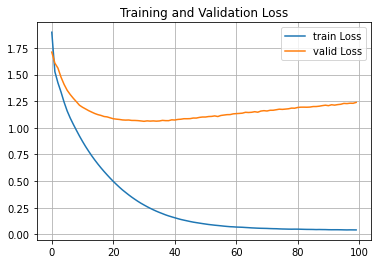

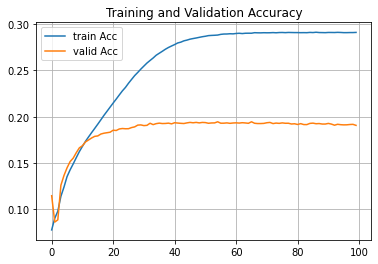

In [113]:
import pandas as pd
from matplotlib import pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(loss, label='train Loss')
plt.plot(val_loss, label='valid Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(acc, label='train Acc')
plt.plot(val_acc, label='valid Acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [114]:
from keras.models import load_model
model = load_model('model.best.h5')

encoder_model = Model(encoder_inputs, encoder_states) # 输入（带embedding），输出思想向量

decoder_state_input_h = Input(shape=(rnn_size,))
decoder_state_input_c = Input(shape=(rnn_size,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(decoder_after_embedding,
                                                             initial_state=decoder_states_inputs)
decoder_states_inf = [state_h_inf, state_c_inf]
decoder_outputs_inf = decoder_dense(decoder_outputs_inf)

In [115]:
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs_inf] + decoder_states_inf
)


In [139]:
# 采样
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = outputToken_idx['BEGIN_']
    stop = False
    decoded_sentence = ''
    while not stop:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)
        sampled_token_idx = np.argmax(output_tokens)
        sampled_word = idx_outputToken[sampled_token_idx]
        decoded_sentence += ' ' + sampled_word

        if sampled_word == '_END' or len(decoded_sentence) > 60:
            stop = True
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_idx
        # Update states
        states_value = [h, c]

    return decoded_sentence


# 简单测试 采样
text_to_translate = 'When I see you, I fall in love with you'
encoder_input_to_translate = np.zeros(
    (1, max_input_seq_len),
    dtype=np.float32)
for t, word in enumerate(text_to_translate.split()):
    encoder_input_to_translate[0, t] = inputToken_idx[word]

print(decode_sequence(encoder_input_to_translate))

 Ich liebe Boston. _END
